# Agency vs Communion - corellation analysis

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load FastText's emdeddings (wikipedia only)
E_ft =  WordEmbedding('../embedding/fast-text/wiki.it.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/wiki.it.reduced.vec
(425, 300)
425 words of dimension 300 : sua, suo, prima, italiano, ..., agrotecnico, credulona, calzolaia, supportivo
425 words of dimension 300 : sua, suo, prima, italiano, ..., agrotecnico, credulona, calzolaia, supportivo


### Step 2: working whit FastText's embeddings

### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[7.9063672e-01 4.8787877e-01 3.9824027e-01 3.5311949e-01 3.3102319e-01
 2.5868079e-01 7.1079853e-08 5.8829958e-08 5.3196310e-08 4.3196874e-08]


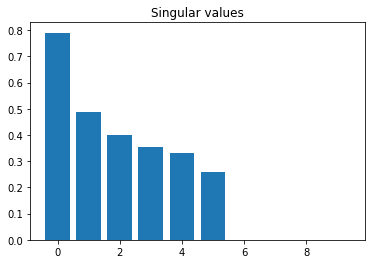

In [7]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [8]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [9]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [10]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [11]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [12]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.5: Compute projections

##### All words

In [13]:
# words
ag_com = db.read('ag_com_mf_ita.txt', 'ag-com-mf')

In [14]:
# compute projections
# all words male
proj_ag_com_m_g_diff =  db.prof_proj(E_ft, ag_com, g_diff, 'ag-com-m')
proj_ag_com_m_g_pca_0 =  db.prof_proj(E_ft, ag_com, g_pca_0, 'ag-com-m')
proj_ag_com_m_g_pca_01 =  db.prof_proj(E_ft, ag_com, g_pca_01, 'ag-com-m')
proj_ag_com_m_g_e =  db.prof_proj(E_ft, ag_com, g_e, 'ag-com-m')

# all words female
proj_ag_com_f_g_diff =  db.prof_proj(E_ft, ag_com, g_diff, 'ag-com-f')
proj_ag_com_f_g_pca_0 =  db.prof_proj(E_ft, ag_com, g_pca_0, 'ag-com-f')
proj_ag_com_f_g_pca_01 =  db.prof_proj(E_ft, ag_com, g_pca_01, 'ag-com-f')
proj_ag_com_f_g_e =  db.prof_proj(E_ft, ag_com, g_e, 'ag-com-f')

In [15]:
# print ag_com_m results
ag_com_m_col0 = [] # pandas columns
ag_com_m_col1 = []
ag_com_m_col2 = []
ag_com_m_col3 = []
ag_com_m_col4 = []
ag_com_m_col5 = []
ag_com_m_col6 = []

for i in range(len(proj_ag_com_m_g_diff)):
    ag_com_m_col0.append(proj_ag_com_m_g_diff[i][0]) # word
    ag_com_m_col1.append(proj_ag_com_m_g_diff[i][1]) # projection on g_diff
    ag_com_m_col2.append(proj_ag_com_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_m_col3.append(proj_ag_com_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_m_col4.append(np.real(proj_ag_com_m_g_e[i][1])) # projection on g_e
    ag_com_m_col5.append(proj_ag_com_m_g_diff[i][2])
    ag_com_m_col6.append(proj_ag_com_m_g_diff[i][3])

ag_com_m_data = {'Word':ag_com_m_col0, 
               'Proj g_diff':ag_com_m_col1,
               'Proj g_pca_0':ag_com_m_col2, 
               'Proj g_pca_01':ag_com_m_col3,
               'Proj g_e':ag_com_m_col4,
               'Agency':ag_com_m_col5,
               'Communion':ag_com_m_col6}

ag_com_m_table = pd.DataFrame(ag_com_m_data)
ag_com_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.105879     -0.136736      -0.095271 -0.012335    2.32   
1          attivo     0.143503     -0.179129      -0.129719 -0.037692    2.35   
2      affettuoso    -0.057171      0.055932       0.033112 -0.065575   -0.85   
3       altruista    -0.089521      0.042477       0.042716 -0.011063   -1.18   
4       ambizioso     0.119887     -0.171909      -0.093449  0.061541    2.79   
5          deciso     0.032785     -0.003449       0.039263  0.008724    2.88   
6        vanitoso    -0.017311     -0.026286       0.000846 -0.021939    1.29   
7          capace     0.080204     -0.068718      -0.096767 -0.112970    2.45   
8   confusionario     0.024486     -0.055910      -0.007015 -0.011806   -1.89   
9    comunicativo     0.044987     -0.046174      -0.072635 -0.079243    1.50   
10     competente     0.112466     -0.042337       0.000529 -0.040653    2.21   
11    competitivo     0.049996     -0.121939      -0.092514 -0.000099    2.71   
12    presuntuoso     0.086057     -0.087454      -0.066513 -0.024466    1.53   
13   coscienzioso     0.136342     -0.096060      -0.072703 -0.032397    0.58   
14     rispettoso     0.107447     -0.137364      -0.133835 -0.029307   -0.35   
15       coerente     0.087400     -0.042743      -0.076009 -0.087420    0.74   
16       creativo    -0.010048     -0.047422      -0.034281 -0.048449    1.63   
17     distaccato     0.046724     -0.008944       0.003494 -0.074570    1.61   
18    determinato     0.082275     -0.102753      -0.119700 -0.088175    2.73   
19         rigido    -0.019377     -0.027385      -0.079788 -0.035510    0.38   
20      dominante    -0.015997      0.026745       0.016411  0.051830    2.76   
21        egoista    -0.081983     -0.015433      -0.022153  0.001517    1.53   
22        emotivo    -0.053989      0.016008       0.028225 -0.000844   -1.47   
23       energico     0.099805     -0.180786      -0.106475  0.025203    2.42   
24         giusto     0.068803     -0.077905      -0.045295 -0.031802   -0.50   
25     amichevole     0.051062     -0.010913      -0.019018 -0.009578    0.15   
26      credulone     0.006091     -0.051874      -0.040522 -0.014107   -2.26   
27           duro     0.063181     -0.097908      -0.037010  0.005003    1.95   
28    disponibile    -0.095916      0.047888       0.027702  0.034715   -0.42   
29         onesto     0.133471     -0.172738      -0.145135 -0.021582   -0.71   
..            ...          ...           ...            ...       ...     ...   
31    industrioso     0.039096     -0.095933      -0.094301 -0.035099    2.33   
32       insicuro    -0.022818     -0.002662       0.024970  0.004383   -2.35   
33   intelligente     0.003335      0.002756      -0.050146 -0.054630    2.21   
34          pigro     0.037936     -0.152954      -0.115832 -0.027112   -2.45   
35          leale     0.103859     -0.074953      -0.056906 -0.029116   -0.88   
36         morale     0.066903     -0.050623      -0.060175 -0.004885   -0.78   
37       ostinato     0.098435     -0.126282      -0.092747 -0.026268    2.43   
38         aperto     0.044805     -0.104441      -0.053204  0.007546    0.45   
39     estroverso    -0.099557     -0.003233       0.007789  0.012745    1.11   
40  perfezionista     0.067490     -0.101835      -0.073314 -0.083725    2.15   
41    persistente    -0.047168      0.022167       0.000694 -0.055307    1.78   
42        educato     0.012781     -0.058439      -0.040243  0.011194    0.13   
43      razionale     0.058093     -0.099355      -0.122229 -0.075036    1.73   
44     affidabile     0.134809     -0.055064      -0.071459 -0.006869    0.45   
45      riservato     0.055826     -0.013604       0.004613  0.009776    0.11   
46    autocritico     0.090788     -0.084194      -0.114401 -0.121342    0.25   
47       autonomo     0.060872     -0.057399      -0.039827 -0.115945    2.76   
48      sensibile    -0.056523      0.022219

In [17]:
# ag_com_m pearson correlation
# agency correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col5, ag_com_m_col4)[1]

In [18]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.354973 -0.272076 -0.182312 -0.122134
p  0.004999  0.033904  0.159647  0.348408

In [19]:
# communion correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(ag_com_m_col6, ag_com_m_col4)[1]

In [20]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.013240  0.076689 -0.109706 -0.069082
p  0.919331  0.556910  0.399986  0.596794

In [21]:
# agency-communion correlation
r_ag_com_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col1)[0]
r_ag_com_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col2)[0]
r_ag_com_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col3)[0]
r_ag_com_m_g_e = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col4)[0]
p_ag_com_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col1)[1]
p_ag_com_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col2)[1]
p_ag_com_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col3)[1]
p_ag_com_m_g_e = scipy.stats.pearsonr(np.array(ag_com_m_col5)-np.array(ag_com_m_col6), ag_com_m_col4)[1]

In [22]:
pearson_data = {'g_diff':[r_ag_com_m_g_diff,p_ag_com_m_g_diff],
                'g_pca_0':[r_ag_com_m_g_pca_0,p_ag_com_m_g_pca_0],
                'g_pca_01':[r_ag_com_m_g_pca_01,p_ag_com_m_g_pca_01],
                'g_e':[r_ag_com_m_g_e,p_ag_com_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.228375 -0.224574 -0.058595 -0.041771
p  0.076687  0.081860  0.653749  0.749249

In [23]:
# print ag_com_f results
ag_com_f_col0 = [] # pandas columns
ag_com_f_col1 = []
ag_com_f_col2 = []
ag_com_f_col3 = []
ag_com_f_col4 = []
ag_com_f_col5 = []
ag_com_f_col6 = []

for i in range(len(proj_ag_com_f_g_diff)):
    ag_com_f_col0.append(proj_ag_com_f_g_diff[i][0]) # word
    ag_com_f_col1.append(proj_ag_com_f_g_diff[i][1]) # projection on g_diff
    ag_com_f_col2.append(proj_ag_com_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_f_col3.append(proj_ag_com_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_f_col4.append(np.real(proj_ag_com_f_g_e[i][1])) # projection on g_e
    ag_com_f_col5.append(proj_ag_com_f_g_diff[i][2])
    ag_com_f_col6.append(proj_ag_com_f_g_diff[i][3])

ag_com_f_data = {'Word':ag_com_f_col0, 
               'Proj g_diff':ag_com_f_col1,
               'Proj g_pca_0':ag_com_f_col2, 
               'Proj g_pca_01':ag_com_f_col3,
               'Proj g_e':ag_com_f_col4,
               'Agency':ag_com_f_col5,
               'Communion':ag_com_f_col6}

ag_com_f_table = pd.DataFrame(ag_com_f_data)
ag_com_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.105879     -0.136736      -0.095271 -0.012335    2.32   
1          attiva    -0.036062      0.044248       0.059125 -0.104597    2.35   
2      affettuosa    -0.107710      0.160871       0.125906 -0.046422   -0.85   
3       altruista    -0.089521      0.042477       0.042716 -0.011063   -1.18   
4       ambiziosa    -0.060695      0.140713       0.177447  0.078144    2.79   
5          decisa    -0.012327      0.122522       0.150207 -0.006840    2.88   
6        vanitosa    -0.197048      0.232705       0.240402 -0.014357    1.29   
7          capace     0.080204     -0.068718      -0.096767 -0.112970    2.45   
8   confusionaria    -0.062482      0.148428       0.143200 -0.012397   -1.89   
9    comunicativa     0.000084      0.060134       0.015971 -0.067457    1.50   
10     competente     0.112466     -0.042337       0.000529 -0.040653    2.21   
11    competitiva    -0.032577      0.053857       0.079572 -0.003998    2.71   
12    presuntuosa    -0.033390      0.105836       0.086791 -0.027779    1.53   
13   coscienziosa     0.020929      0.094075       0.081976 -0.042001    0.58   
14     rispettosa     0.014747      0.084276       0.045522 -0.023857   -0.35   
15       coerente     0.087400     -0.042743      -0.076009 -0.087420    0.74   
16       creativa    -0.048924      0.047117       0.031424 -0.047486    1.63   
17     distaccata    -0.063597      0.193627       0.164045 -0.050300    1.61   
18    determinata    -0.052541      0.121169       0.081159 -0.088817    2.73   
19         rigida    -0.099835      0.094554       0.084080 -0.046289    0.38   
20      dominante    -0.015997      0.026745       0.016411  0.051830    2.76   
21        egoista    -0.081983     -0.015433      -0.022153  0.001517    1.53   
22        emotiva    -0.076055      0.068627       0.048057 -0.015001   -1.47   
23       energica    -0.114104      0.149128       0.199121 -0.029715    2.42   
24         giusta     0.046389      0.034415       0.025113 -0.031802   -0.50   
25     amichevole     0.051062     -0.010913      -0.019018 -0.009578    0.15   
26      credulona    -0.100389      0.125801       0.115483 -0.039289   -2.26   
27           dura    -0.056236      0.074054       0.087800  0.005003    1.95   
28    disponibile    -0.095916      0.047888       0.027702  0.034715   -0.42   
29         onesta    -0.029719      0.136684       0.145981 -0.014239   -0.71   
30   indipendente     0.028278      0.038029       0.025348 -0.105108    2.65   
31    industriosa    -0.018759      0.050461       0.036315 -0.032858    2.33   
32       insicura    -0.168873      0.206593       0.193828 -0.003951   -2.35   
33   intelligente     0.003335      0.002756      -0.050146 -0.054630    2.21   
34          pigra    -0.184686      0.178341       0.164794 -0.093463   -2.45   
35          leale     0.103859     -0.074953      -0.056906 -0.029116   -0.88   
36         morale     0.066903     -0.050623      -0.060175 -0.004885   -0.78   
37       ostinata    -0.003461      0.094577       0.109994 -0.022003    2.43   
38         aperta     0.038821      0.003150       0.068654 -0.048221    0.45   
39     estroversa    -0.209794      0.186746       0.175460 -0.004627    1.11   
40  perfezionista     0.067490     -0.101835      -0.073314 -0.083725    2.15   
41    persistente    -0.047168      0.022167       0.000694 -0.055307    1.78   
42        educata    -0.174896      0.279161       0.237287 -0.000528    0.13   
43      razionale     0.058093     -0.099355      -0.122229 -0.075036    1.73   
44     affidabile     0.134809     -0.055064      -0.071459 -0.006869    0.45   
45      riservata     0.004707      0.112059       0.126789  0.009370    0.11   
46    autocritica     0.069569      0.013334      -0.020034 -0.089889    0.25   
47       autonoma     0.035128      0.030046       0.004582 -0.110083    2.76   
48      sensibile    -0.056523      0.022219

In [24]:
# ag_com_f pearson correlation
# agency correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col5, ag_com_f_col4)[1]

In [25]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.339154 -0.279888 -0.173513 -0.085304
p  0.008028  0.030320  0.184894  0.516957

In [26]:
# communion correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(ag_com_f_col6, ag_com_f_col4)[1]

In [27]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.198439 -0.222004 -0.303620 -0.107396
p  0.128530  0.088230  0.018357  0.414071

In [28]:
# agency-communion correlation
r_ag_com_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col1)[0]
r_ag_com_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col2)[0]
r_ag_com_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col3)[0]
r_ag_com_f_g_e = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col4)[0]
p_ag_com_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col1)[1]
p_ag_com_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col2)[1]
p_ag_com_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col3)[1]
p_ag_com_f_g_e = scipy.stats.pearsonr(np.array(ag_com_f_col5)-np.array(ag_com_f_col6), ag_com_f_col4)[1]

In [29]:
pearson_data = {'g_diff':[r_ag_com_f_g_diff,p_ag_com_f_g_diff],
                'g_pca_0':[r_ag_com_f_g_pca_0,p_ag_com_f_g_pca_0],
                'g_pca_01':[r_ag_com_f_g_pca_01,p_ag_com_f_g_pca_01],
                'g_e':[r_ag_com_f_g_e,p_ag_com_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.113049 -0.060057  0.057496  0.004371
p  0.389780  0.648515  0.662581  0.973558

##### Ungendered words

In [32]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [33]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [34]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.105879     -0.136736      -0.095271 -0.012335    2.32   
1       altruista    -0.089521      0.042477       0.042716 -0.011063   -1.18   
2          capace     0.080204     -0.068718      -0.096767 -0.112970    2.45   
3      competente     0.112466     -0.042337       0.000529 -0.040653    2.21   
4        coerente     0.087400     -0.042743      -0.076009 -0.087420    0.74   
5       dominante    -0.015997      0.026745       0.016411  0.051830    2.76   
6      amichevole     0.051062     -0.010913      -0.019018 -0.009578    0.15   
7     disponibile    -0.095916      0.047888       0.027702  0.034715   -0.42   
8         egoista    -0.081983     -0.015433      -0.022153  0.001517    1.53   
9    indipendente     0.028278      0.038029       0.025348 -0.105108    2.65   
10   intelligente     0.003335      0.002756      -0.050146 -0.054630    2.21   
11          leale     0.103859     -0.074953      -0.056906 -0.029116   -0.88   
12         morale     0.066903     -0.050623      -0.060175 -0.004885   -0.78   
13  perfezionista     0.067490     -0.101835      -0.073314 -0.083725    2.15   
14    persistente    -0.047168      0.022167       0.000694 -0.055307    1.78   
15      razionale     0.058093     -0.099355      -0.122229 -0.075036    1.73   
16     affidabile     0.134809     -0.055064      -0.071459 -0.006869    0.45   
17      sensibile    -0.056523      0.022219      -0.035251 -0.124810   -1.03   
18      socievole    -0.087617      0.019934      -0.003408  0.002551    0.66   
19     tollerante     0.066366     -0.034339      -0.062102 -0.069806   -0.34   
20    vulnerabile    -0.044741      0.047104       0.005507  0.000451   -2.29   

    Communion  
0        0.66  
1        2.50  
2        1.08  
3        0.61  
4        1.68  
5       -1.89  
6        2.23  
7        2.76  
8       -2.50  
9       -0.83  
10       1.16  
11       2.28  
12       1.58  
13       0.05  
14       0.23  
15       0.53  
16       2.21  
17       1.70  
18       2.71  
19       2.63  
20      -0.16

In [35]:
# ag_com_ung pearson correlation
# agency correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[1]

In [36]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency ungendered correlation")
pearson_table

Agency ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.268311 -0.319935 -0.203873 -0.209312
p  0.239601  0.157411  0.375392  0.362508

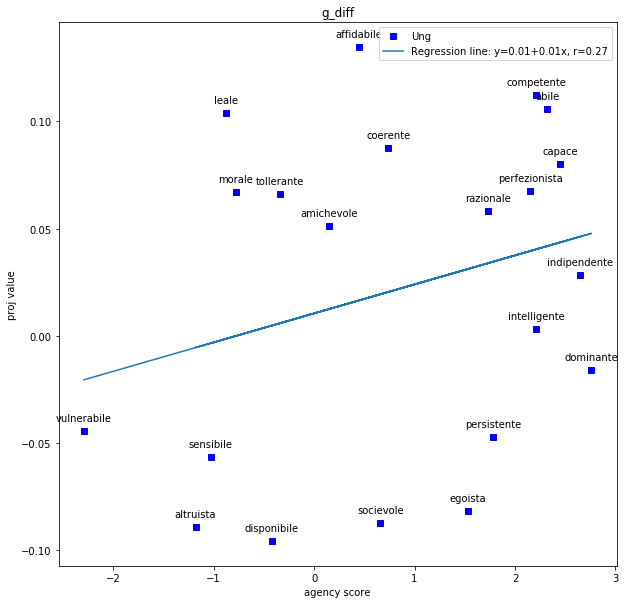

In [37]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_g_diff')

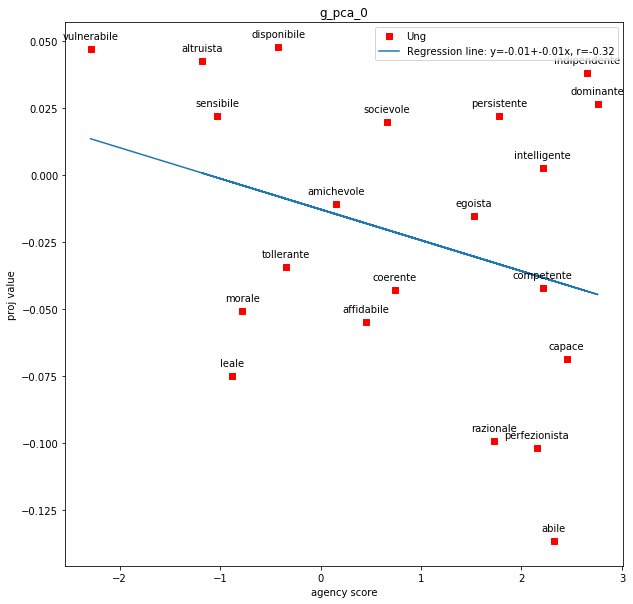

In [38]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_g_pca_0')

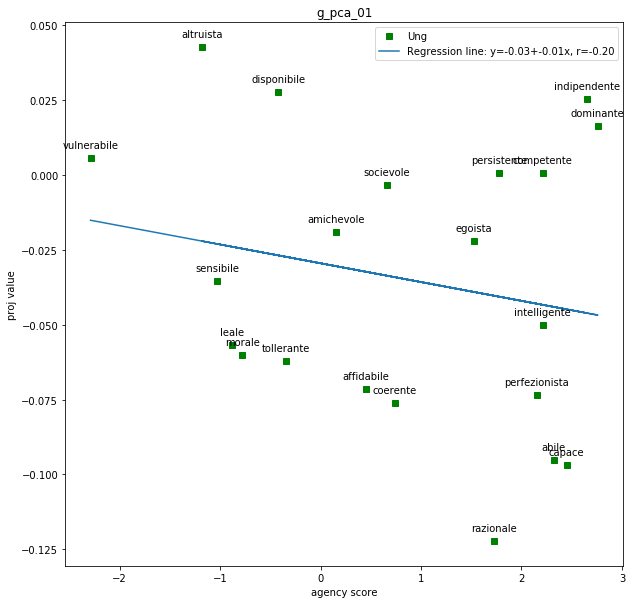

In [39]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_g_pca_01')

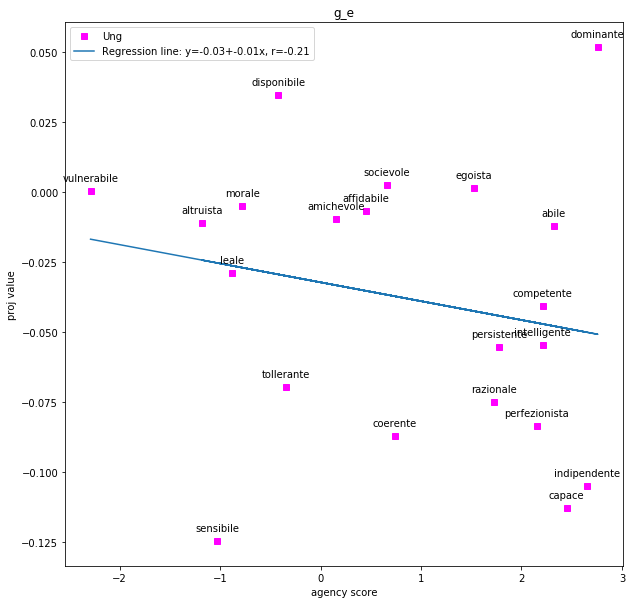

In [40]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_g_e')

In [42]:
# communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[1]

In [43]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion ungendered correlation")
pearson_table

Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.120362 -0.031481 -0.115713 -0.046416
p  0.603279  0.892247  0.617444  0.841647

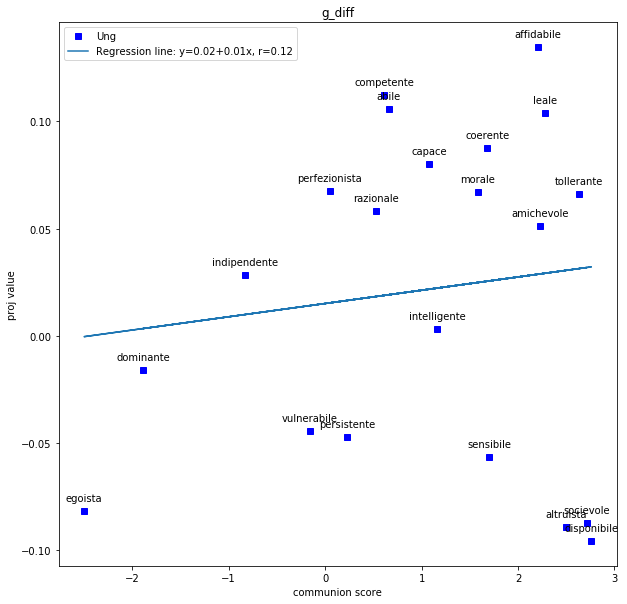

In [44]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_g_diff')

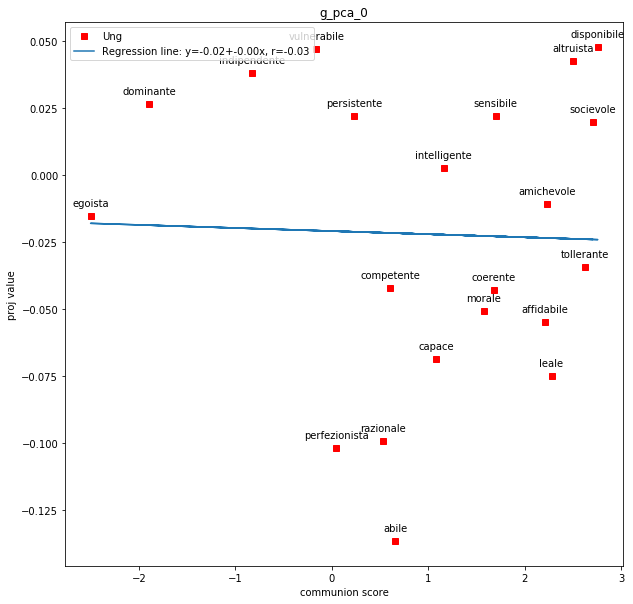

In [45]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_g_pca_0')

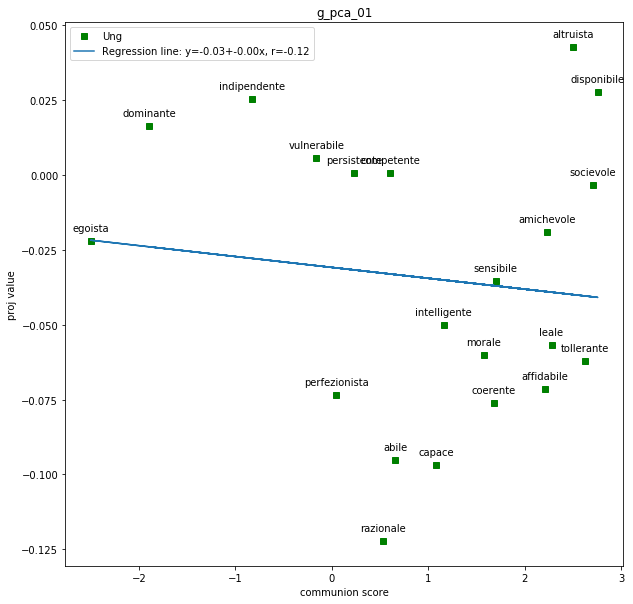

In [46]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_g_pca_01')

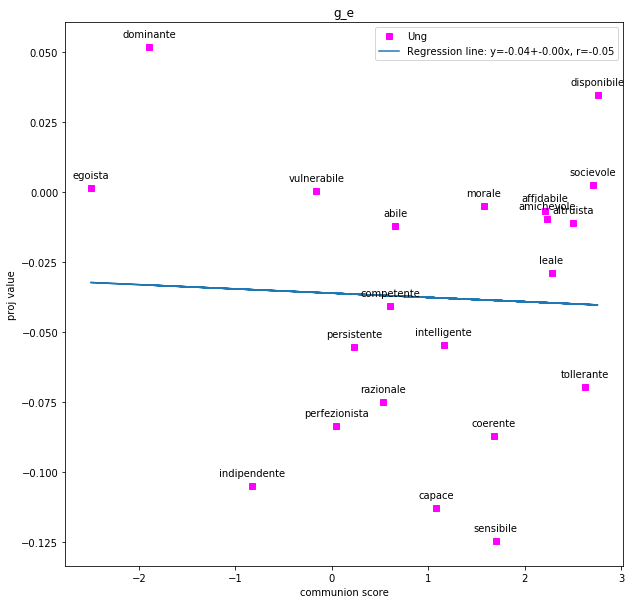

In [47]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_g_e')

In [48]:
# agency-communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[0]

In [49]:
pearson_data = {'g_diff':r_ag_com_ung_g_diff,
                'g_pca_0':r_ag_com_ung_g_pca_0,
                'g_pca_01':r_ag_com_ung_g_pca_01,
                'g_e':r_ag_com_ung_g_e}
pearson_table = pd.DataFrame(pearson_data, index=['r'])
print("Agency-Communion ungendered correlation")
pearson_table

Agency-Communion ungendered correlation


g_diff  g_pca_0  g_pca_01       g_e
r  0.086697 -0.16671 -0.052164 -0.094472

##### Gendered words

In [50]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [51]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [52]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attivo     0.143503     -0.179129      -0.129719 -0.037692    2.35   
1      affettuoso    -0.057171      0.055932       0.033112 -0.065575   -0.85   
2       ambizioso     0.119887     -0.171909      -0.093449  0.061541    2.79   
3          deciso     0.032785     -0.003449       0.039263  0.008724    2.88   
4        vanitoso    -0.017311     -0.026286       0.000846 -0.021939    1.29   
5   confusionario     0.024486     -0.055910      -0.007015 -0.011806   -1.89   
6    comunicativo     0.044987     -0.046174      -0.072635 -0.079243    1.50   
7     competitivo     0.049996     -0.121939      -0.092514 -0.000099    2.71   
8     presuntuoso     0.086057     -0.087454      -0.066513 -0.024466    1.53   
9    coscienzioso     0.136342     -0.096060      -0.072703 -0.032397    0.58   
10     rispettoso     0.107447     -0.137364      -0.133835 -0.029307   -0.35   
11       creativo    -0.010048     -0.047422      -0.034281 -0.048449    1.63   
12     distaccato     0.046724     -0.008944       0.003494 -0.074570    1.61   
13    determinato     0.082275     -0.102753      -0.119700 -0.088175    2.73   
14         rigido    -0.019377     -0.027385      -0.079788 -0.035510    0.38   
15        emotivo    -0.053989      0.016008       0.028225 -0.000844   -1.47   
16       energico     0.099805     -0.180786      -0.106475  0.025203    2.42   
17         giusto     0.068803     -0.077905      -0.045295 -0.031802   -0.50   
18      credulone     0.006091     -0.051874      -0.040522 -0.014107   -2.26   
19           duro     0.063181     -0.097908      -0.037010  0.005003    1.95   
20         onesto     0.133471     -0.172738      -0.145135 -0.021582   -0.71   
21    industrioso     0.039096     -0.095933      -0.094301 -0.035099    2.33   
22       insicuro    -0.022818     -0.002662       0.024970  0.004383   -2.35   
23          pigro     0.037936     -0.152954      -0.115832 -0.027112   -2.45   
24       ostinato     0.098435     -0.126282      -0.092747 -0.026268    2.43   
25         aperto     0.044805     -0.104441      -0.053204  0.007546    0.45   
26     estroverso    -0.099557     -0.003233       0.007789  0.012745    1.11   
27        educato     0.012781     -0.058439      -0.040243  0.011194    0.13   
28      riservato     0.055826     -0.013604       0.004613  0.009776    0.11   
29    autocritico     0.090788     -0.084194      -0.114401 -0.121342    0.25   
30       autonomo     0.060872     -0.057399      -0.039827 -0.115945    2.76   
31         timido    -0.045454     -0.067129      -0.046337 -0.016173   -2.25   
32     combattivo     0.157384     -0.159183      -0.127921 -0.056086    2.55   
33       risoluto     0.066344     -0.123002      -0.032980  0.012821    2.48   
34     supportivo     0.022033     -0.019899      -0.031522 -0.009614   -0.27   
35       empatico     0.007777     -0.114125      -0.141964 -0.050968   -0.53   
36      fiducioso     0.127034     -0.084986      -0.101009  0.022126    0.23   
37    comprensivo     0.004860     -0.040706      -0.053688 -0.027454   -0.37   
38       vigoroso     0.064531     -0.107755      -0.064657 -0.023035    1.55   
39          caldo    -0.013701     -0.034624      -0.041388 -0.053255    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [53]:
# ag_com_gen_m pearson correlation
# agency correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[1]

In [54]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.433671 -0.318585 -0.193411 -0.063903
p  0.005181  0.045117  0.231782  0.695249

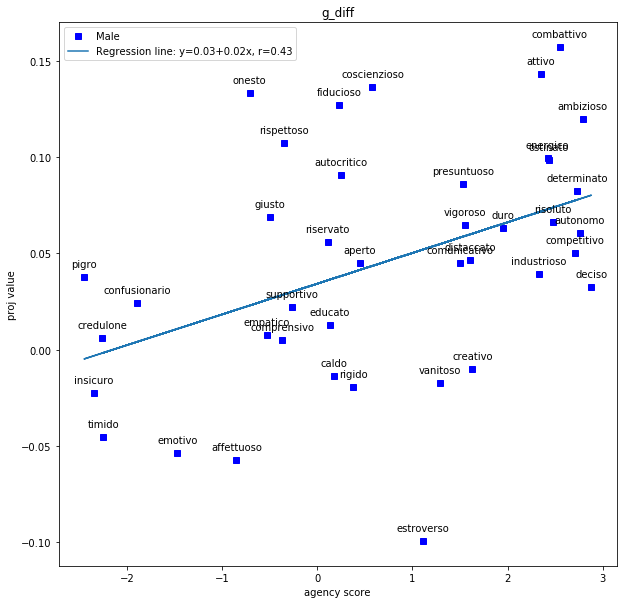

In [55]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_g_diff')

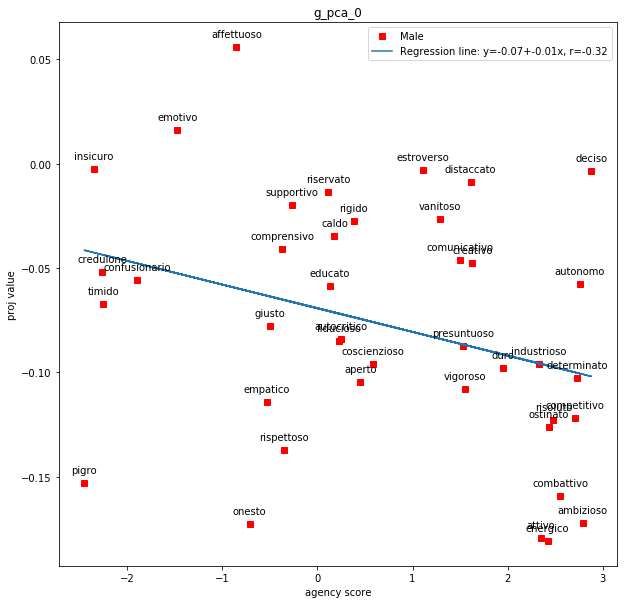

In [56]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_g_pca_0')

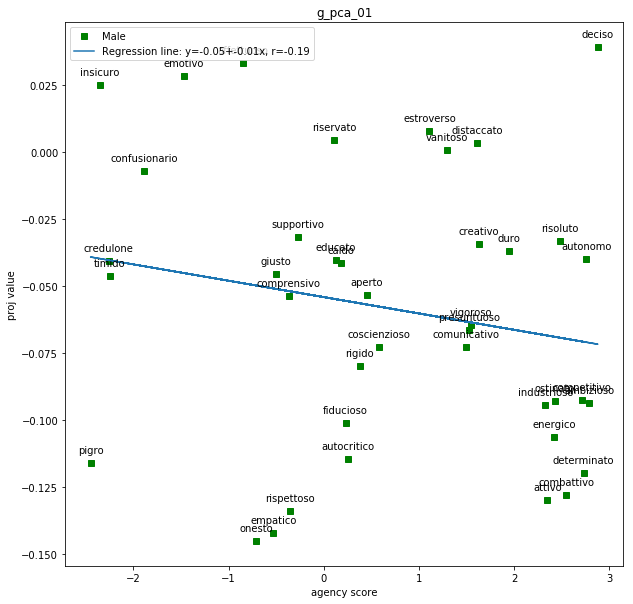

In [57]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_g_pca_01')

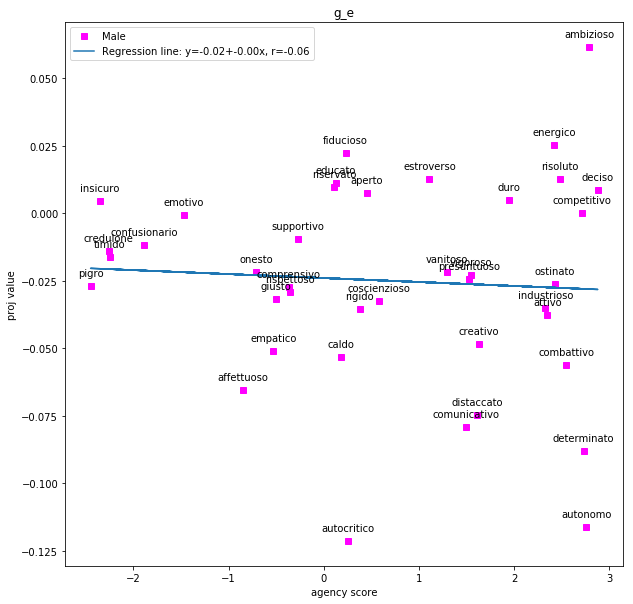

In [58]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_g_e')

In [59]:
# communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[1]

In [60]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r -0.009660  0.015752 -0.181534 -0.040916
p  0.952827  0.923144  0.262262  0.802064

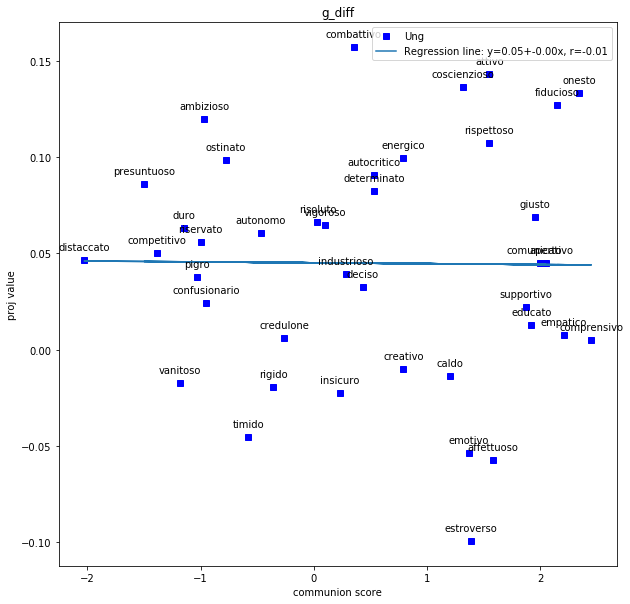

In [61]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_g_diff')

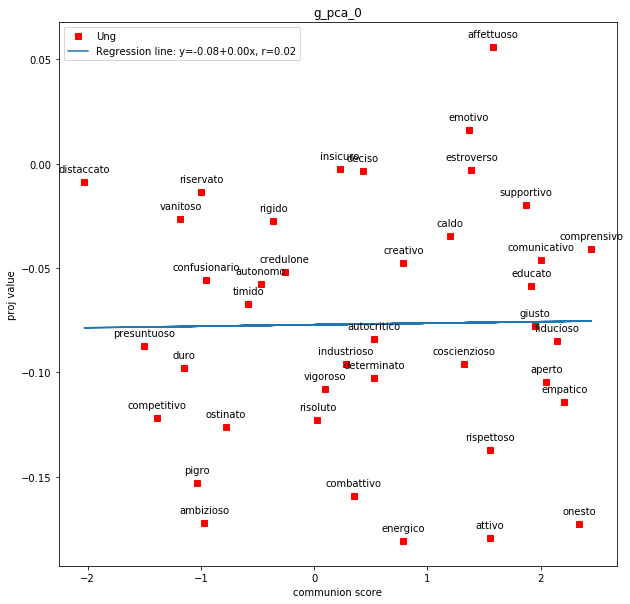

In [62]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_g_pca_0')

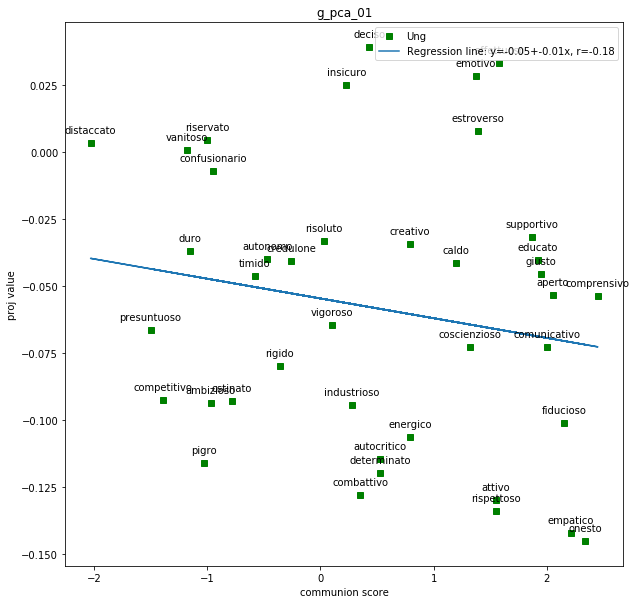

In [63]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_g_pca_01')

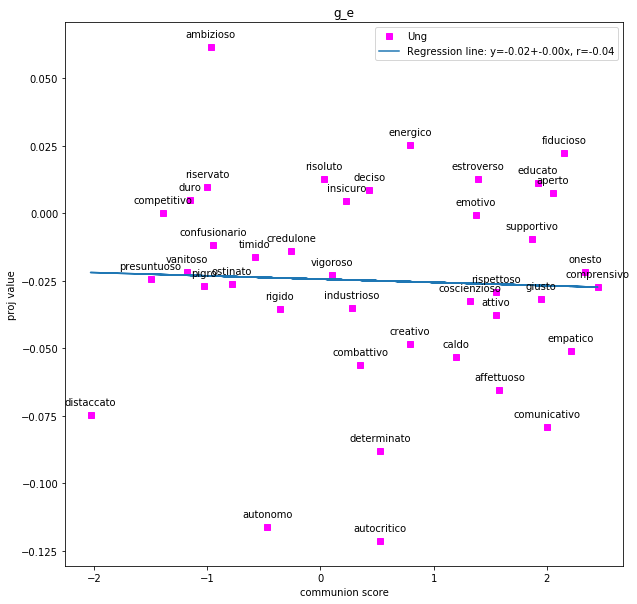

In [64]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_g_e')

In [65]:
# agency-communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[1]

In [66]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.317940 -0.238415 -0.037693 -0.023132
p  0.045578  0.138470  0.817382  0.887334

In [67]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attiva    -0.036062      0.044248       0.059125 -0.104597    2.35   
1      affettuosa    -0.107710      0.160871       0.125906 -0.046422   -0.85   
2       ambiziosa    -0.060695      0.140713       0.177447  0.078144    2.79   
3          decisa    -0.012327      0.122522       0.150207 -0.006840    2.88   
4        vanitosa    -0.197048      0.232705       0.240402 -0.014357    1.29   
5   confusionaria    -0.062482      0.148428       0.143200 -0.012397   -1.89   
6    comunicativa     0.000084      0.060134       0.015971 -0.067457    1.50   
7     competitiva    -0.032577      0.053857       0.079572 -0.003998    2.71   
8     presuntuosa    -0.033390      0.105836       0.086791 -0.027779    1.53   
9    coscienziosa     0.020929      0.094075       0.081976 -0.042001    0.58   
10     rispettosa     0.014747      0.084276       0.045522 -0.023857   -0.35   
11       creativa    -0.048924      0.047117       0.031424 -0.047486    1.63   
12     distaccata    -0.063597      0.193627       0.164045 -0.050300    1.61   
13    determinata    -0.052541      0.121169       0.081159 -0.088817    2.73   
14         rigida    -0.099835      0.094554       0.084080 -0.046289    0.38   
15        emotiva    -0.076055      0.068627       0.048057 -0.015001   -1.47   
16       energica    -0.114104      0.149128       0.199121 -0.029715    2.42   
17         giusta     0.046389      0.034415       0.025113 -0.031802   -0.50   
18      credulona    -0.100389      0.125801       0.115483 -0.039289   -2.26   
19           dura    -0.056236      0.074054       0.087800  0.005003    1.95   
20         onesta    -0.029719      0.136684       0.145981 -0.014239   -0.71   
21    industriosa    -0.018759      0.050461       0.036315 -0.032858    2.33   
22       insicura    -0.168873      0.206593       0.193828 -0.003951   -2.35   
23          pigra    -0.184686      0.178341       0.164794 -0.093463   -2.45   
24       ostinata    -0.003461      0.094577       0.109994 -0.022003    2.43   
25         aperta     0.038821      0.003150       0.068654 -0.048221    0.45   
26     estroversa    -0.209794      0.186746       0.175460 -0.004627    1.11   
27        educata    -0.174896      0.279161       0.237287 -0.000528    0.13   
28      riservata     0.004707      0.112059       0.126789  0.009370    0.11   
29    autocritica     0.069569      0.013334      -0.020034 -0.089889    0.25   
30       autonoma     0.035128      0.030046       0.004582 -0.110083    2.76   
31         timida    -0.268939      0.280153       0.257250 -0.027516   -2.25   
32     combattiva     0.003825      0.049586       0.033032 -0.063164    2.55   
33       risoluta    -0.039606      0.080464       0.118878 -0.001998    2.48   
34       empatica    -0.130075      0.124107       0.069082 -0.035654   -0.53   
35      fiduciosa    -0.040958      0.139961       0.068819 -0.014091    0.23   
36    comprensiva    -0.059858      0.095803       0.051094 -0.017672   -0.37   
37       vigorosa    -0.002035      0.009126       0.027135 -0.011224    1.55   
38          calda    -0.089212      0.100005       0.048597 -0.053255    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       2.21  
35       2.15  
36       2.45  
37       0.10  
38       1.20

In [68]:
# ag_com_gen_f pearson correlation
# agency correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[1]

In [69]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.410120 -0.380965 -0.223532 -0.003052
p  0.009513  0.016724  0.171337  0.985287

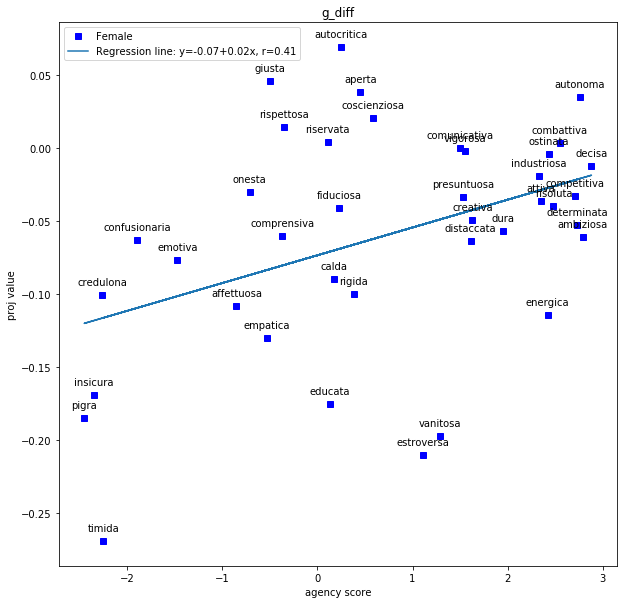

In [70]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_g_diff')

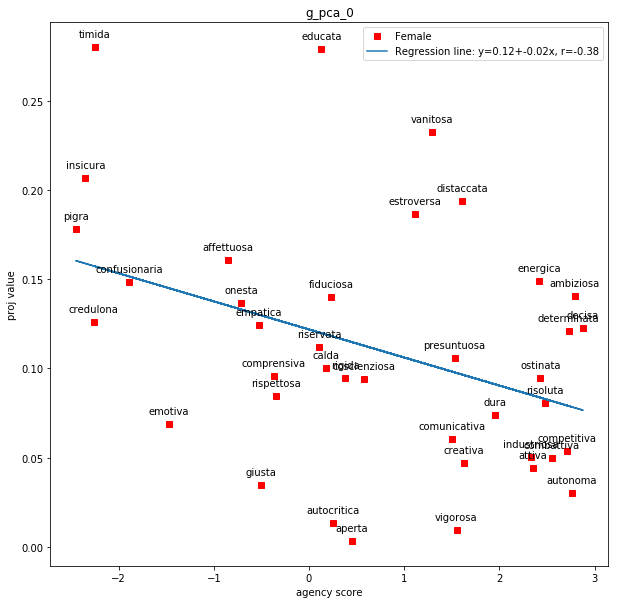

In [71]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_g_pca_0')

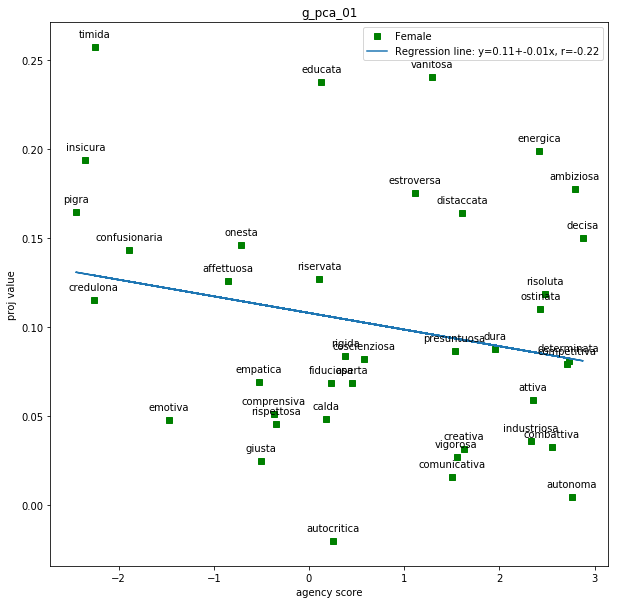

In [72]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_g_pca_01')

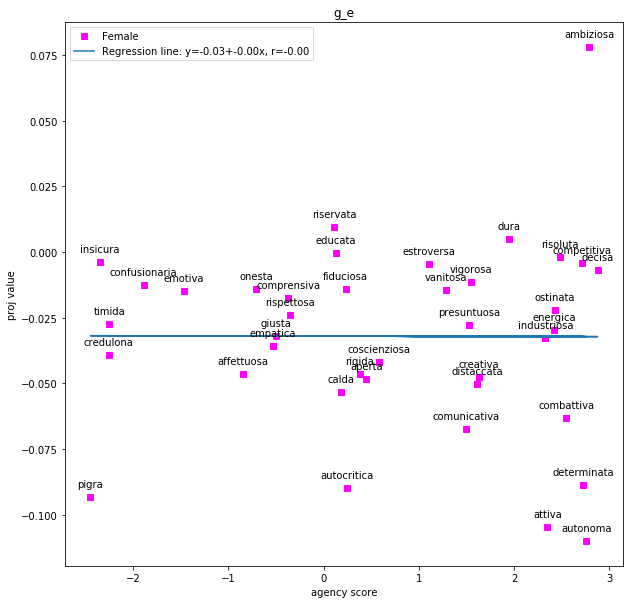

In [73]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_g_e')

In [74]:
# communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[1]

In [75]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.126395 -0.162719 -0.297602 -0.138405
p  0.443237  0.322304  0.065769  0.400756

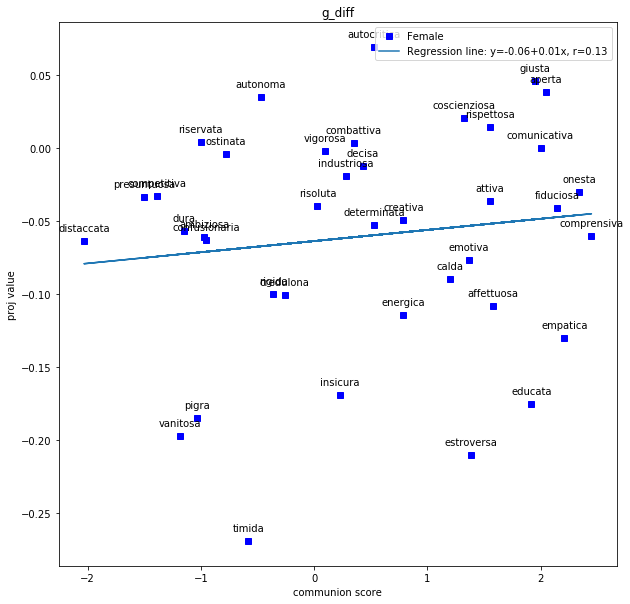

In [76]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_g_diff')

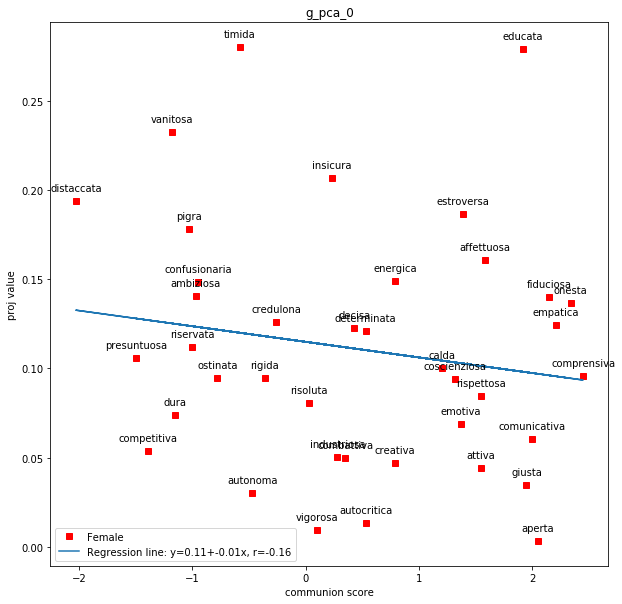

In [77]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_g_pca_0')

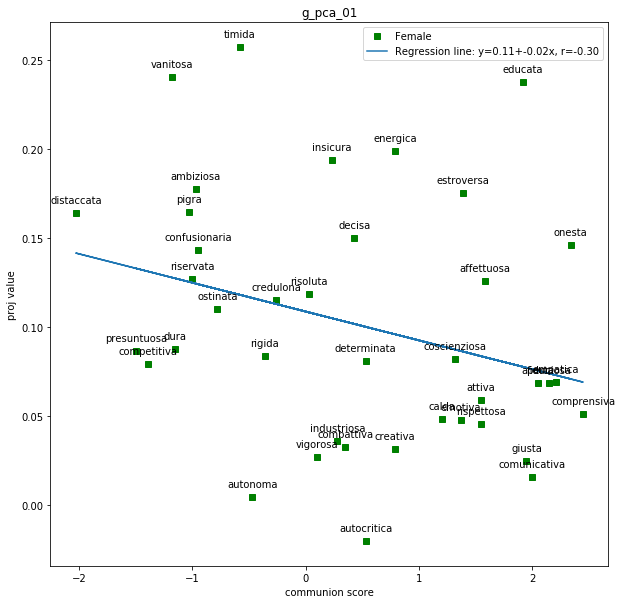

In [78]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_g_pca_01')

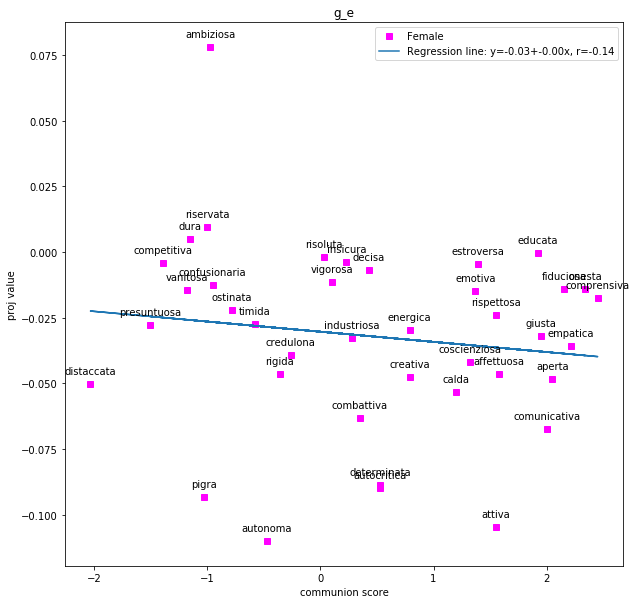

In [79]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_g_e')

In [80]:
# agency-communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[1]

In [81]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.227724 -0.186203  0.003755  0.075162
p  0.163238  0.256391  0.981899  0.649281

In [82]:
# both male and female agency plot

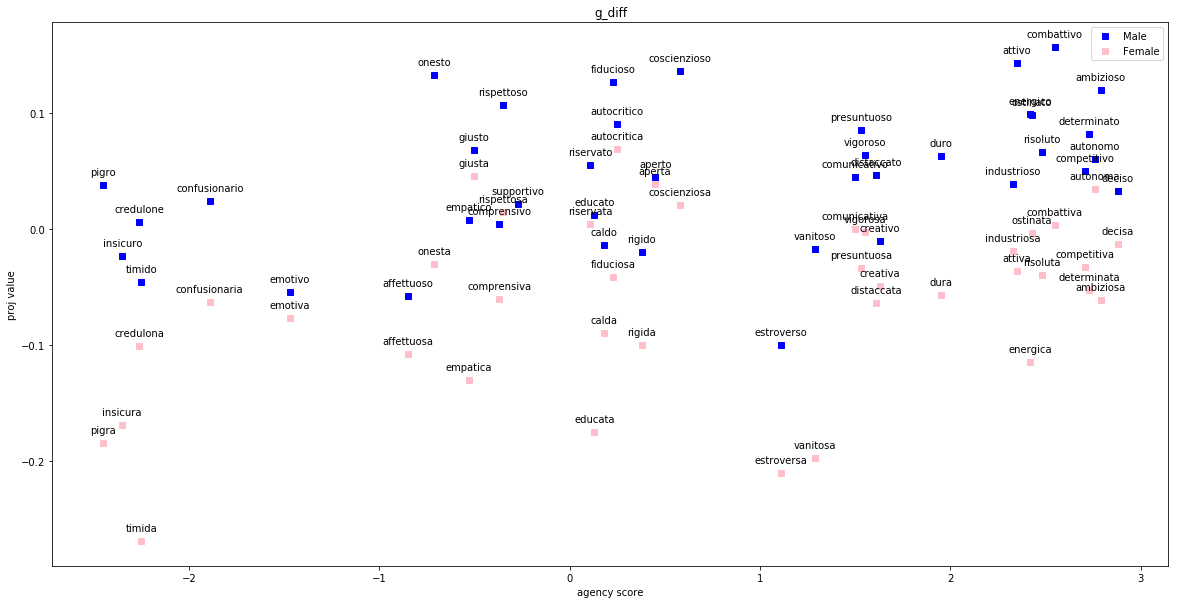

In [83]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_g_diff')

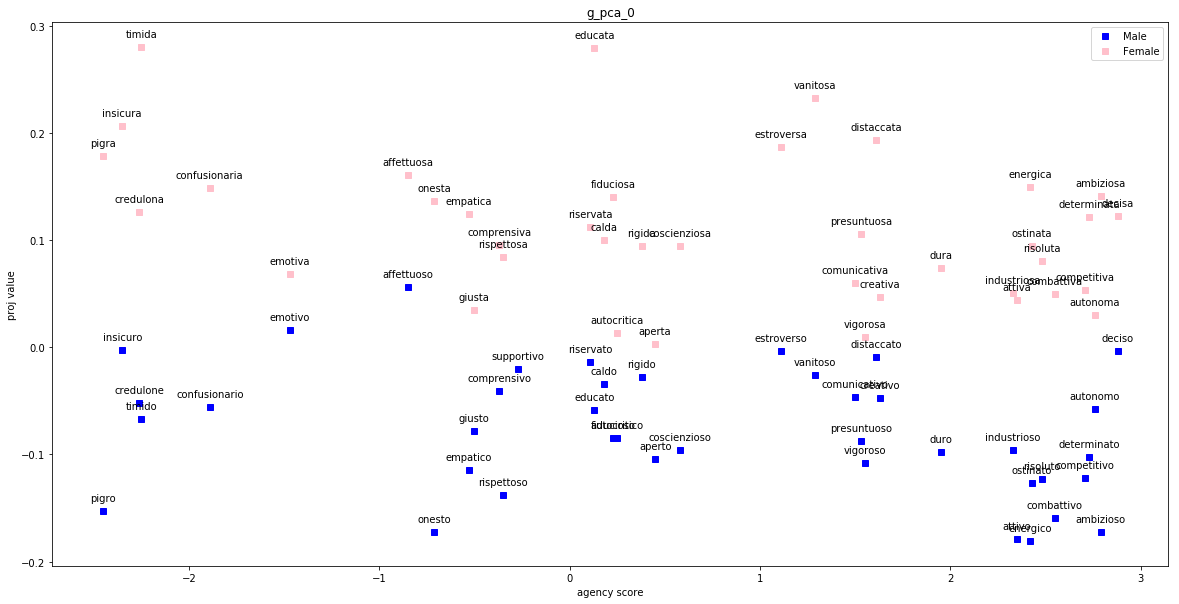

In [84]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_g_pca_0')

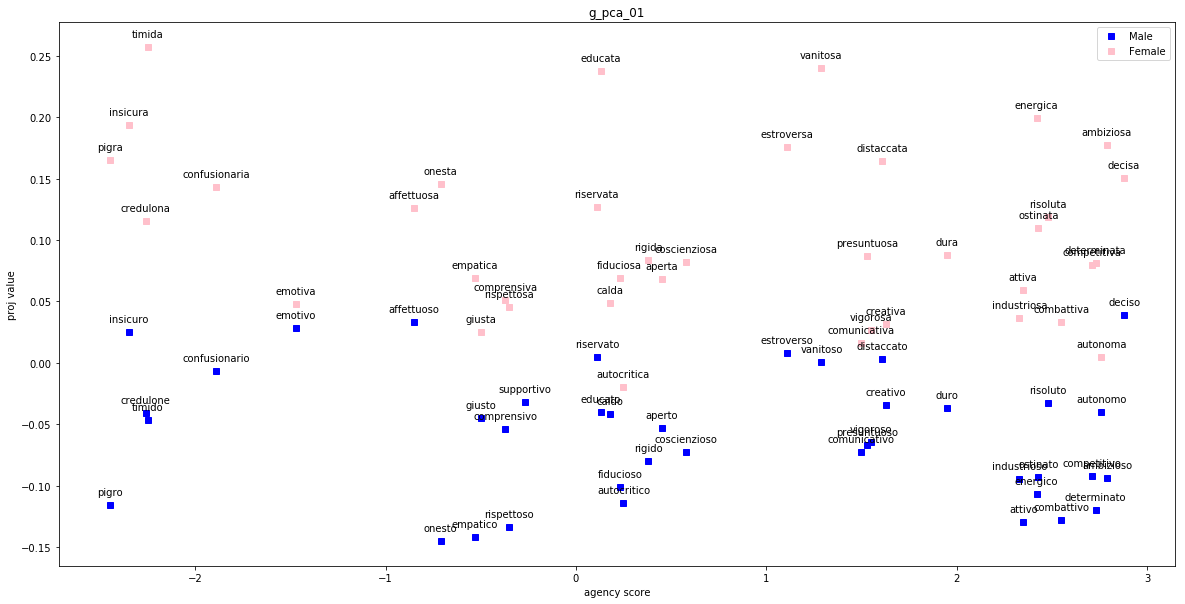

In [85]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_g_pca_01')

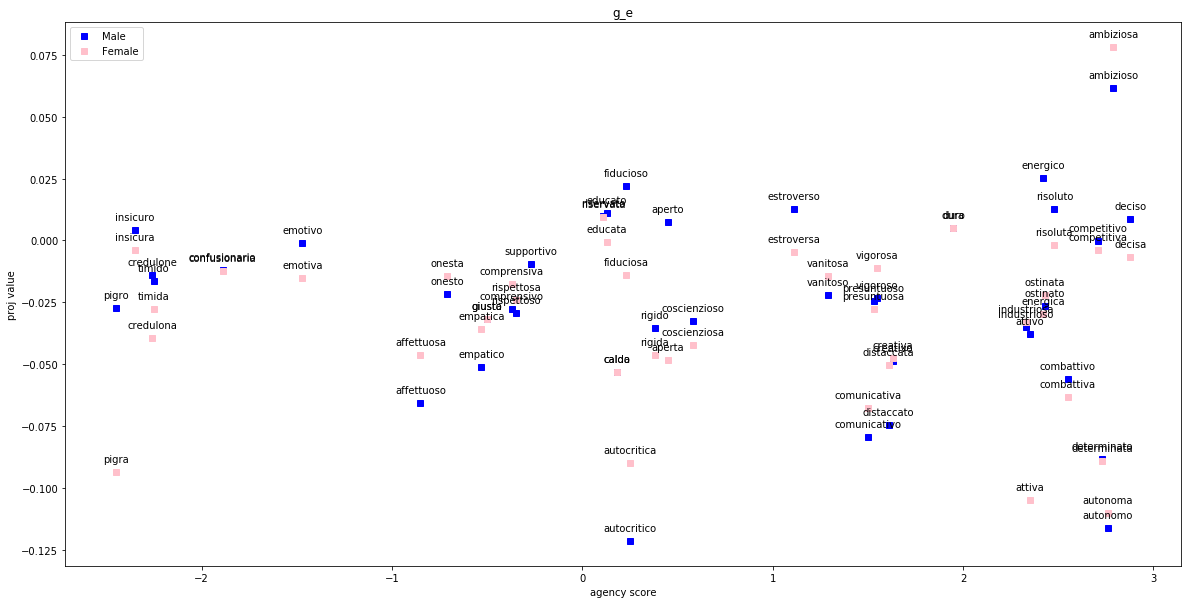

In [86]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_g_e')

In [87]:
# both male and female communion plot

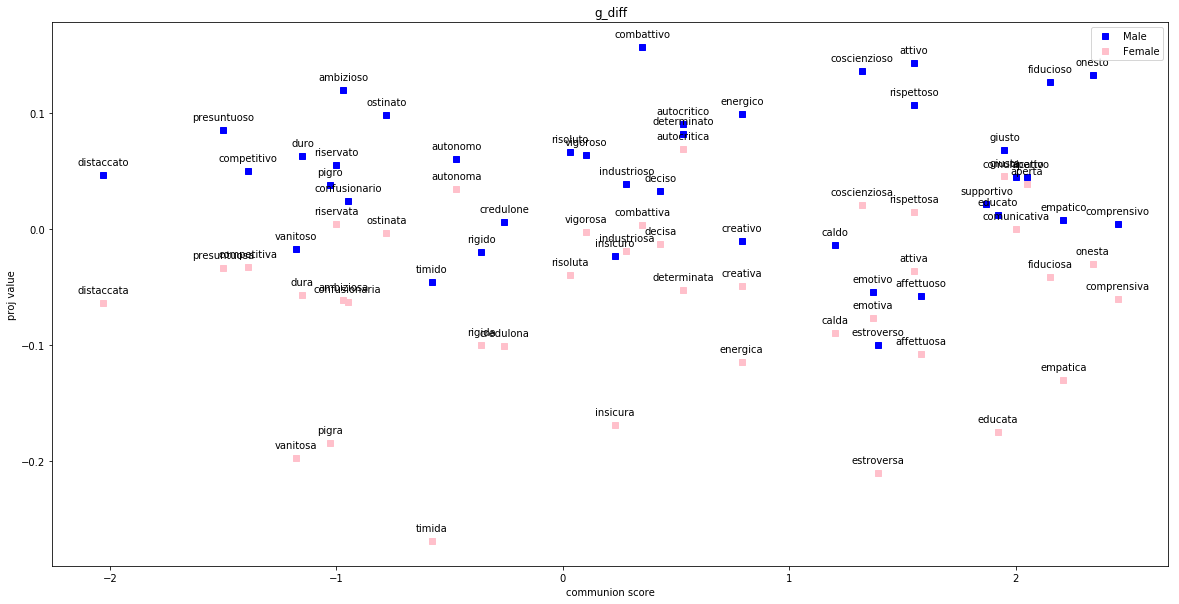

In [88]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_g_diff')

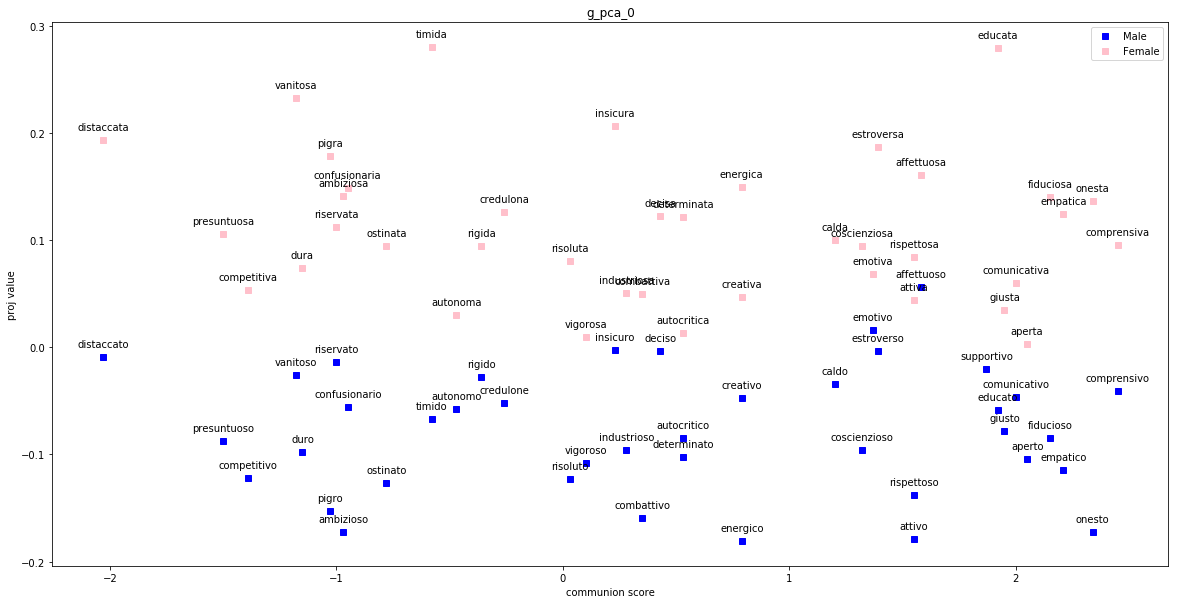

In [89]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_g_pca_0')

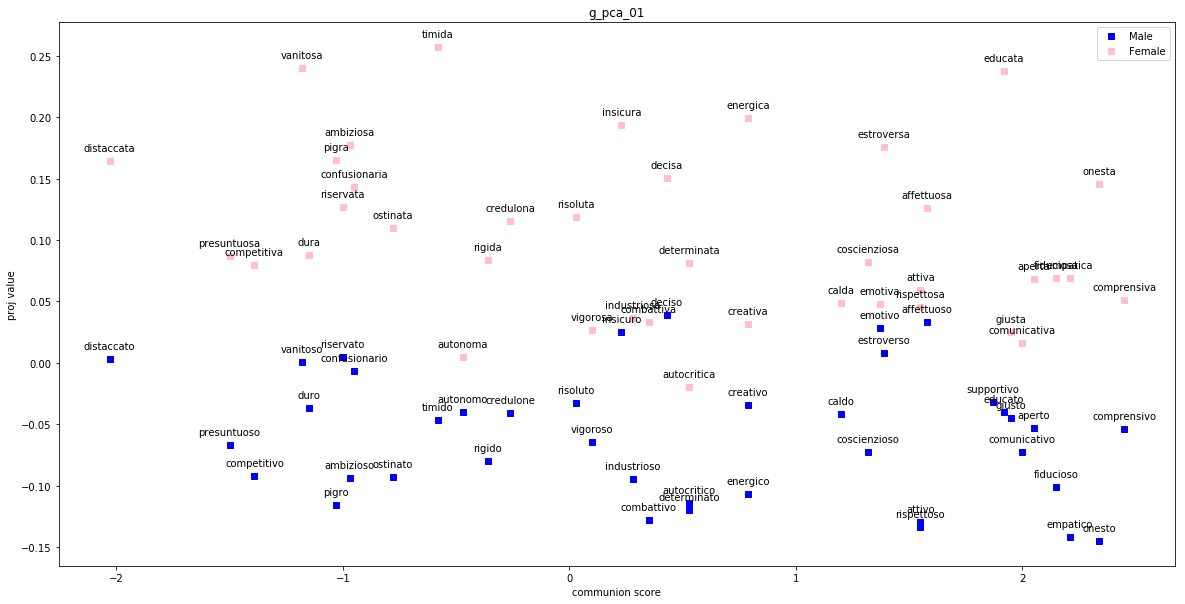

In [90]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_g_pca_01')

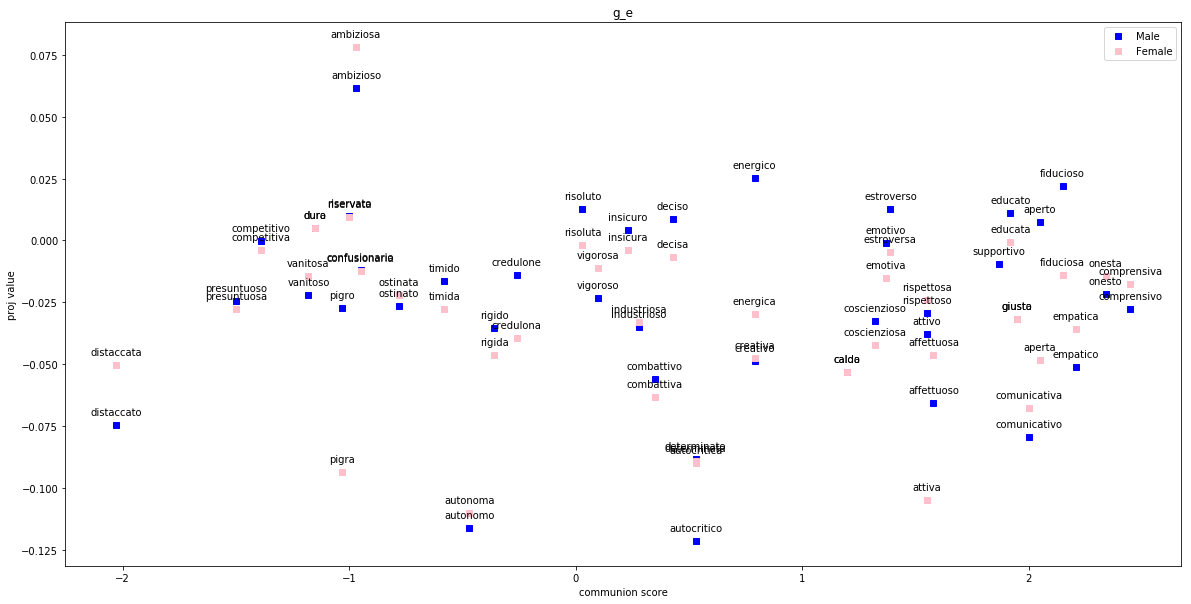

In [91]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_g_e')

##### Ungendered + mean gendered words

In [92]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])

# remove 'supportivo' ('supportiva' embedding non available)
proj_ag_com_gen_m_g_diff.pop(34)
proj_ag_com_gen_m_g_pca_0.pop(34)
proj_ag_com_gen_m_g_pca_01.pop(34)
proj_ag_com_gen_m_g_e.pop(34)
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.105879     -0.136736      -0.095271 -0.012335    2.32   
1       altruista    -0.089521      0.042477       0.042716 -0.011063   -1.18   
2          capace     0.080204     -0.068718      -0.096767 -0.112970    2.45   
3      competente     0.112466     -0.042337       0.000529 -0.040653    2.21   
4        coerente     0.087400     -0.042743      -0.076009 -0.087420    0.74   
5       dominante    -0.015997      0.026745       0.016411  0.051830    2.76   
6      amichevole     0.051062     -0.010913      -0.019018 -0.009578    0.15   
7     disponibile    -0.095916      0.047888       0.027702  0.034715   -0.42   
8         egoista    -0.081983     -0.015433      -0.022153  0.001517    1.53   
9    indipendente     0.028278      0.038029       0.025348 -0.105108    2.65   
10   intelligente     0.003335      0.002756      -0.050146 -0.054630    2.21   
11          leale     0.103859     -0.074953      -0.056906 -0.029116   -0.88   
12         morale     0.066903     -0.050623      -0.060175 -0.004885   -0.78   
13  perfezionista     0.067490     -0.101835      -0.073314 -0.083725    2.15   
14    persistente    -0.047168      0.022167       0.000694 -0.055307    1.78   
15      razionale     0.058093     -0.099355      -0.122229 -0.075036    1.73   
16     affidabile     0.134809     -0.055064      -0.071459 -0.006869    0.45   
17      sensibile    -0.056523      0.022219      -0.035251 -0.124810   -1.03   
18      socievole    -0.087617      0.019934      -0.003408  0.002551    0.66   
19     tollerante     0.066366     -0.034339      -0.062102 -0.069806   -0.34   
20    vulnerabile    -0.044741      0.047104       0.005507  0.000451   -2.29   
21         attivo     0.053721     -0.067441      -0.035297 -0.071145    2.35   
22     affettuoso    -0.082441      0.108401       0.079509 -0.055999   -0.85   
23      ambizioso     0.029596     -0.015598       0.041999  0.069842    2.79   
24         deciso     0.010229      0.059537       0.094735  0.000942    2.88   
25       vanitoso    -0.107180      0.103209       0.120624 -0.018148    1.29   
26  confusionario    -0.018998      0.046259       0.068093 -0.012101   -1.89   
27   comunicativo     0.022536      0.006980      -0.028332 -0.073350    1.50   
28    competitivo     0.008709     -0.034041      -0.006471 -0.002048    2.71   
29    presuntuoso     0.026333      0.009191       0.010139 -0.026122    1.53   
30   coscienzioso     0.078636     -0.000993       0.004636 -0.037199    0.58   
31     rispettoso     0.061097     -0.026544      -0.044156 -0.026582   -0.35   
32       creativo    -0.029486     -0.000153      -0.001428 -0.047967    1.63   
33     distaccato    -0.008437      0.092341       0.083770 -0.062435    1.61   
34    determinato     0.014867      0.009208      -0.019270 -0.088496    2.73   
35         rigido    -0.059606      0.033584       0.002146 -0.040900    0.38   
36        emotivo    -0.065022      0.042318       0.038141 -0.007922   -1.47   
37       energico    -0.007150     -0.015829       0.046323 -0.002256    2.42   
38         giusto     0.057596     -0.021745      -0.010091 -0.031802   -0.50   
39      credulone    -0.047149      0.036963       0.037481 -0.026698   -2.26   
40           duro     0.003473     -0.011927       0.025395  0.005003    1.95   
41         onesto     0.051876     -0.018027       0.000423 -0.017910   -0.71   
42    industrioso     0.010169     -0.022736      -0.028993 -0.033979    2.33   
43       insicuro    -0.095846      0.101966       0.109399  0.000216   -2.35   
44          pigro    -0.073375      0.012694       0.024481 -0.060287   -2.45   
45       ostinato     0.047487     -0.015852       0.008624 -0.024136    2.43   
46         aperto     0.041813     -0.050645       0.007725 -0.020337    0.45   
47     estroverso    -0.154675      0.091757       0.091624  0.004059    1.11   
48        educato    -0.081058      0.110361

In [93]:
# ag_com_mean pearson correlation
# agency correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[1]

In [94]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency mean correlation")
pearson_table

Agency mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.385715 -0.384207 -0.224929 -0.104560
p  0.002338  0.002440  0.084013  0.426575

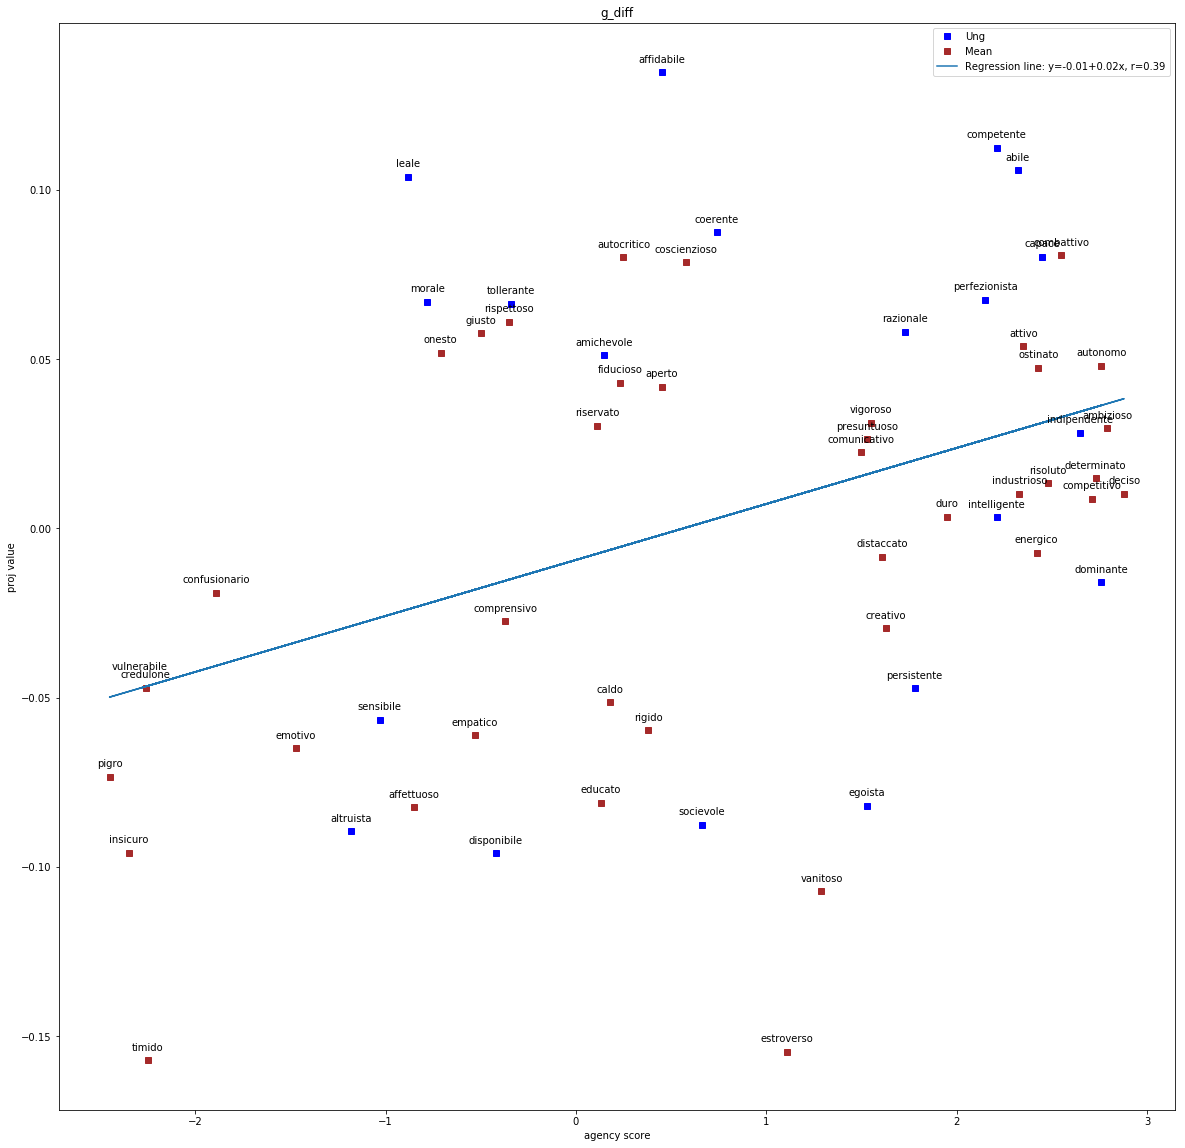

In [95]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_g_diff')

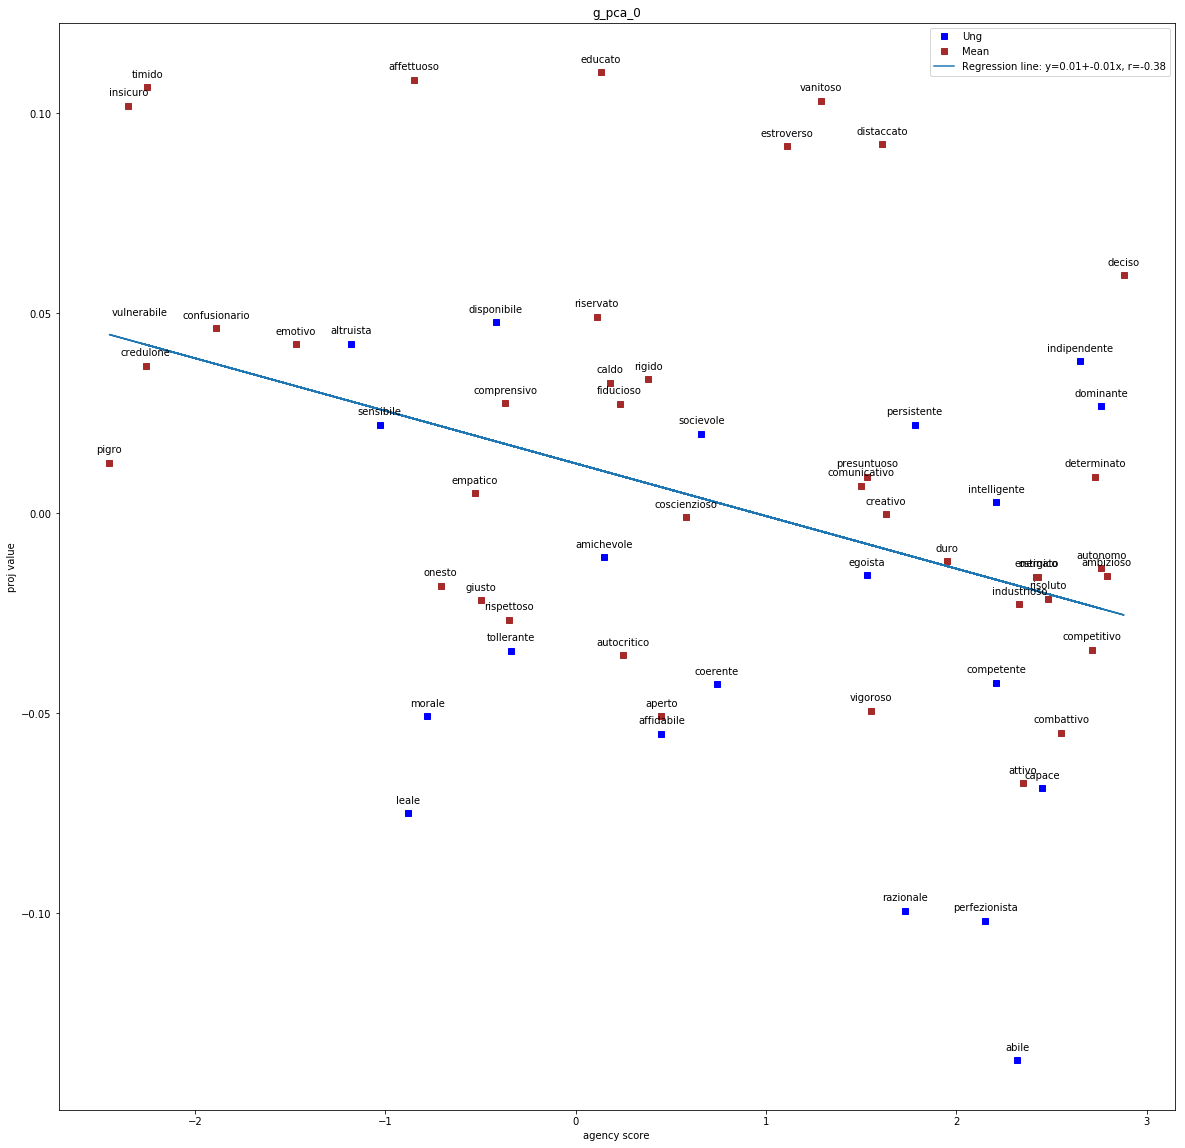

In [96]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_g_pca_0')

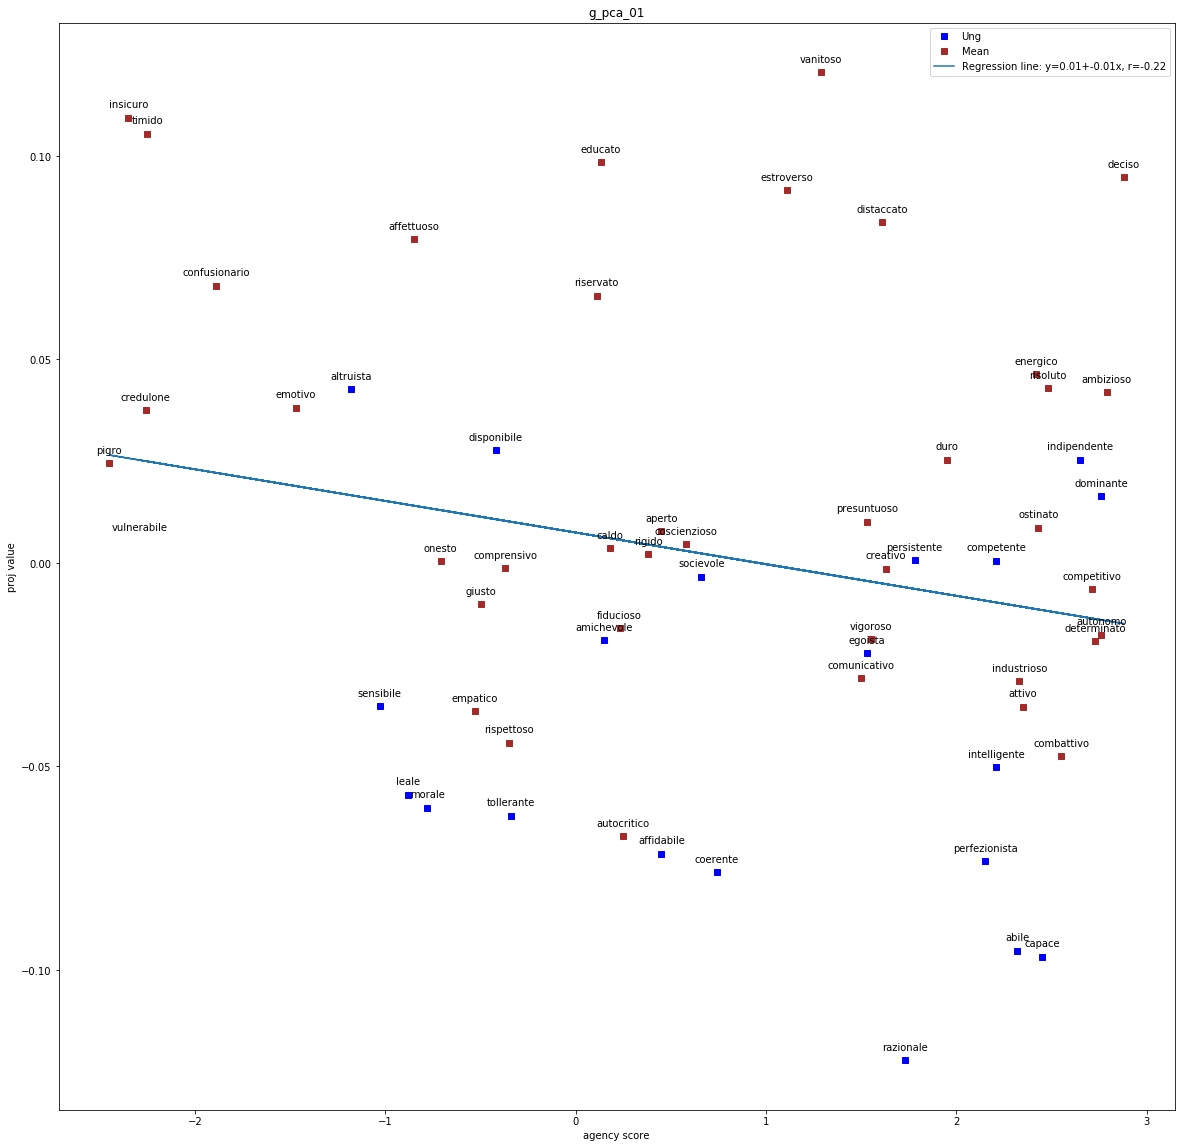

In [97]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_g_pca_01')

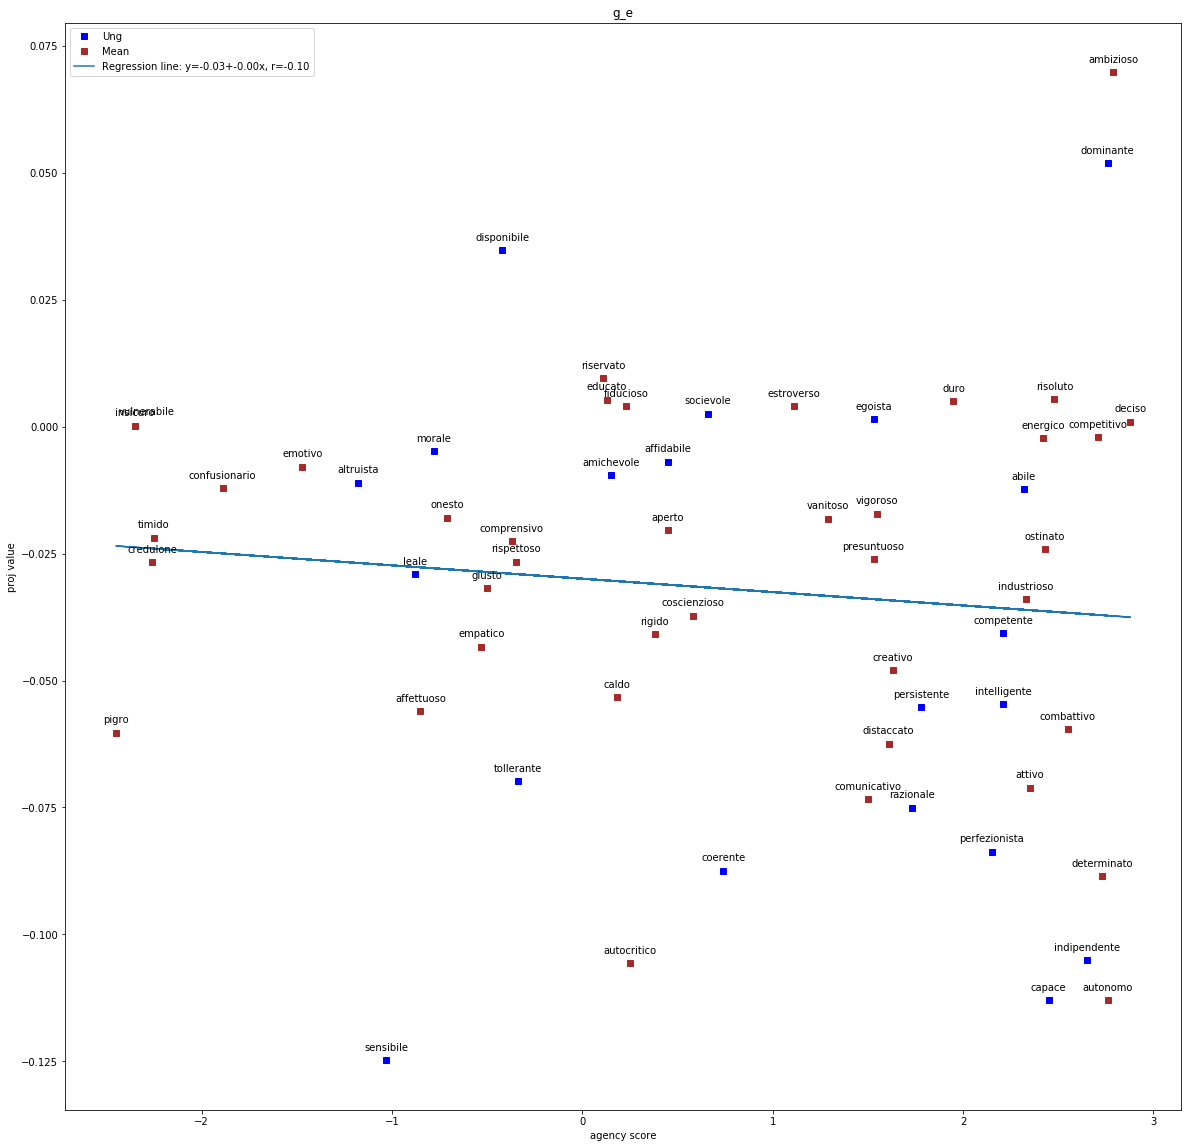

In [98]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_g_e')

In [99]:
# communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[1]

In [100]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion mean correlation")
pearson_table

Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.132136 -0.143680 -0.301581 -0.094172
p  0.314219  0.273419  0.019196  0.474178

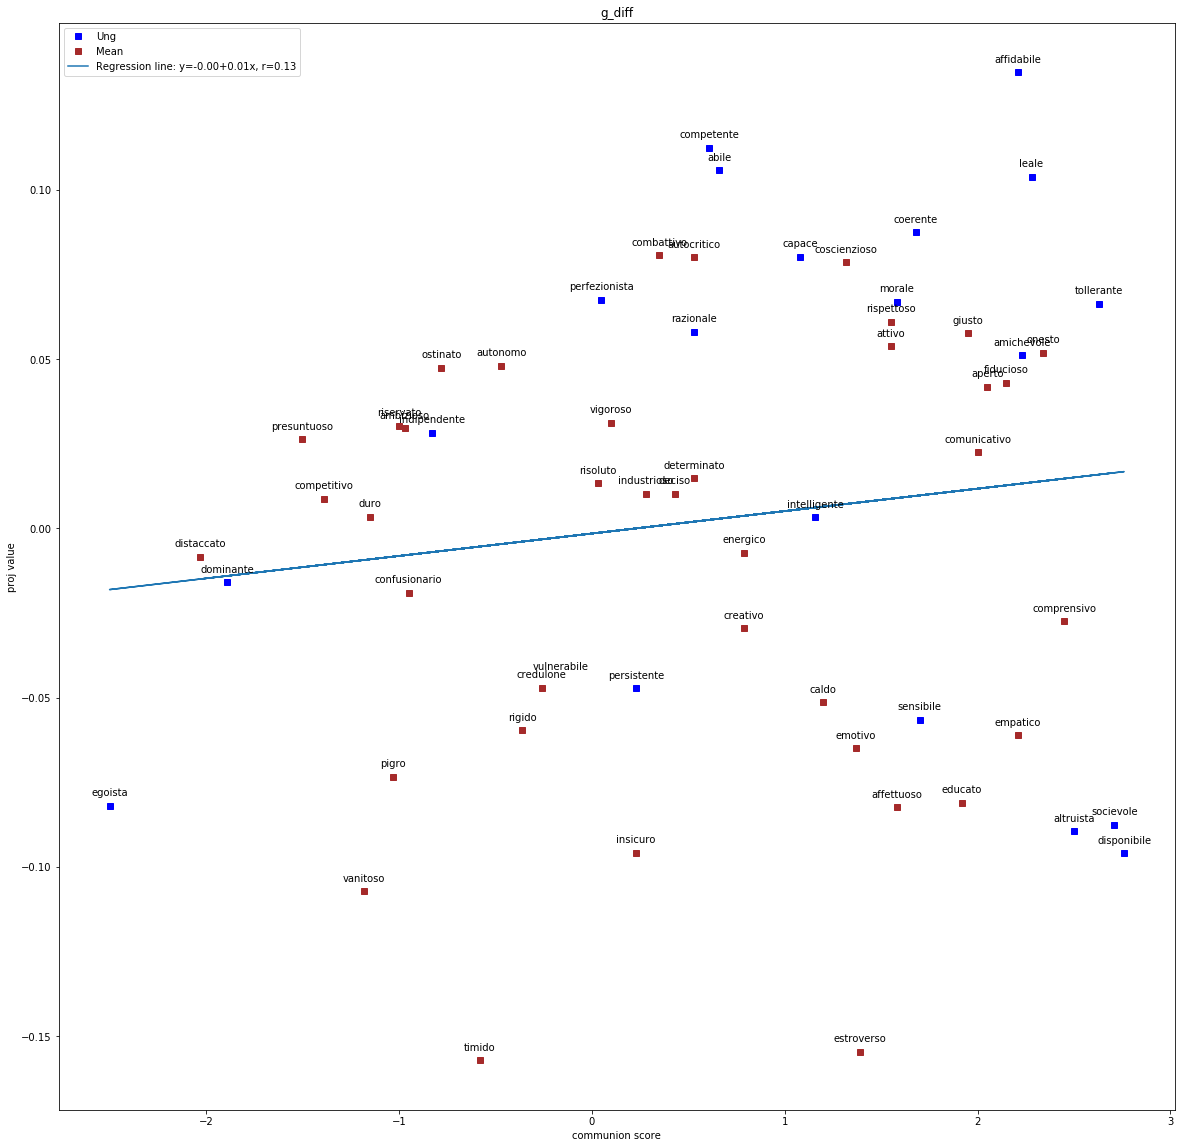

In [101]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_diff')

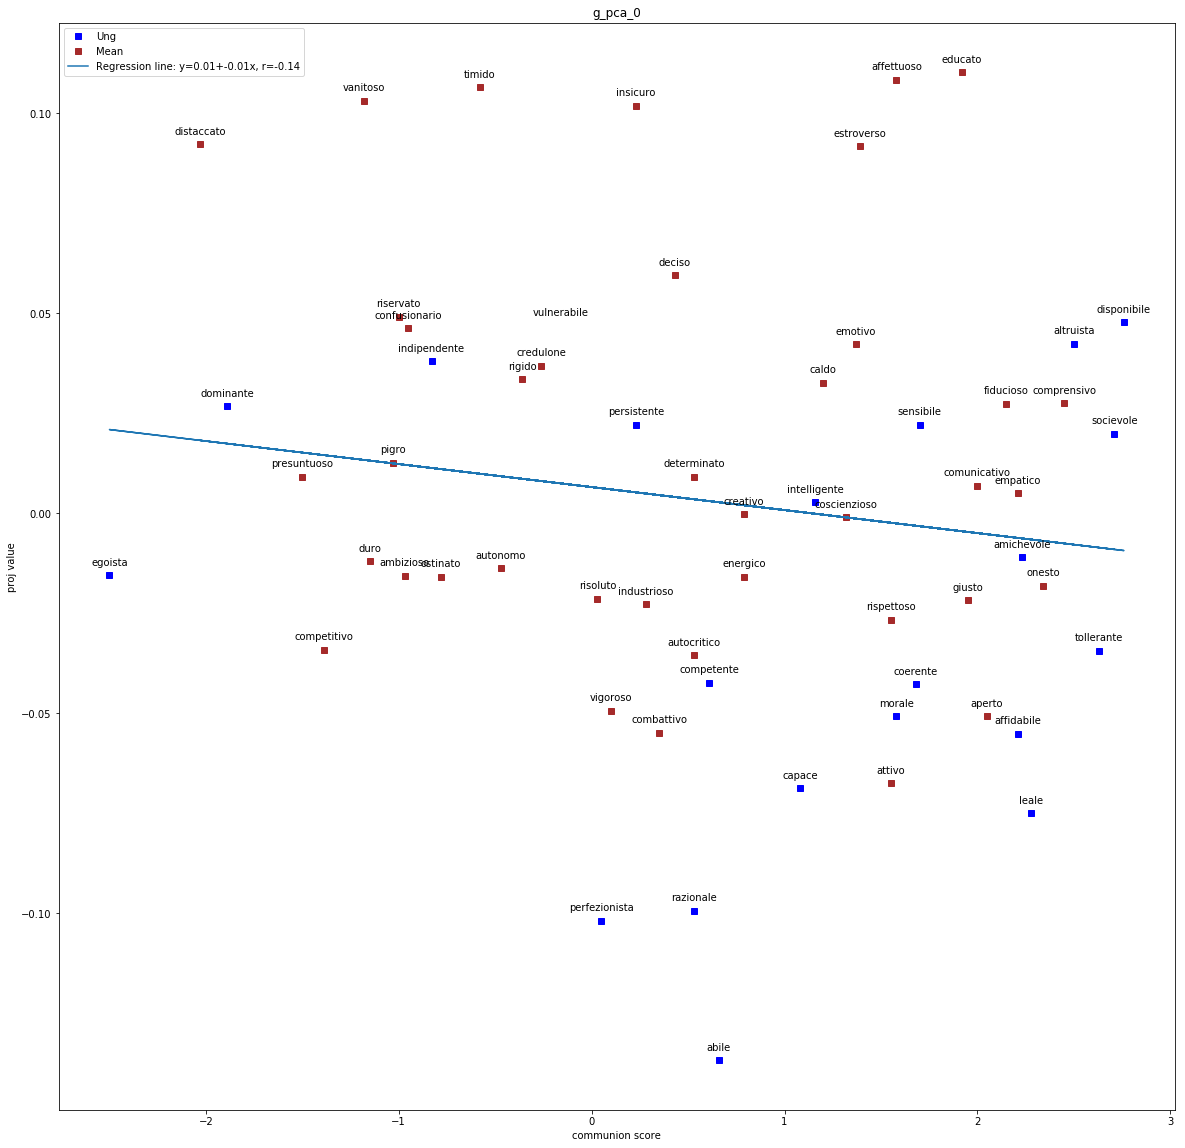

In [102]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
fig.savefig('corr-plot/mean/com/ft_g_pca_0')

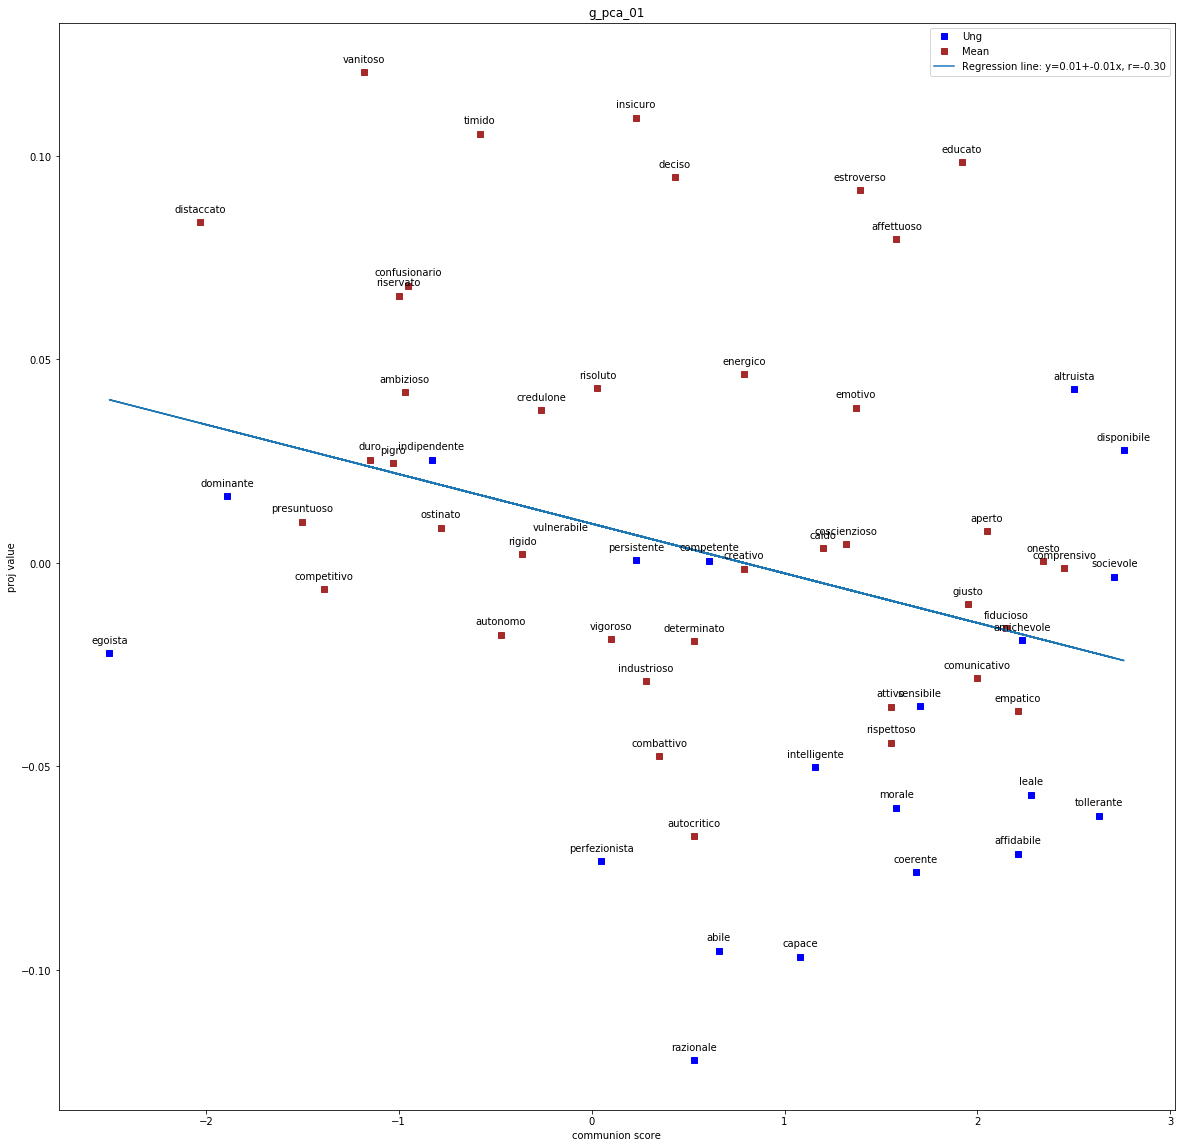

In [103]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_g_pca_01')

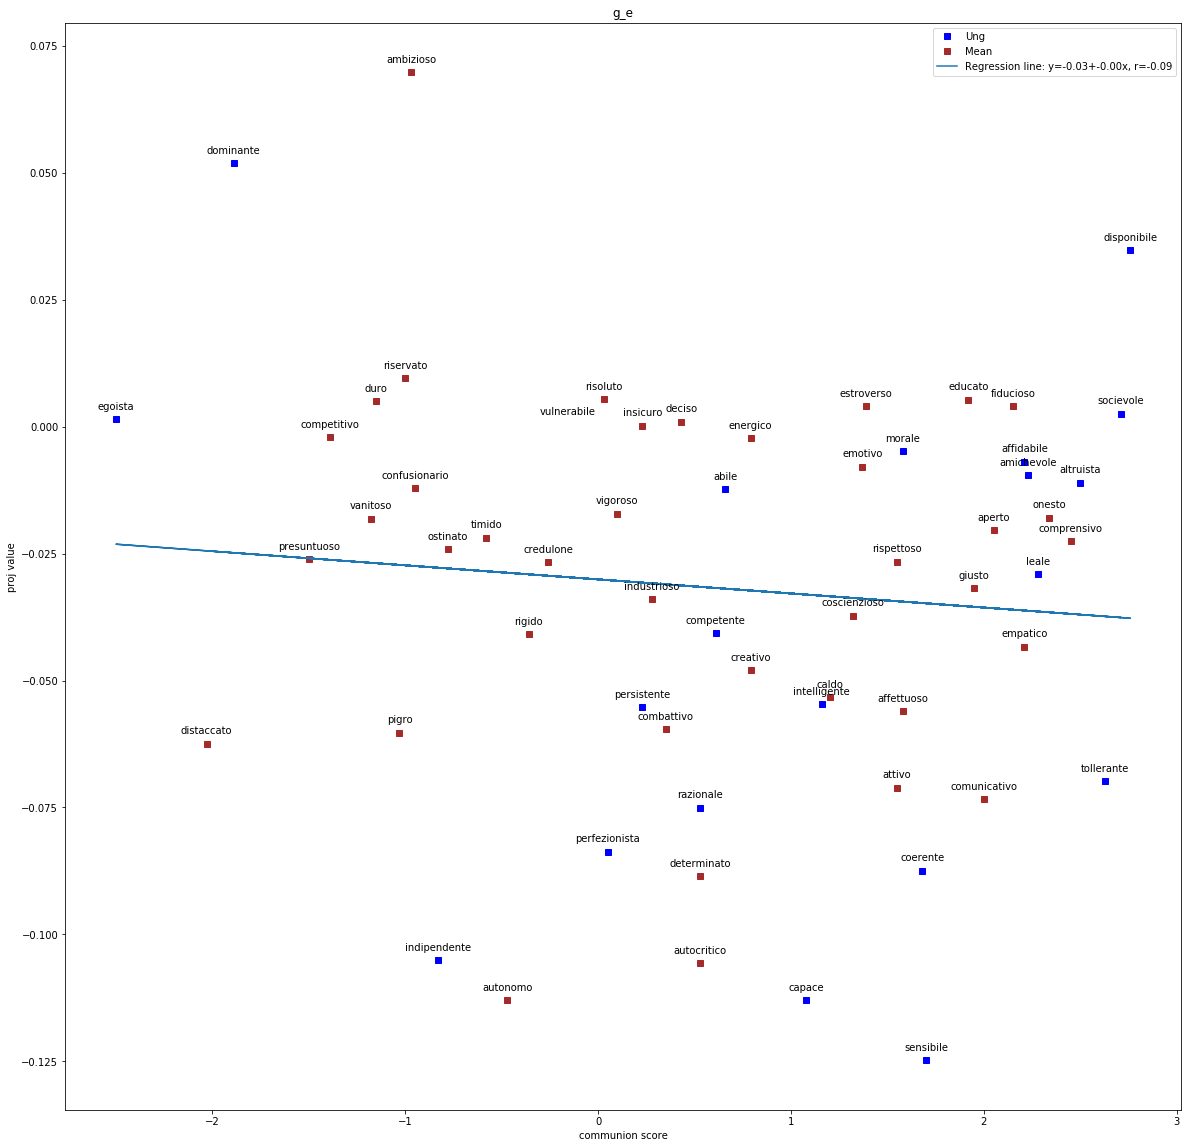

In [104]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_g_e')

In [105]:
# agency-communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[1]

In [106]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion mean correlation")
pearson_table

Agency-Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.181953 -0.174359  0.022026 -0.016024
p  0.164103  0.182729  0.867336  0.903279

#### Step 2.6: subtracting grammatical gender to the emdeddings

In [107]:
from debiaswe.debias import debias

In [108]:
debias(E_ft, [], G_word, [])

425 words of dimension 300 : sua, suo, prima, italiano, ..., agrotecnico, credulona, calzolaia, supportivo
set()
425 words of dimension 300 : sua, suo, prima, italiano, ..., agrotecnico, credulona, calzolaia, supportivo


In [109]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [110]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [111]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [112]:
print("Singular values:")
print(sv)

Singular values:
[7.2583288e-01 4.8852363e-01 3.9915085e-01 3.5123977e-01 3.3286557e-01
 2.6009700e-01 7.1481601e-08 5.7407664e-08 4.5535760e-08 4.1550784e-08]


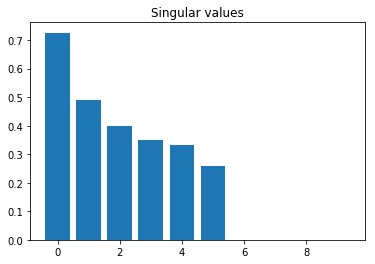

In [113]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [114]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [115]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [116]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [117]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [118]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

In [119]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [120]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [121]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.091597      0.110417       0.067487  0.049583    2.32   
1       altruista    -0.096017     -0.061087      -0.054242  0.055994   -1.18   
2          capace     0.069480      0.049053       0.081890 -0.046876    2.45   
3      competente     0.105852      0.023342      -0.019695 -0.046294    2.21   
4        coerente     0.087345      0.043290       0.076583  0.085887    0.74   
5       dominante     0.000686      0.004070       0.006493  0.001854    2.76   
6      amichevole     0.054774      0.016603       0.022392 -0.062945    0.15   
7     disponibile    -0.103989     -0.064604      -0.035838  0.015749   -0.42   
8         egoista    -0.089678     -0.000278       0.011172  0.050072    1.53   
9    indipendente     0.042854     -0.013392      -0.006820 -0.058949    2.65   
10   intelligente     0.000021     -0.010615       0.047941  0.061769    2.21   
11          leale     0.091348      0.046515       0.031960  0.052940   -0.88   
12         morale     0.070576      0.058312       0.063676  0.043761   -0.78   
13  perfezionista     0.055634      0.079325       0.051034  0.103683    2.15   
14    persistente    -0.053203     -0.035145      -0.007172 -0.013441    1.78   
15      razionale     0.060427      0.110305       0.127538  0.049853    1.73   
16     affidabile     0.129393      0.043327       0.061338  0.024746    0.45   
17      sensibile    -0.060588     -0.029601       0.035141  0.060938   -1.03   
18      socievole    -0.096330     -0.039105      -0.007269  0.016870    0.66   
19     tollerante     0.063575      0.028879       0.058773  0.051808   -0.34   
20    vulnerabile    -0.047585     -0.055561      -0.006657 -0.001714   -2.29   

    Communion  
0        0.66  
1        2.50  
2        1.08  
3        0.61  
4        1.68  
5       -1.89  
6        2.23  
7        2.76  
8       -2.50  
9       -0.83  
10       1.16  
11       2.28  
12       1.58  
13       0.05  
14       0.23  
15       0.53  
16       2.21  
17       1.70  
18       2.71  
19       2.63  
20      -0.16

In [122]:
# ag_com_ung pearson correlation
# agency correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col5, ag_com_ung_col4)[1]

In [123]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency ungendered correlation")
pearson_table

Agency ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.284944  0.393634  0.229702 -0.212796
p  0.210579  0.077483  0.316514  0.354388

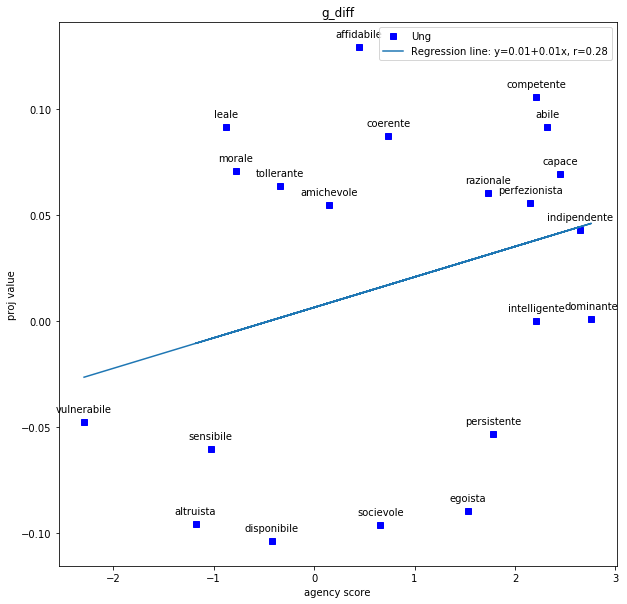

In [124]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_deb_g_diff')

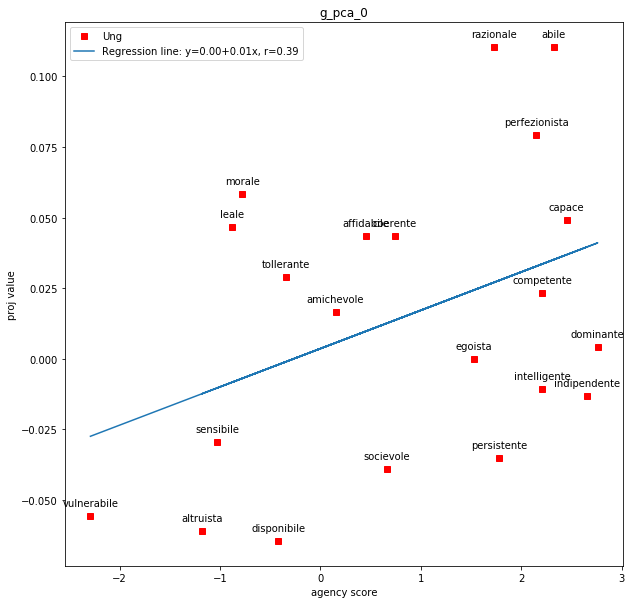

In [125]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_deb_g_pca_0')

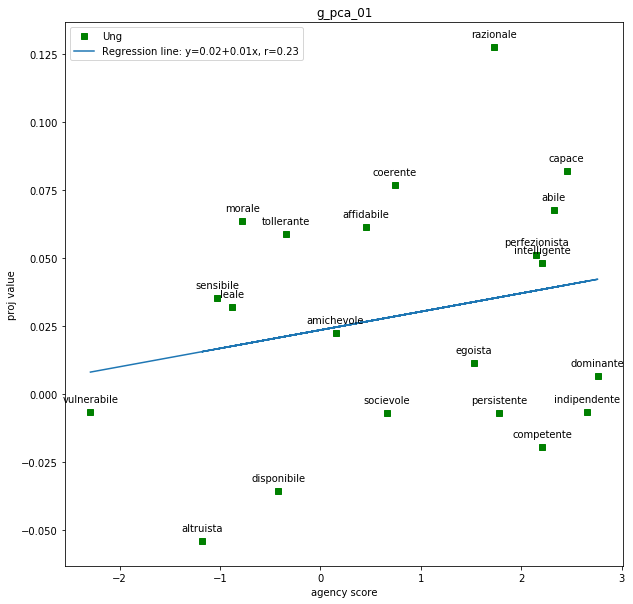

In [126]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_deb_g_pca_01')

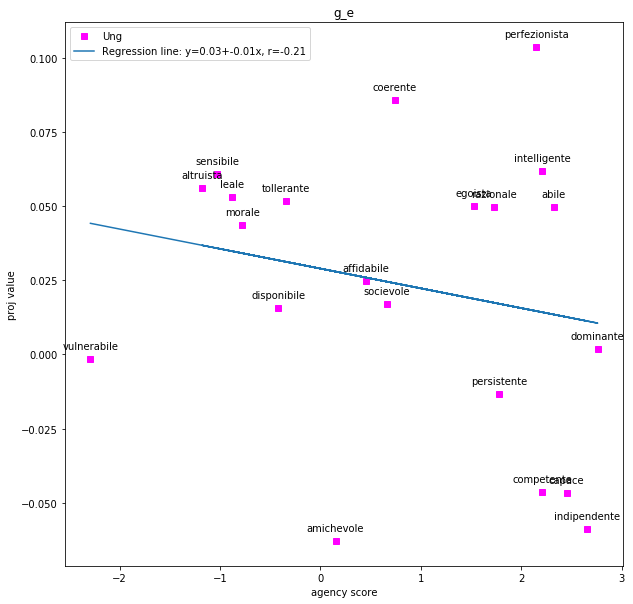

In [127]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col5, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col5, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col5), intercept + slope * np.array(ag_com_ung_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col5[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/ag/ft_deb_g_e')

In [128]:
# communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(ag_com_ung_col6, ag_com_ung_col4)[1]

In [129]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion ungendered correlation")
pearson_table

Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.082773 -0.077178  0.035637  0.135795
p  0.721315  0.739500  0.878116  0.557261

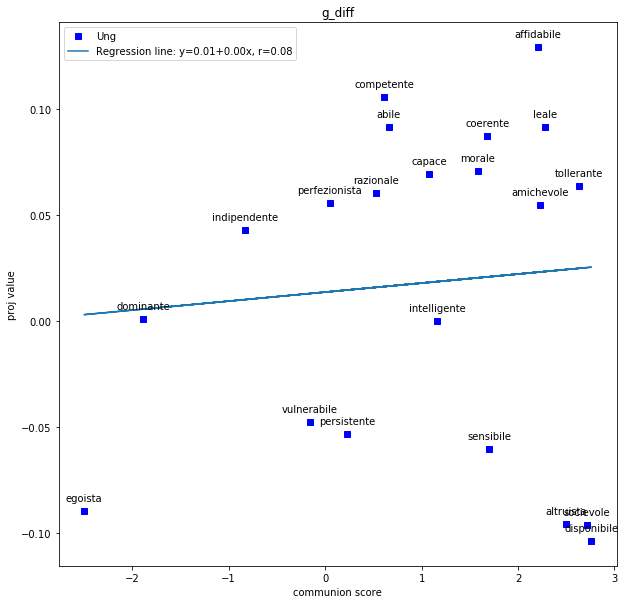

In [130]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col1, linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_deb_g_diff')

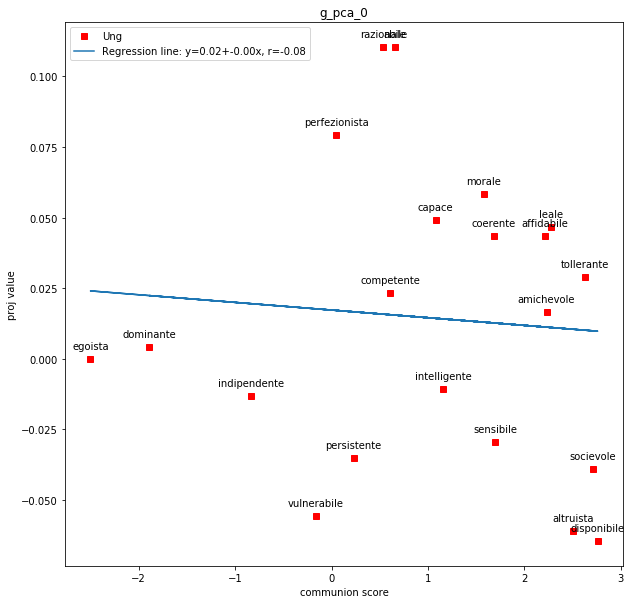

In [131]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col2, linewidth=0, marker='s', color='red', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_deb_g_pca_0')

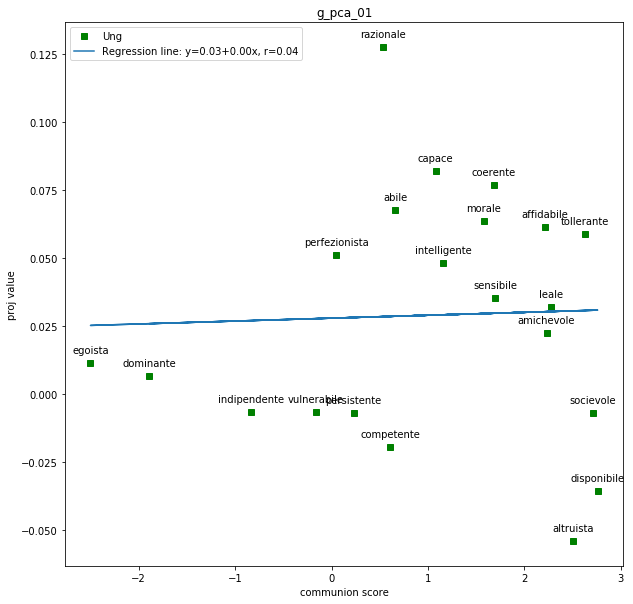

In [132]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col3, linewidth=0, marker='s', color='green', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_deb_g_pca_01')

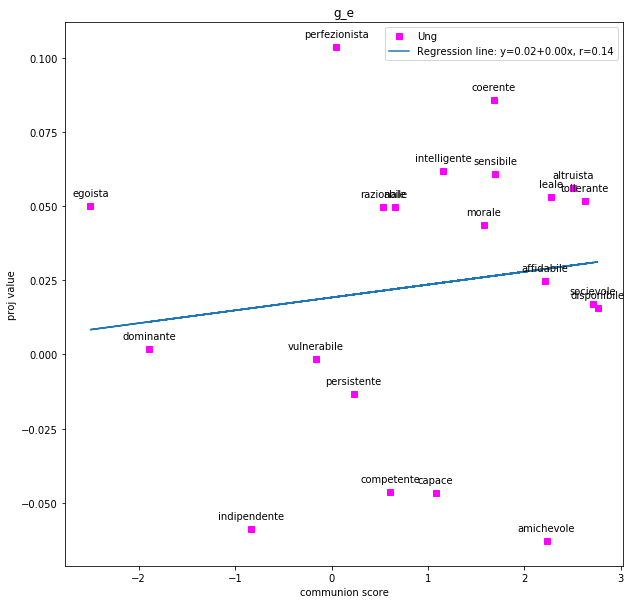

In [133]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_ung_col6, ag_com_ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_ung_col6, ag_com_ung_col4, linewidth=0, marker='s', color='magenta', label='Ung')
ax.plot(np.array(ag_com_ung_col6), intercept + slope * np.array(ag_com_ung_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_ung_col0):
    plt.annotate(label, # this is the text
                 (ag_com_ung_col6[i], ag_com_ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/ung/com/ft_deb_g_e')

In [134]:
# agency-communion correlation
r_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[0]
r_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[0]
r_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[0]
r_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[0]
p_ag_com_ung_g_diff = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col1)[1]
p_ag_com_ung_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col2)[1]
p_ag_com_ung_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col3)[1]
p_ag_com_ung_g_e = scipy.stats.pearsonr(np.array(ag_com_ung_col5)-np.array(ag_com_ung_col6), ag_com_ung_col4)[1]

In [135]:
pearson_data = {'g_diff':[r_ag_com_ung_g_diff,p_ag_com_ung_g_diff],
                'g_pca_0':[r_ag_com_ung_g_pca_0,p_ag_com_ung_g_pca_0],
                'g_pca_01':[r_ag_com_ung_g_pca_01,p_ag_com_ung_g_pca_01],
                'g_e':[r_ag_com_ung_g_e,p_ag_com_ung_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion ungendered correlation")
pearson_table

Agency-Communion ungendered correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.117537  0.270634  0.112324 -0.199479
p  0.611870  0.235401  0.627853  0.385989

##### Gendered words

In [136]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [137]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [138]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attivo     0.106643      0.106760       0.068515 -0.081389    2.35   
1      affettuoso    -0.095857     -0.143509      -0.089669  0.001237   -0.85   
2       ambizioso     0.077781      0.086066       0.019502 -0.019807    2.79   
3          deciso     0.020371     -0.029103      -0.065776 -0.044848    2.88   
4        vanitoso    -0.060925     -0.066567      -0.069075  0.023809    1.29   
5   confusionario    -0.011735     -0.021402      -0.053127 -0.045959   -1.89   
6    comunicativo     0.008972     -0.028733       0.021718  0.029668    1.50   
7     competitivo     0.005824      0.036513       0.026547 -0.022337    2.71   
8     presuntuoso     0.040173     -0.012222      -0.008203  0.048774    1.53   
9    coscienzioso     0.101009      0.017462       0.011324  0.009806    0.58   
10     rispettoso     0.064831      0.051287       0.069426  0.050109   -0.35   
11       creativo    -0.053798     -0.041574      -0.030098 -0.017617    1.63   
12     distaccato     0.019722     -0.053916      -0.048379 -0.005894    1.61   
13    determinato     0.041673      0.021000       0.060830 -0.037571    2.73   
14         rigido    -0.045736     -0.022624       0.048973  0.065116    0.38   
15        emotivo    -0.089888     -0.094859      -0.082995 -0.025865   -1.47   
16       energico     0.055354      0.092757       0.031712  0.011806    2.42   
17         giusto     0.032882      0.001316      -0.013873  0.046032   -0.50   
18      credulone    -0.012138      0.014462       0.011437  0.085299   -2.26   
19           duro     0.020993      0.010329      -0.033423  0.053375    1.95   
20         onesto     0.088046      0.080193       0.071951  0.067374   -0.71   
21    industrioso     0.010649      0.041643       0.052605  0.021096    2.33   
22       insicuro    -0.048056     -0.055188      -0.067281 -0.070156   -2.35   
23          pigro     0.002307      0.087582       0.061675  0.053490   -2.45   
24       ostinato     0.055985      0.038192       0.024022  0.036307    2.43   
25         aperto     0.010969      0.036359      -0.001815 -0.123499    0.45   
26     estroverso    -0.138997     -0.077824      -0.064442  0.015843    1.11   
27        educato    -0.008957      0.012341       0.005039 -0.016295    0.13   
28      riservato     0.012601     -0.084650      -0.075461 -0.014113    0.11   
29    autocritico     0.060977      0.024536       0.072395 -0.018992    0.25   
30       autonomo     0.032701     -0.002410      -0.005225 -0.032096    2.76   
31         timido    -0.092542     -0.026044      -0.021974 -0.013814   -2.25   
32     combattivo     0.124401      0.091814       0.071985  0.040573    2.55   
33       risoluto     0.025668      0.036776      -0.040184  0.069130    2.48   
34     supportivo    -0.002695     -0.032834      -0.004680  0.028949   -0.27   
35       empatico    -0.036564      0.032758       0.084822 -0.036094   -0.53   
36      fiducioso     0.104722      0.038147       0.065946 -0.009794    0.23   
37    comprensivo    -0.032772     -0.036948       0.000778  0.029099   -0.37   
38       vigoroso     0.016857      0.009659      -0.011809 -0.013240    1.55   
39          caldo    -0.033107     -0.002915       0.014830  0.019056    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       1.87  
35       2.21  
36       2.15  
37       2.45  
38       0.10  
39       1.20

In [139]:
# ag_com_gen_m pearson correlation
# agency correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col5, ag_com_gen_m_col4)[1]

In [140]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency male correlation")
pearson_table

Agency male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.418684  0.289802  0.134129 -0.070489
p  0.007171  0.069693  0.409290  0.665587

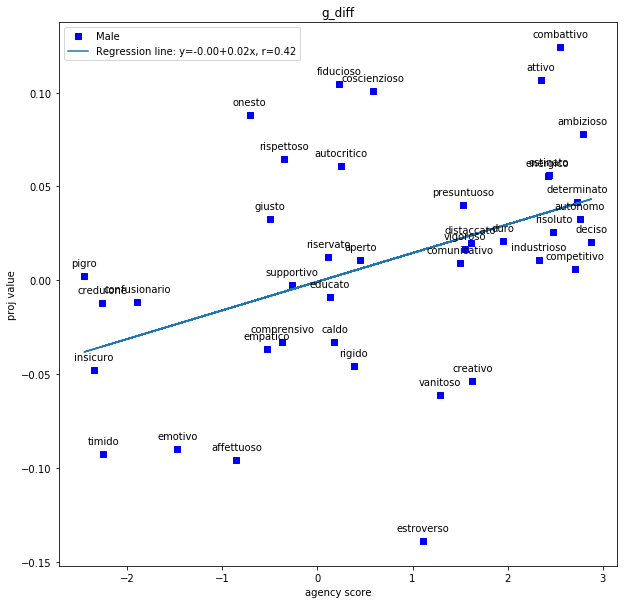

In [141]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_deb_g_diff')

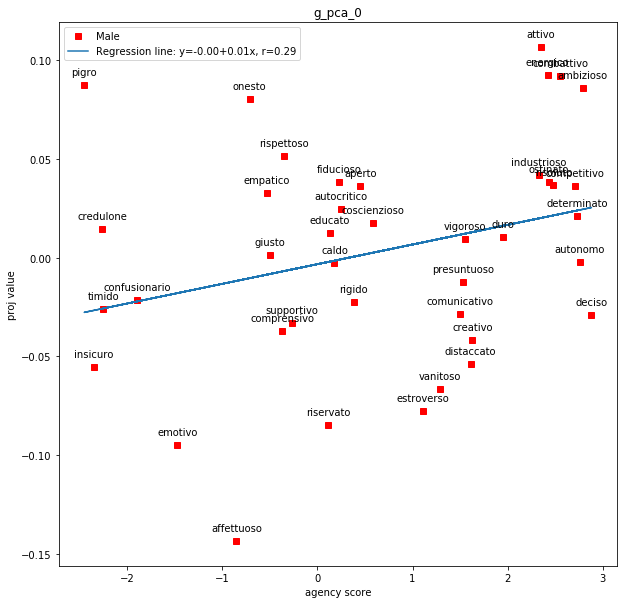

In [142]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_deb_g_pca_0')

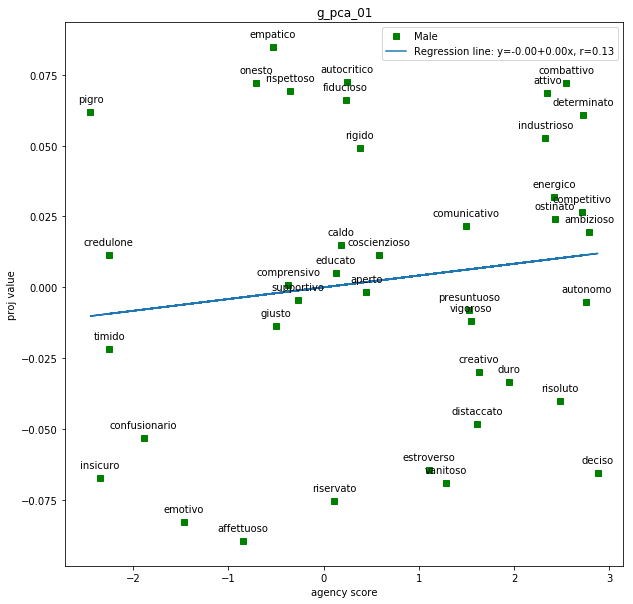

In [143]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distaance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_deb_g_pca_01')

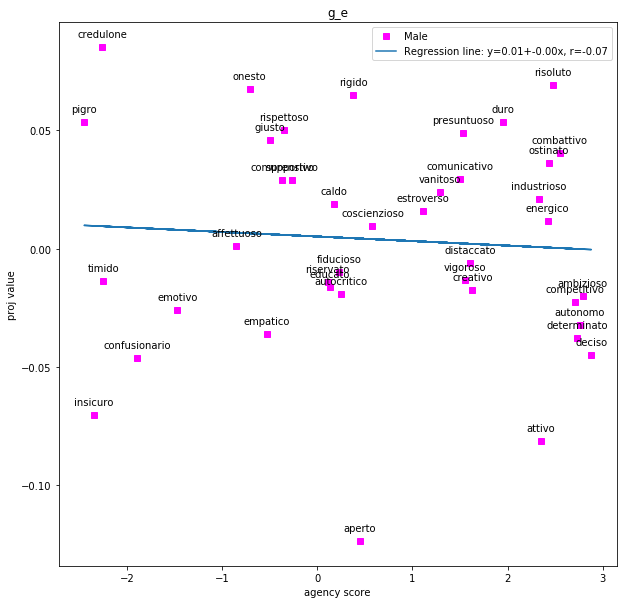

In [144]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col5, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col5), intercept + slope * np.array(ag_com_gen_m_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/ag/ft_deb_g_e')

In [145]:
# communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(ag_com_gen_m_col6, ag_com_gen_m_col4)[1]

In [146]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion male correlation")
pearson_table

Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.012696  0.042304  0.252917 -0.112263
p  0.938026  0.795490  0.115352  0.490391

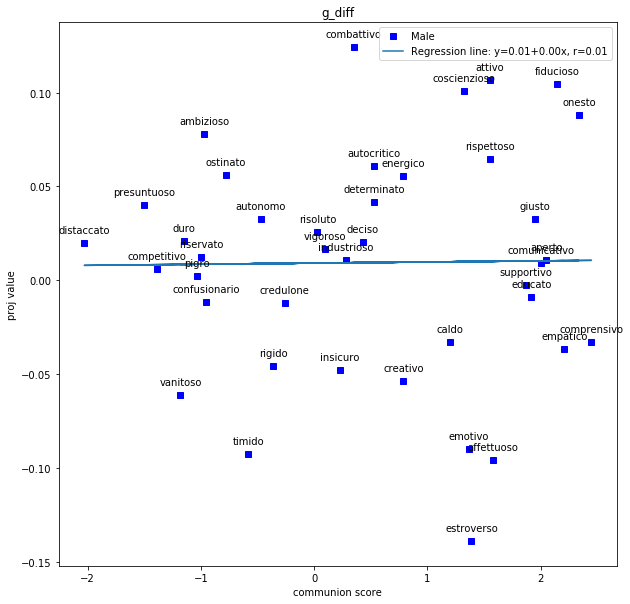

In [147]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_deb_g_diff')

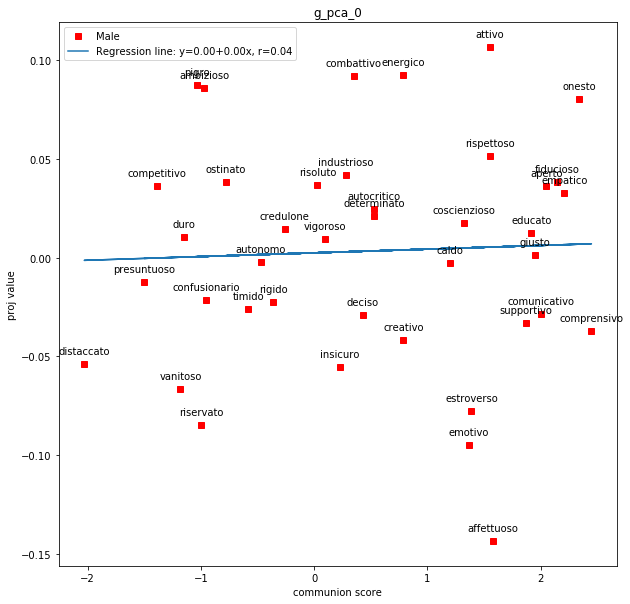

In [148]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='red', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_deb_g_pca_0')

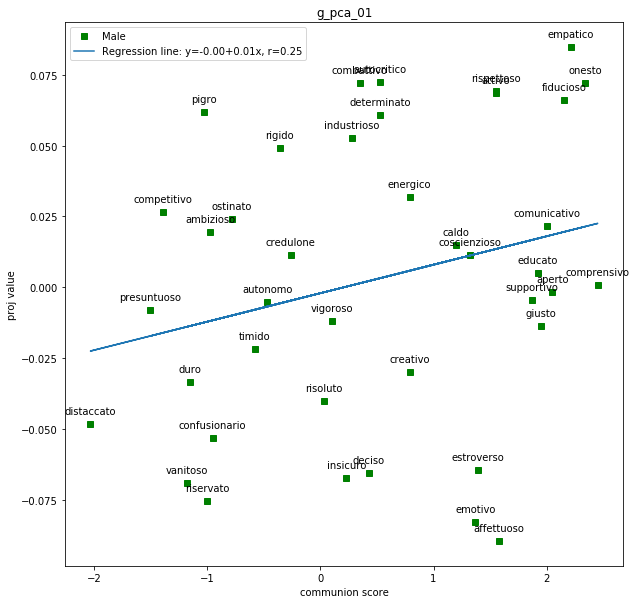

In [149]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='green', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distaance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_deb_g_pca_01')

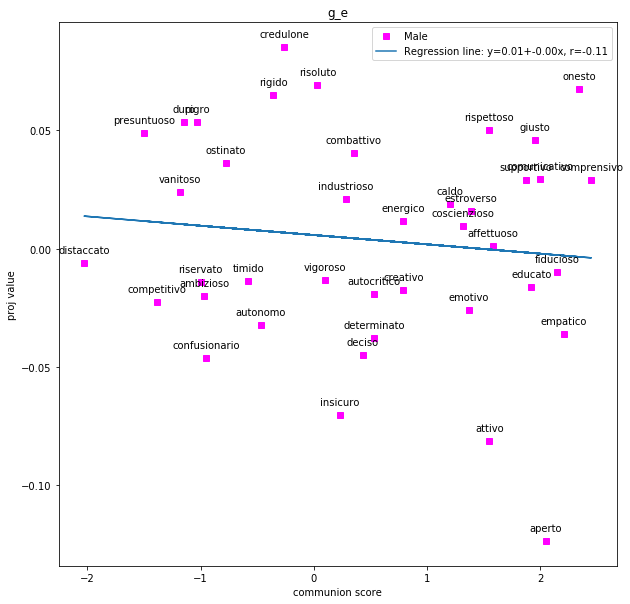

In [150]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_m_col6, ag_com_gen_m_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='magenta', label='Male')
ax.plot(np.array(ag_com_gen_m_col6), intercept + slope * np.array(ag_com_gen_m_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-m/com/ft_deb_g_e')

In [151]:
# agency-communion correlation
r_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[0]
r_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[0]
r_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[0]
r_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[0]
p_ag_com_gen_m_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col1)[1]
p_ag_com_gen_m_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col2)[1]
p_ag_com_gen_m_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col3)[1]
p_ag_com_gen_m_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_m_col5)-np.array(ag_com_gen_m_col6), ag_com_gen_m_col4)[1]

In [152]:
pearson_data = {'g_diff':[r_ag_com_gen_m_g_diff,p_ag_com_gen_m_g_diff],
                'g_pca_0':[r_ag_com_gen_m_g_pca_0,p_ag_com_gen_m_g_pca_0],
                'g_pca_01':[r_ag_com_gen_m_g_pca_01,p_ag_com_gen_m_g_pca_01],
                'g_e':[r_ag_com_gen_m_g_e,p_ag_com_gen_m_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion male correlation")
pearson_table

Agency-Communion male correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.294617  0.185151 -0.045016  0.012088
p  0.064974  0.252711  0.782688  0.940985

In [153]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0          attiva     0.011923      0.052332       0.007459 -0.063697    2.35   
1      affettuosa    -0.075808     -0.107505      -0.080533  0.013838   -0.85   
2       ambiziosa     0.002107     -0.026248      -0.100431  0.026831    2.79   
3          decisa     0.049625     -0.013272      -0.075387 -0.028183    2.88   
4        vanitosa    -0.153471     -0.156963      -0.182015  0.027865    1.29   
5   confusionaria    -0.022447     -0.078296      -0.089675 -0.022462   -1.89   
6    comunicativa     0.049139      0.036093       0.056553  0.035137    1.50   
7     competitiva     0.003590      0.015638      -0.032490 -0.002047    2.71   
8     presuntuosa    -0.004978     -0.058819      -0.049813  0.076687    1.53   
9    coscienziosa     0.071868     -0.003137      -0.016539  0.027106    0.58   
10     rispettosa     0.071941      0.022354       0.034247  0.093207   -0.35   
11       creativa     0.002372      0.057905       0.044051 -0.039744    1.63   
12     distaccata    -0.016350     -0.114144      -0.099821 -0.025648    1.61   
13    determinata     0.005682     -0.010033       0.003268 -0.002463    2.73   
14         rigida    -0.048449      0.010377      -0.007501  0.120235    0.38   
15        emotiva    -0.035167      0.012889       0.012635 -0.046600   -1.47   
16       energica    -0.064517     -0.059231      -0.138391  0.032341    2.42   
17         giusta     0.103298      0.074683       0.051292  0.046032   -0.50   
18      credulona    -0.092065     -0.119193      -0.105511  0.065698   -2.26   
19           dura    -0.025170     -0.016034      -0.046751  0.053375    1.95   
20         onesta     0.019494     -0.051748      -0.085183  0.098465   -0.71   
21    industriosa     0.031218      0.049595       0.034941  0.021198    2.33   
22       insicura    -0.134479     -0.149309      -0.145989 -0.069831   -2.35   
23          pigra    -0.144397     -0.100410      -0.104072  0.007046   -2.45   
24       ostinata     0.059638      0.021165      -0.029967  0.050504    2.43   
25         aperta     0.081651      0.077901      -0.019318 -0.086490    0.45   
26     estroversa    -0.175976     -0.125162      -0.125339  0.038132    1.11   
27        educata    -0.133849     -0.214134      -0.179038  0.033303    0.13   
28      riservata     0.056460     -0.021155      -0.062966  0.018862    0.11   
29    autocritica     0.091228      0.027564       0.050285 -0.001978    0.25   
30       autonoma     0.074301      0.045569       0.050425 -0.030505    2.76   
31         timida    -0.229897     -0.209761      -0.197462  0.026873   -2.25   
32     combattiva     0.049277      0.038116       0.029972  0.057559    2.55   
33       risoluta    -0.000897     -0.011380      -0.072728  0.071842    2.48   
34       empatica    -0.086448     -0.035279       0.001743 -0.039606   -0.53   
35      fiduciosa     0.016781     -0.031598       0.017467  0.008442    0.23   
36    comprensiva    -0.010728      0.000103       0.023384  0.064215   -0.37   
37       vigorosa     0.050834      0.098207       0.044726  0.007053    1.55   
38          calda    -0.053237     -0.029063       0.008633  0.019056    0.18   

    Communion  
0        1.55  
1        1.58  
2       -0.97  
3        0.43  
4       -1.18  
5       -0.95  
6        2.00  
7       -1.39  
8       -1.50  
9        1.32  
10       1.55  
11       0.79  
12      -2.03  
13       0.53  
14      -0.36  
15       1.37  
16       0.79  
17       1.95  
18      -0.26  
19      -1.15  
20       2.34  
21       0.28  
22       0.23  
23      -1.03  
24      -0.78  
25       2.05  
26       1.39  
27       1.92  
28      -1.00  
29       0.53  
30      -0.47  
31      -0.58  
32       0.35  
33       0.03  
34       2.21  
35       2.15  
36       2.45  
37       0.10  
38       1.20

In [154]:
# ag_com_gen_f pearson correlation
# agency correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col5, ag_com_gen_f_col4)[1]

In [155]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency female correlation")
pearson_table

Agency female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.445174  0.457042  0.270369  0.017414
p  0.004514  0.003445  0.095976  0.916200

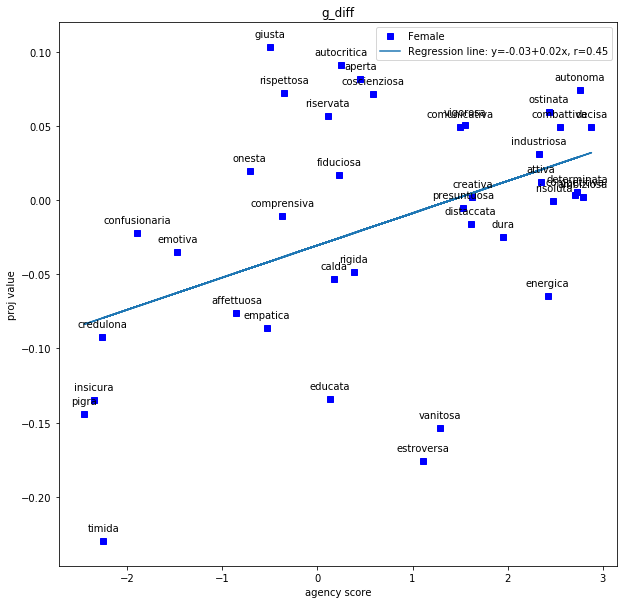

In [156]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_deb_g_diff')

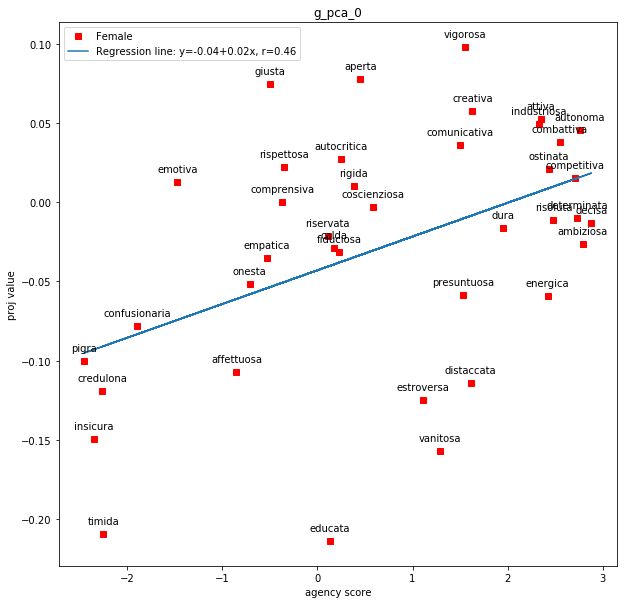

In [157]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_deb_g_pca_0')

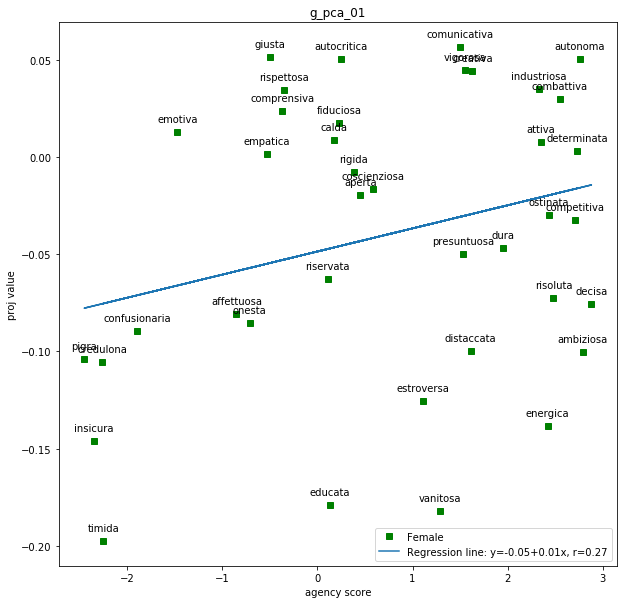

In [158]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_deb_g_pca_01')

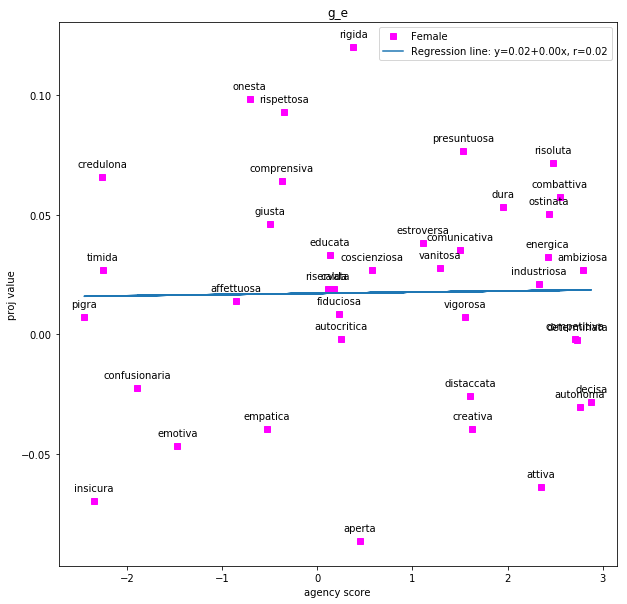

In [159]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col5, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col5), intercept + slope * np.array(ag_com_gen_f_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/ag/ft_deb_g_e')

In [160]:
# communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(ag_com_gen_f_col6, ag_com_gen_f_col4)[1]

In [161]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion female correlation")
pearson_table

Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.145026  0.209337  0.340253 -0.051463
p  0.378379  0.200896  0.034053  0.755696

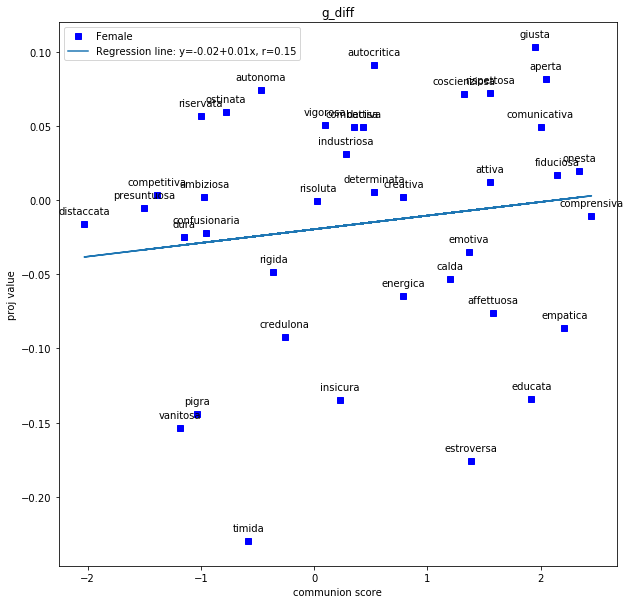

In [162]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='blue', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_deb_g_diff')

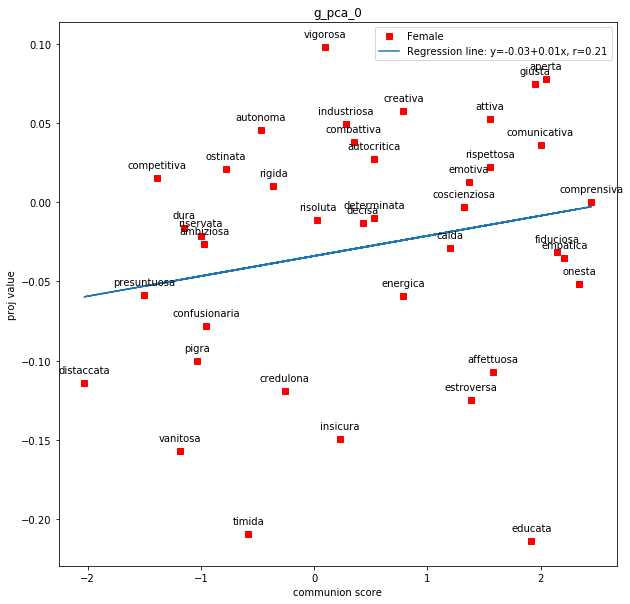

In [163]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='red', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_deb_g_pca_0')

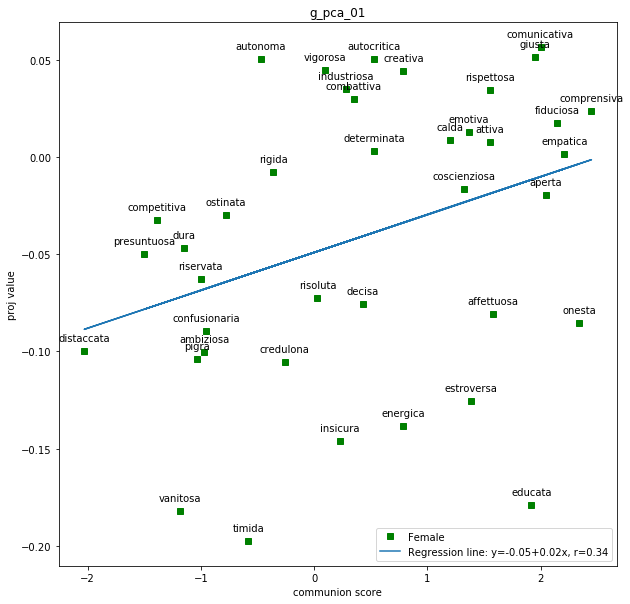

In [164]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='green', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_deb_g_pca_01')

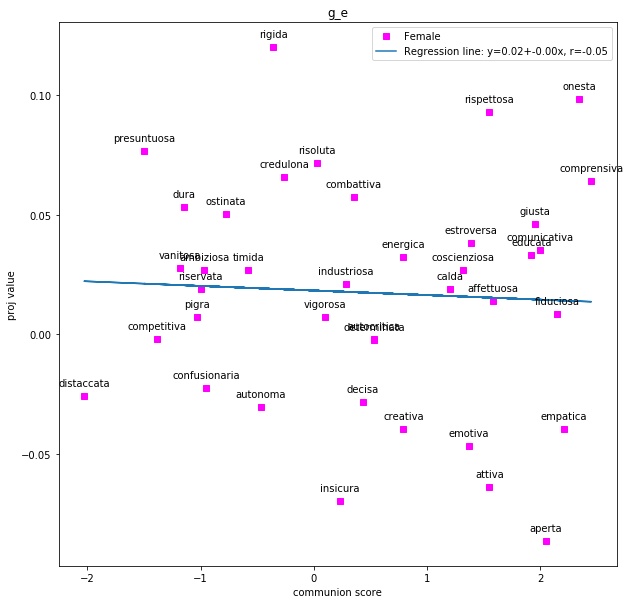

In [165]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_gen_f_col6, ag_com_gen_f_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='magenta', label='Female')
ax.plot(np.array(ag_com_gen_f_col6), intercept + slope * np.array(ag_com_gen_f_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/gen-f/com/ft_deb_g_e')

In [166]:
# agency-communion correlation
r_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[0]
r_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[0]
r_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[0]
r_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[0]
p_ag_com_gen_f_g_diff = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col1)[1]
p_ag_com_gen_f_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col2)[1]
p_ag_com_gen_f_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col3)[1]
p_ag_com_gen_f_g_e = scipy.stats.pearsonr(np.array(ag_com_gen_f_col5)-np.array(ag_com_gen_f_col6), ag_com_gen_f_col4)[1]

In [167]:
pearson_data = {'g_diff':[r_ag_com_gen_f_g_diff,p_ag_com_gen_f_g_diff],
                'g_pca_0':[r_ag_com_gen_f_g_pca_0,p_ag_com_gen_f_g_pca_0],
                'g_pca_01':[r_ag_com_gen_f_g_pca_01,p_ag_com_gen_f_g_pca_01],
                'g_e':[r_ag_com_gen_f_g_e,p_ag_com_gen_f_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion female correlation")
pearson_table

Agency-Communion female correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.242812  0.215490  0.006476  0.041444
p  0.136377  0.187674  0.968790  0.802199

In [168]:
# both male and female agency plot

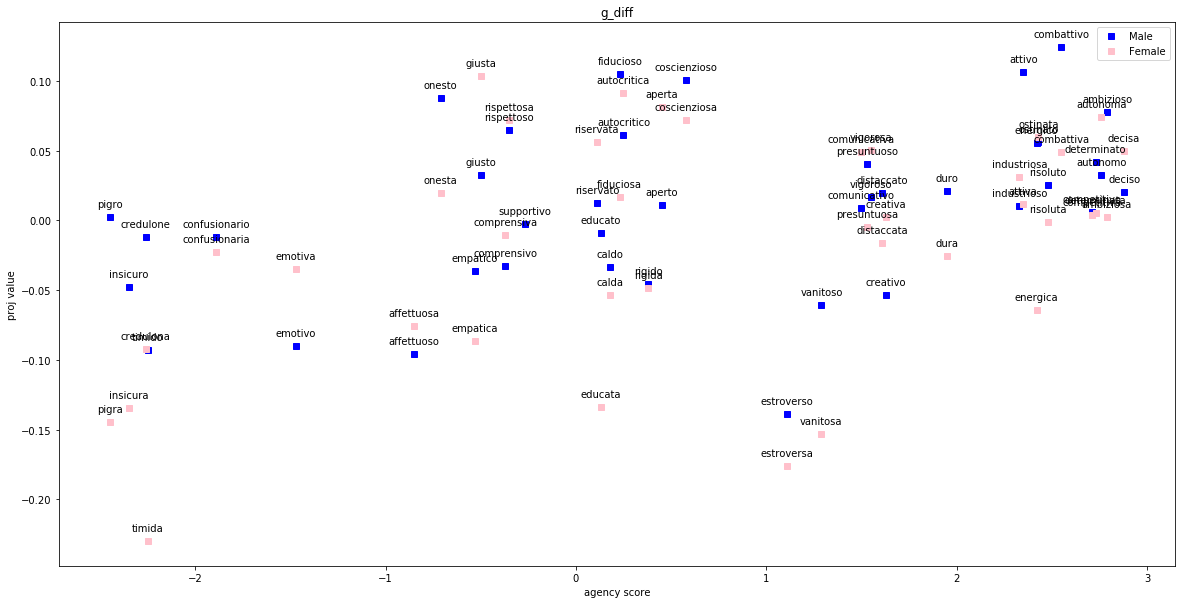

In [169]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_diff')

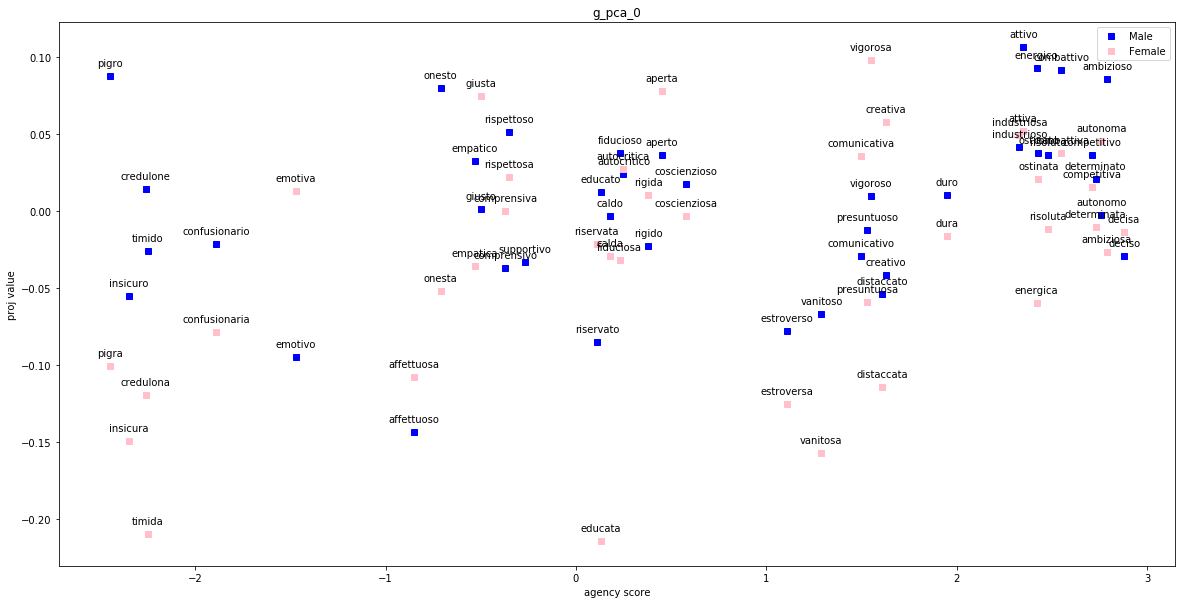

In [170]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_pca_0')

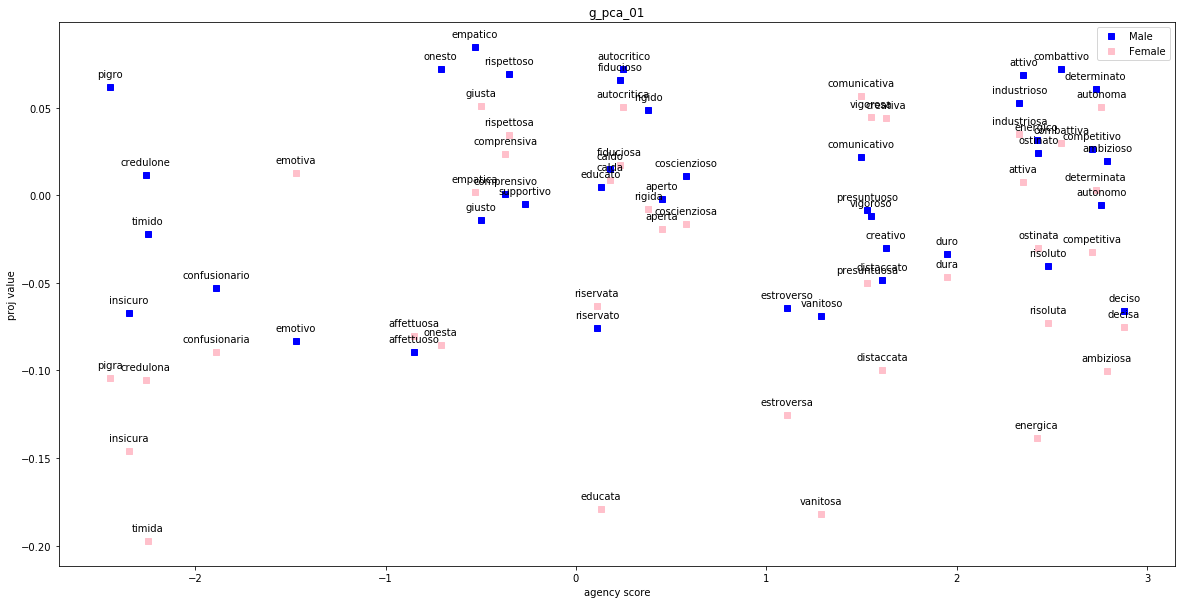

In [171]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_pca_01')

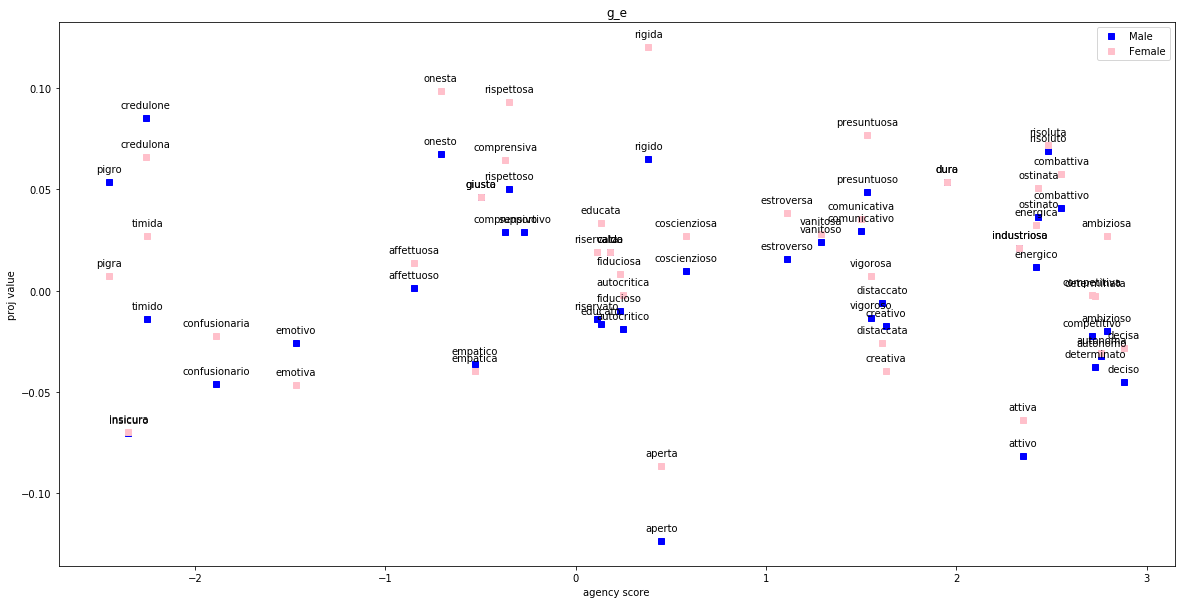

In [172]:
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col5, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col5, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col5[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col5[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/ag/ft_deb_g_e')

In [173]:
# both male and female communion plot

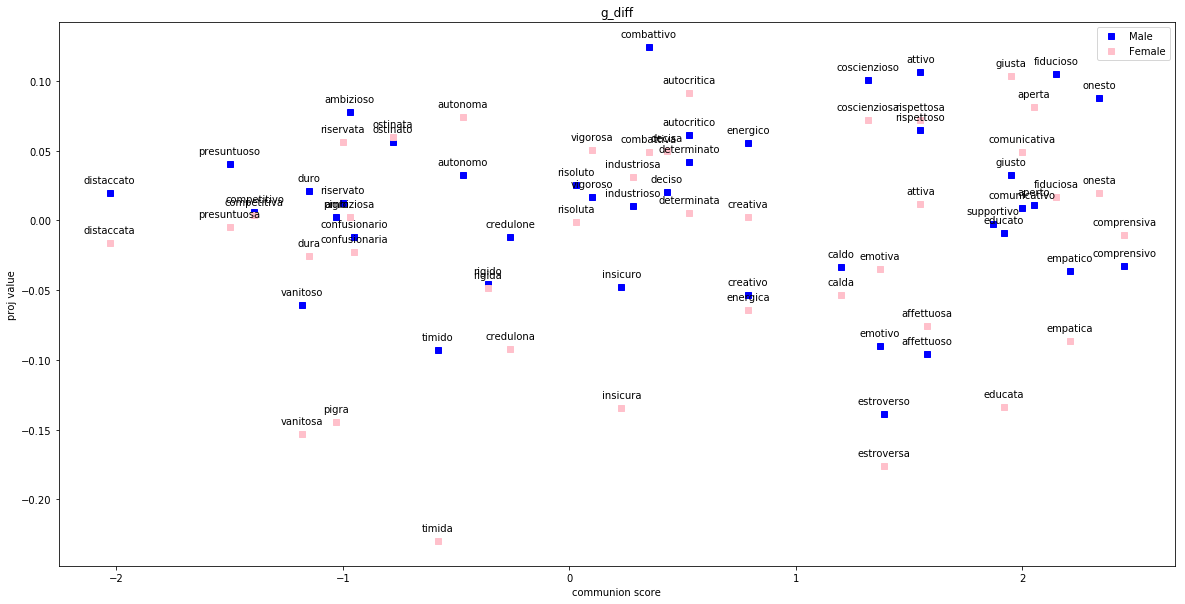

In [174]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col1, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col1, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_deb_g_diff')

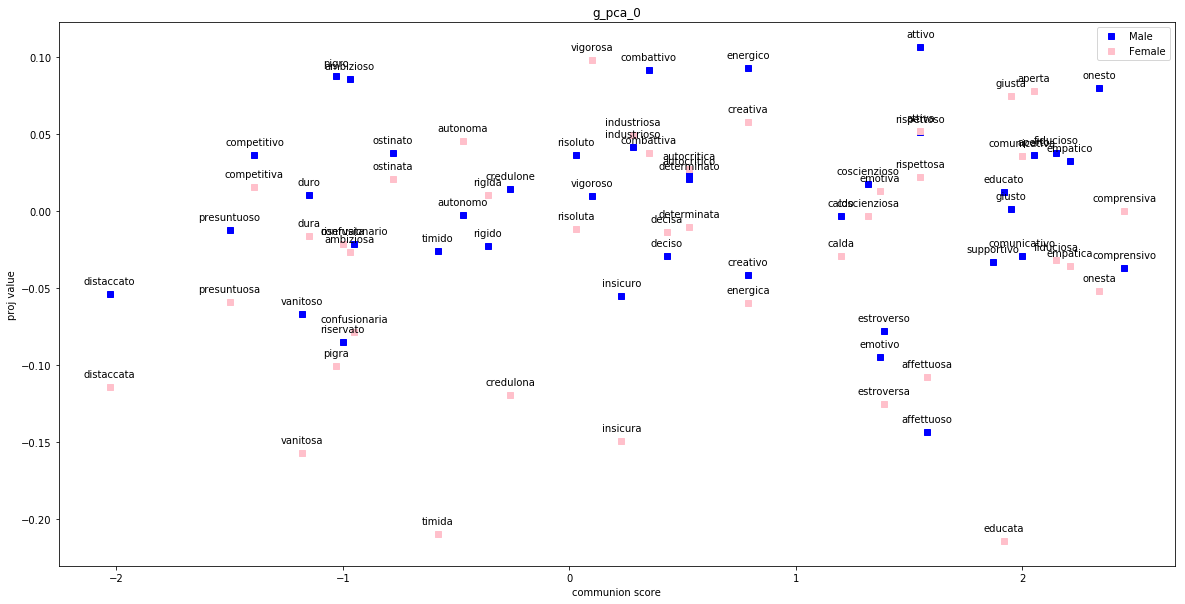

In [175]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col2, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col2, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_deb_g_pca_0')

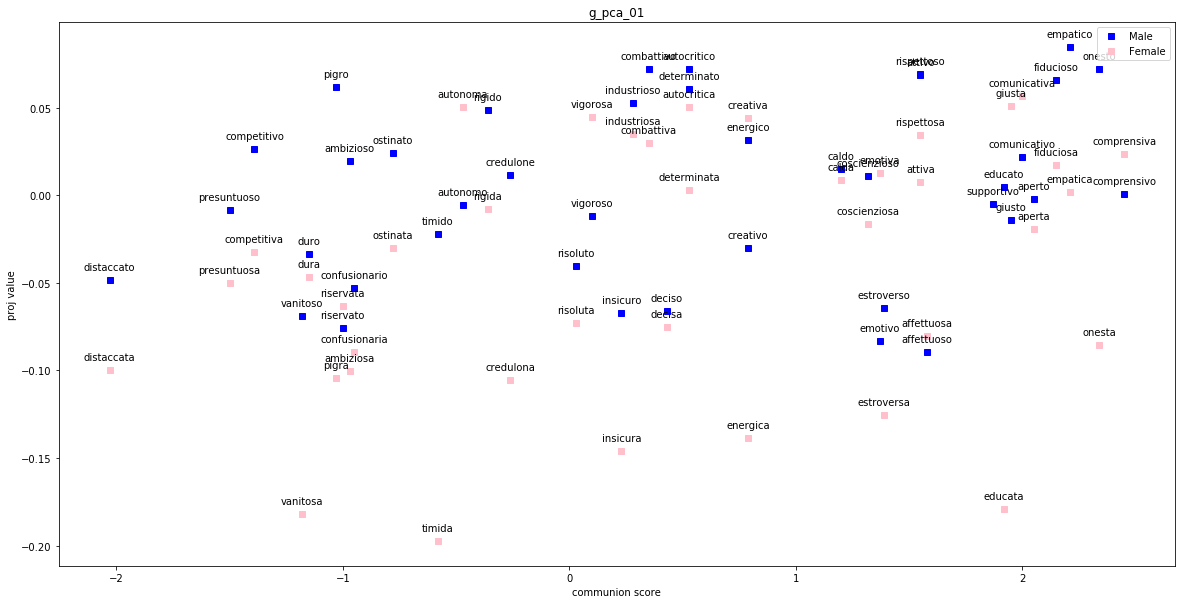

In [176]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col3, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col3, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_deb_g_pca_01')

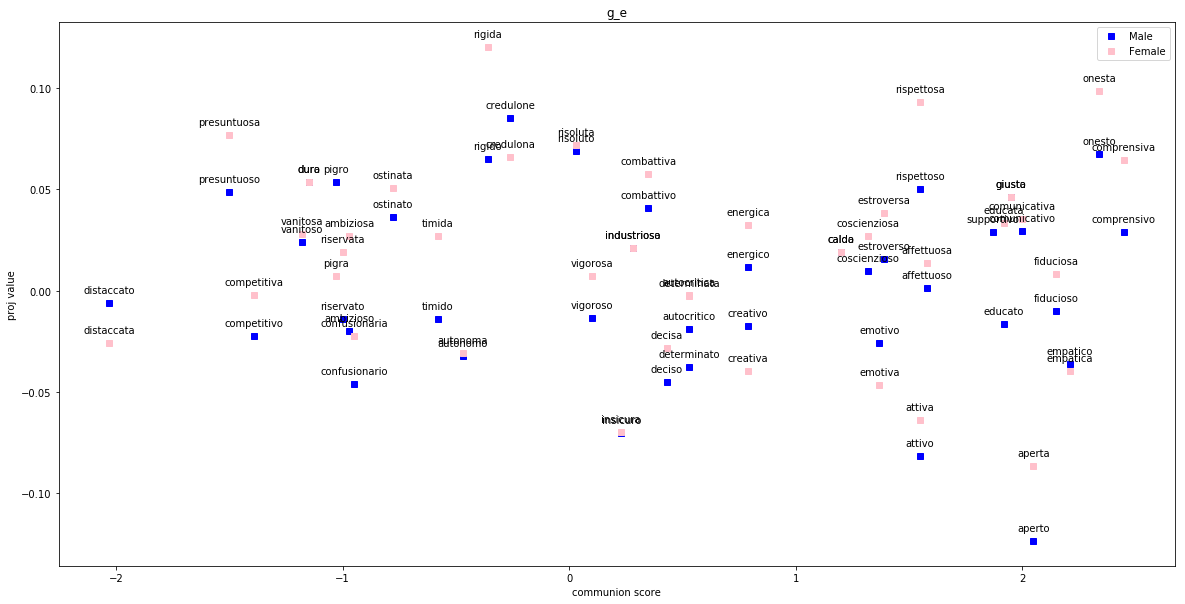

In [177]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(ag_com_gen_m_col6, ag_com_gen_m_col4, linewidth=0, marker='s', color='blue', label='Male')
ax.plot(ag_com_gen_f_col6, ag_com_gen_f_col4, linewidth=0, marker='s', color='pink', label='Female')
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_gen_m_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_m_col6[i], ag_com_gen_m_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ag_com_gen_f_col0):
    plt.annotate(label, # this is the text
                 (ag_com_gen_f_col6[i], ag_com_gen_f_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    

plt.show()
#fig.savefig('corr-plot/gen-mf/com/ft_deb_g_e')

##### Ungendered + mean gendered words

In [178]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])

proj_ag_com_gen_m_g_diff.pop(34)
proj_ag_com_gen_m_g_pca_0.pop(34)
proj_ag_com_gen_m_g_pca_01.pop(34)
proj_ag_com_gen_m_g_e.pop(34)

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

Word  Proj g_diff  Proj g_pca_0  Proj g_pca_01  Proj g_e  Agency  \
0           abile     0.091597      0.110417       0.067487  0.049583    2.32   
1       altruista    -0.096017     -0.061087      -0.054242  0.055994   -1.18   
2          capace     0.069480      0.049053       0.081890 -0.046876    2.45   
3      competente     0.105852      0.023342      -0.019695 -0.046294    2.21   
4        coerente     0.087345      0.043290       0.076583  0.085887    0.74   
5       dominante     0.000686      0.004070       0.006493  0.001854    2.76   
6      amichevole     0.054774      0.016603       0.022392 -0.062945    0.15   
7     disponibile    -0.103989     -0.064604      -0.035838  0.015749   -0.42   
8         egoista    -0.089678     -0.000278       0.011172  0.050072    1.53   
9    indipendente     0.042854     -0.013392      -0.006820 -0.058949    2.65   
10   intelligente     0.000021     -0.010615       0.047941  0.061769    2.21   
11          leale     0.091348      0.046515       0.031960  0.052940   -0.88   
12         morale     0.070576      0.058312       0.063676  0.043761   -0.78   
13  perfezionista     0.055634      0.079325       0.051034  0.103683    2.15   
14    persistente    -0.053203     -0.035145      -0.007172 -0.013441    1.78   
15      razionale     0.060427      0.110305       0.127538  0.049853    1.73   
16     affidabile     0.129393      0.043327       0.061338  0.024746    0.45   
17      sensibile    -0.060588     -0.029601       0.035141  0.060938   -1.03   
18      socievole    -0.096330     -0.039105      -0.007269  0.016870    0.66   
19     tollerante     0.063575      0.028879       0.058773  0.051808   -0.34   
20    vulnerabile    -0.047585     -0.055561      -0.006657 -0.001714   -2.29   
21         attivo     0.059283      0.079546       0.037987 -0.072543    2.35   
22     affettuoso    -0.085832     -0.125507      -0.085101  0.007538   -0.85   
23      ambizioso     0.039944      0.029909      -0.040464  0.003512    2.79   
24         deciso     0.034998     -0.021187      -0.070581 -0.036516    2.88   
25       vanitoso    -0.107198     -0.111765      -0.125545  0.025837    1.29   
26  confusionario    -0.017091     -0.049849      -0.071401 -0.034210   -1.89   
27   comunicativo     0.029055      0.003680       0.039136  0.032403    1.50   
28    competitivo     0.004707      0.026075      -0.002972 -0.012192    2.71   
29    presuntuoso     0.017598     -0.035521      -0.029008  0.062730    1.53   
30   coscienzioso     0.086439      0.007162      -0.002608  0.018456    0.58   
31     rispettoso     0.068386      0.036821       0.051836  0.071658   -0.35   
32       creativo    -0.025713      0.008166       0.006977 -0.028681    1.63   
33     distaccato     0.001686     -0.084030      -0.074100 -0.015771    1.61   
34    determinato     0.023678      0.005484       0.032049 -0.020017    2.73   
35         rigido    -0.047092     -0.006123       0.020736  0.092675    0.38   
36        emotivo    -0.062527     -0.040985      -0.035180 -0.036232   -1.47   
37       energico    -0.004582      0.016763      -0.053339  0.022073    2.42   
38         giusto     0.068090      0.037999       0.018709  0.046032   -0.50   
39      credulone    -0.052102     -0.052366      -0.047037  0.075499   -2.26   
40           duro    -0.002089     -0.002853      -0.040087  0.053375    1.95   
41         onesto     0.053770      0.014223      -0.006616  0.082919   -0.71   
42    industrioso     0.020933      0.045619       0.043773  0.021147    2.33   
43       insicuro    -0.091268     -0.102249      -0.106635 -0.069993   -2.35   
44          pigro    -0.071045     -0.006414      -0.021198  0.030268   -2.45   
45       ostinato     0.057811      0.029678      -0.002972  0.043406    2.43   
46         aperto     0.046310      0.057130      -0.010567 -0.104994    0.45   
47     estroverso    -0.157487     -0.101493      -0.094891  0.026988    1.11   
48        educato    -0.071403     -0.100897

In [180]:
# ag_com_mean pearson correlation
# agency correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col5, ag_com_mean_col4)[1]

In [181]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency mean correlation")
pearson_table

Agency mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.402593  0.443148  0.237635 -0.080689
p  0.001428  0.000391  0.067507  0.539963

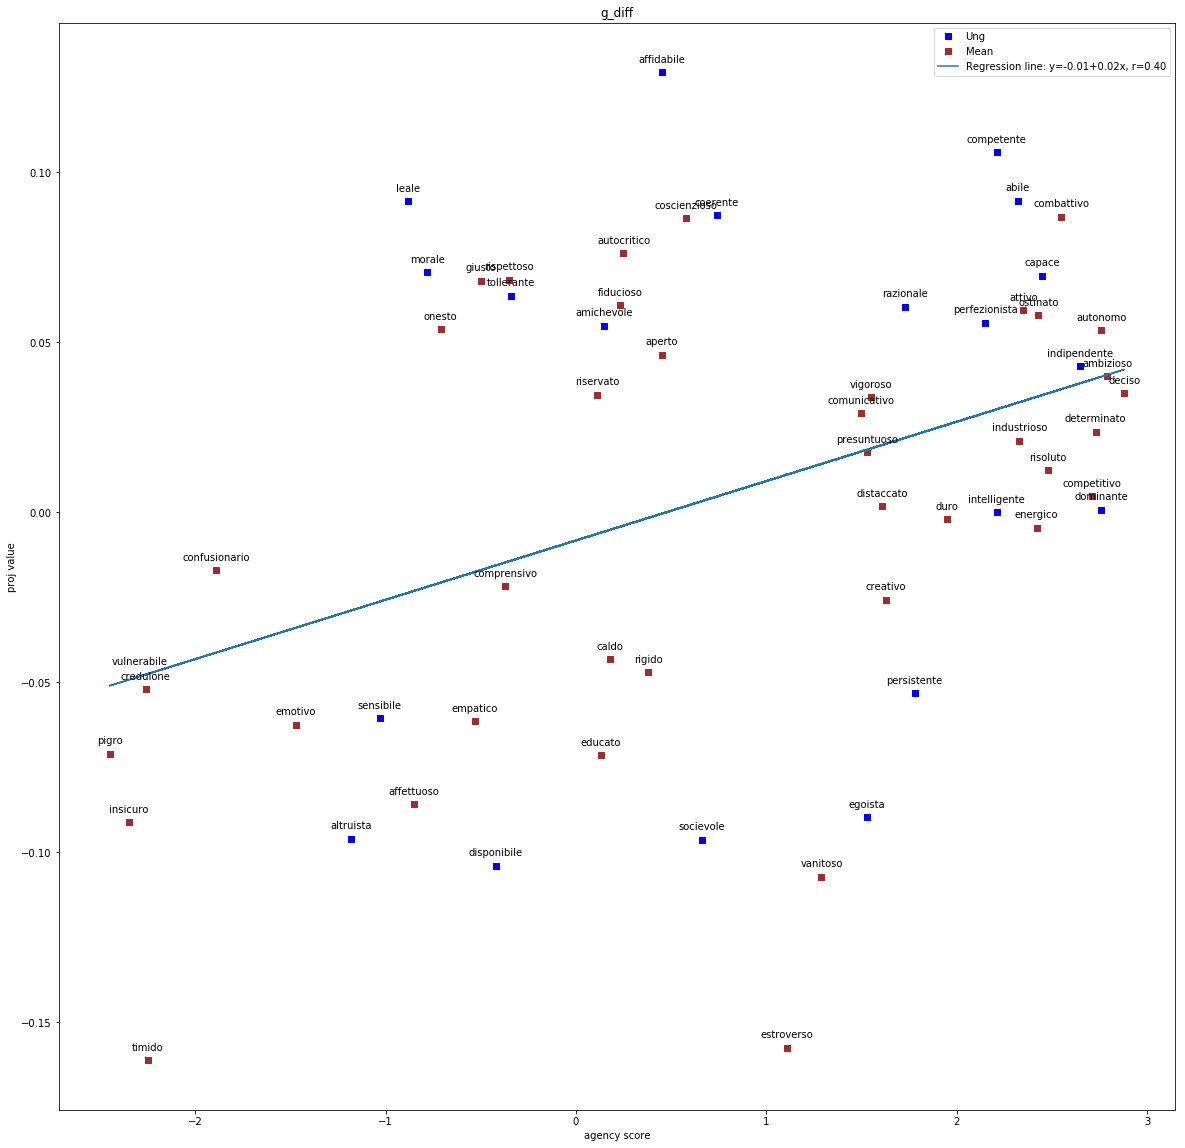

In [182]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_deb_g_diff')

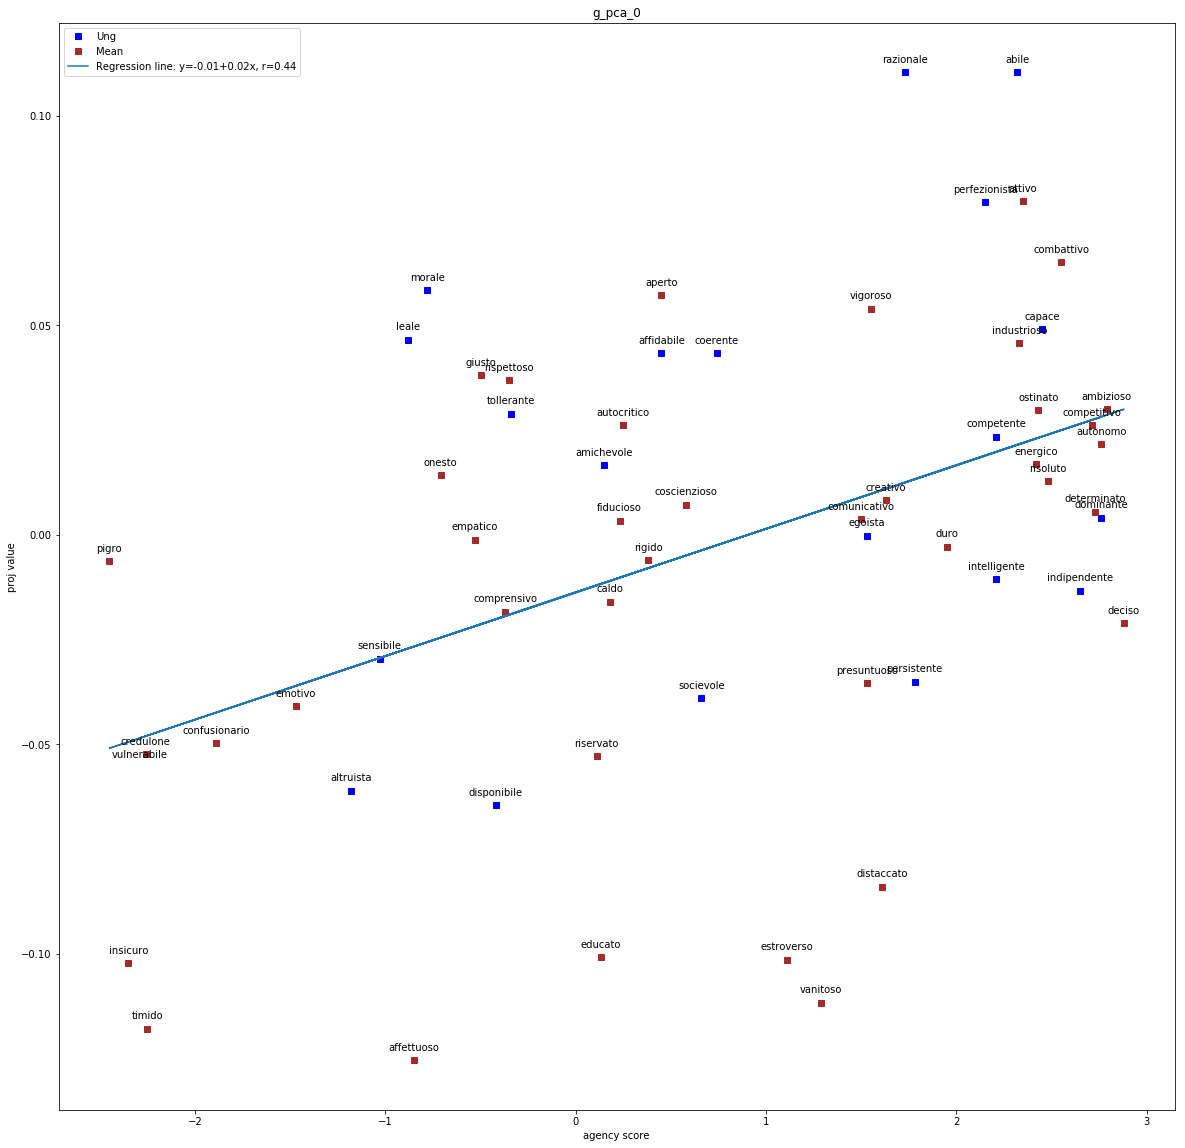

In [183]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_deb_g_pca_0')

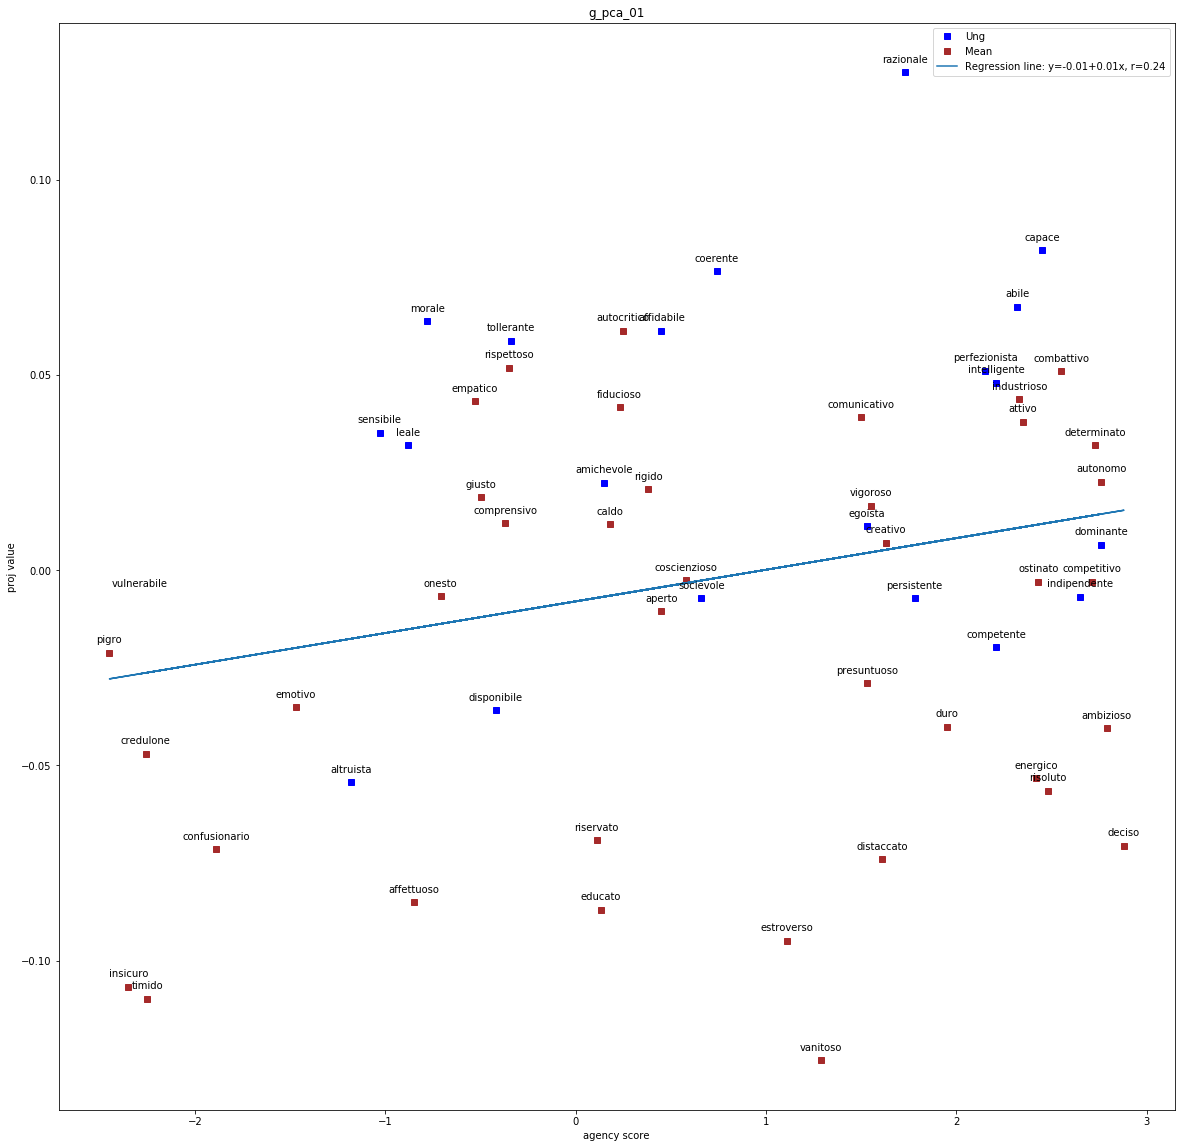

In [184]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_deb_g_pca_01')

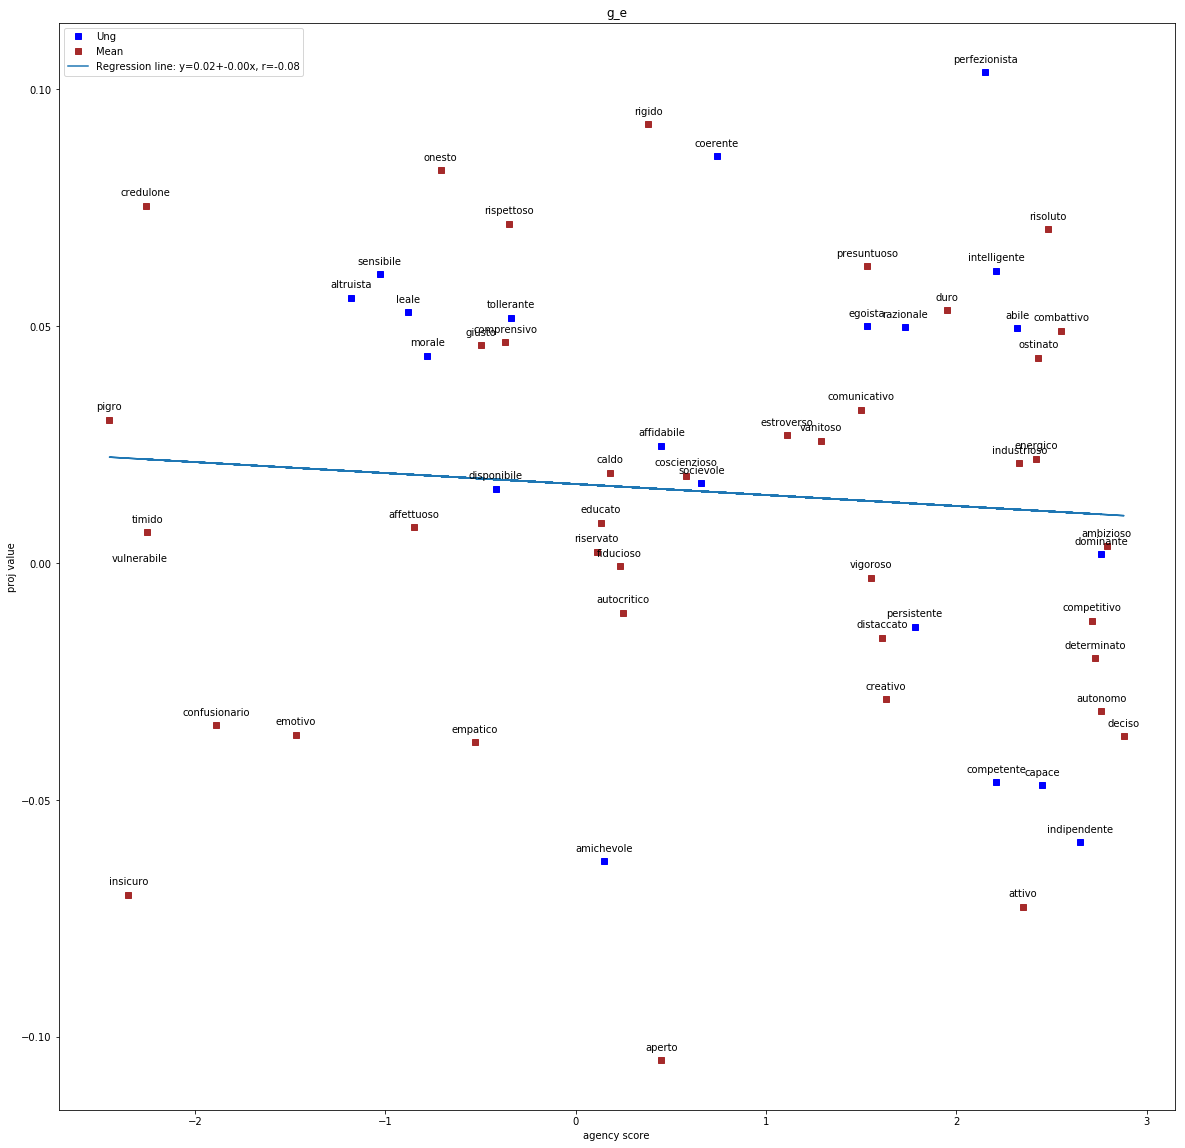

In [185]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col5[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col5[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col5[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/ag/ft_deb_g_e')

In [186]:
# communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(ag_com_mean_col6, ag_com_mean_col4)[1]

In [187]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Communion mean correlation")
pearson_table

Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.118189  0.127197  0.305019  0.024605
p  0.368444  0.332804  0.017801  0.851968

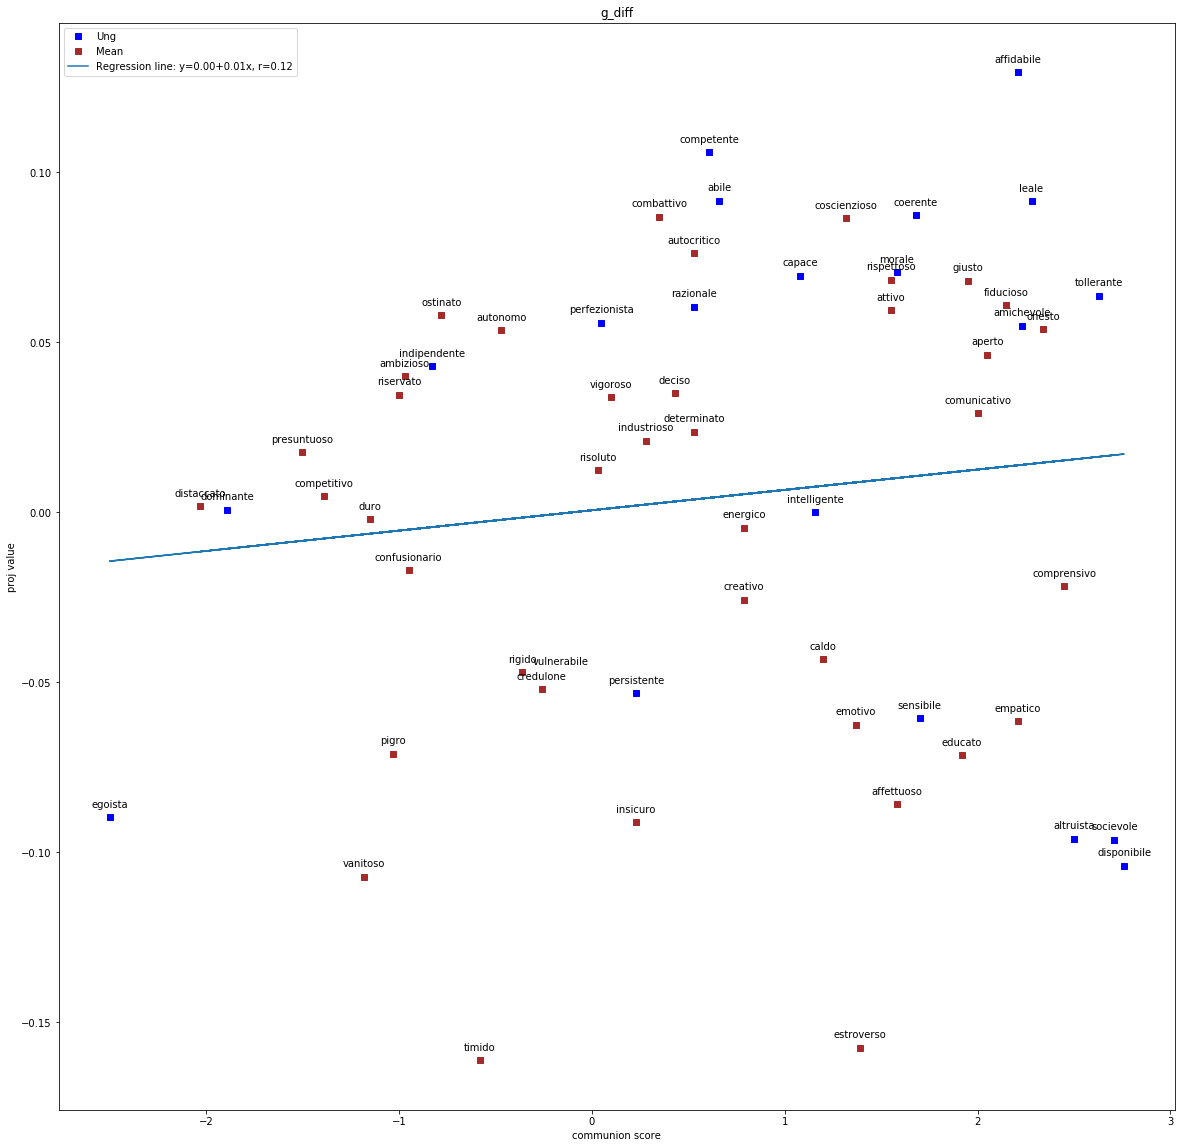

In [188]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col1[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col1[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_deb_g_diff')

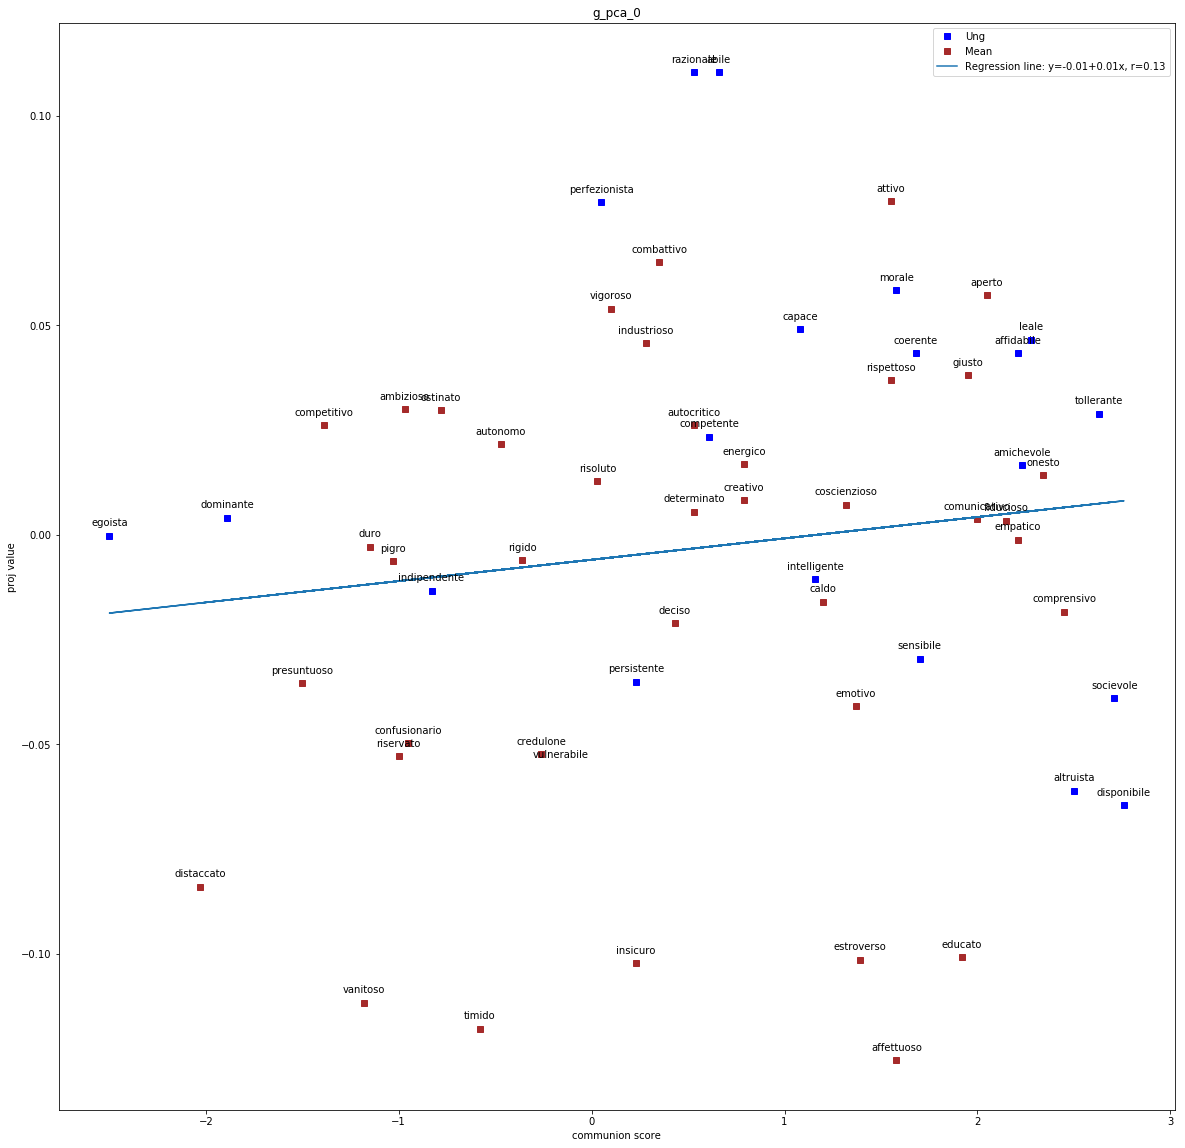

In [189]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col2[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col2[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_deb_g_pca_0')

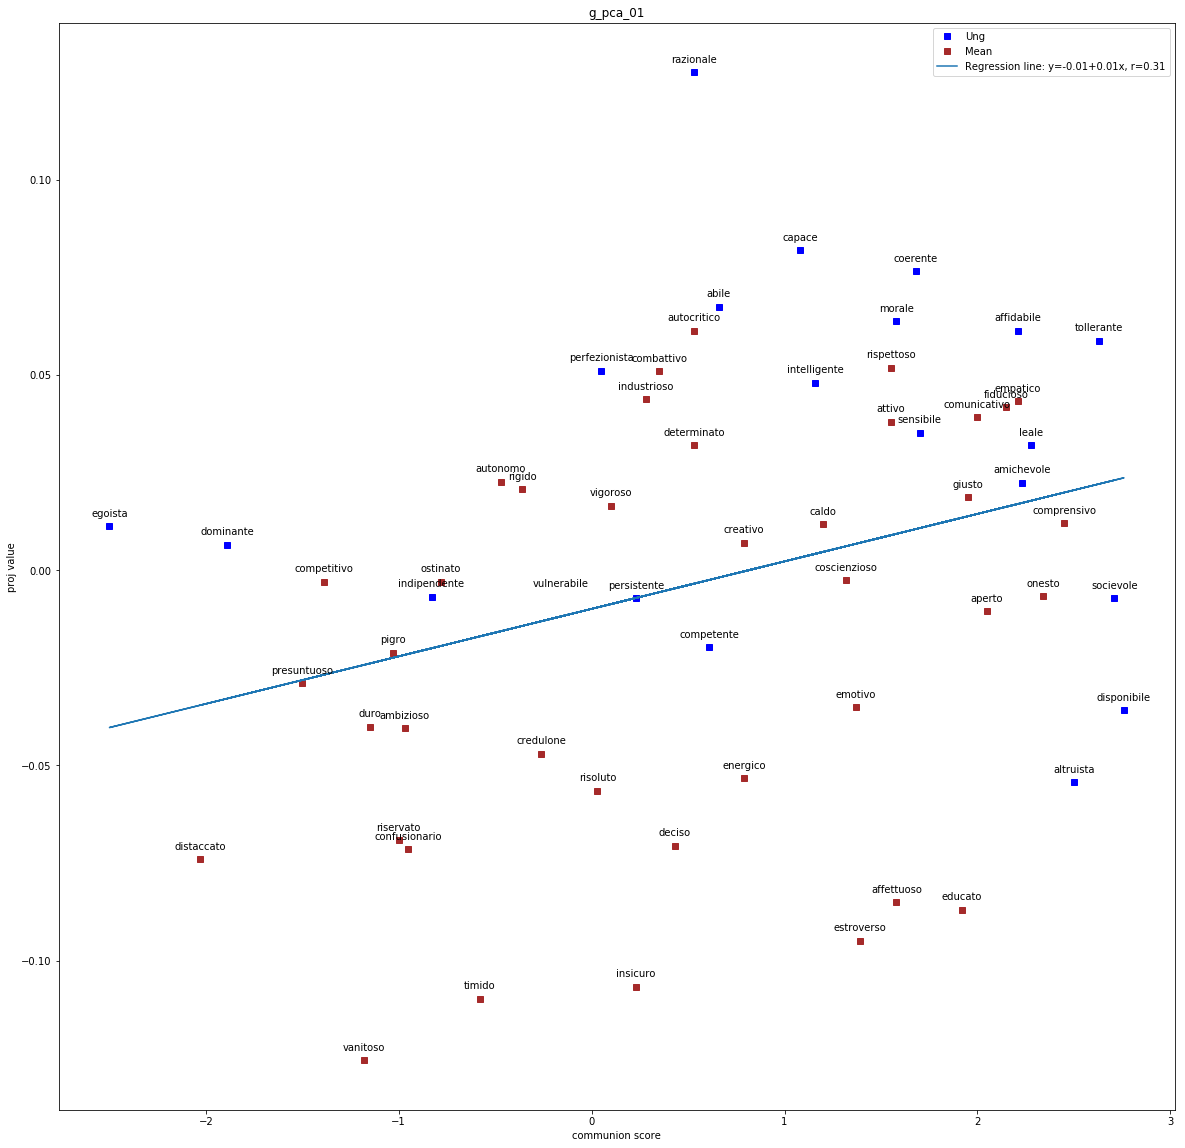

In [190]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col3[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col3[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_deb_g_pca_01')

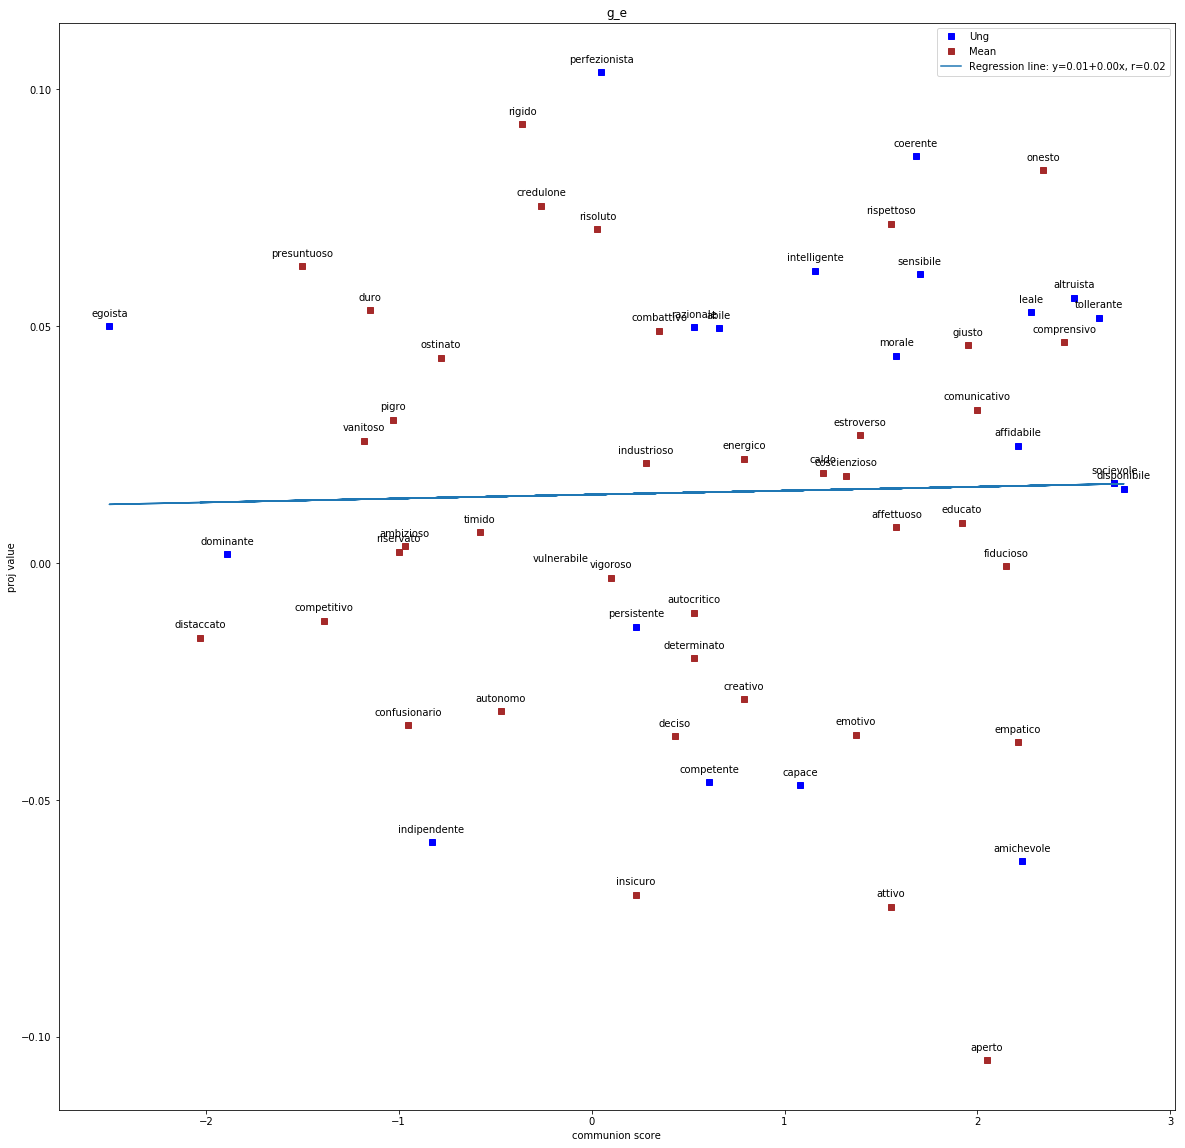

In [191]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(20,20))    
ax = fig.add_subplot(111)
ax.plot(ag_com_mean_col6[:20], ag_com_mean_col4[:20], linewidth=0, marker='s', color='blue', label='Ung')
ax.plot(ag_com_mean_col6[21:], ag_com_mean_col4[21:], linewidth=0, marker='s', color='brown', label='Mean')
ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)
ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ag_com_mean_col0):
    plt.annotate(label, # this is the text
                 (ag_com_mean_col6[i], ag_com_mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('corr-plot/mean/com/ft_deb_g_e')

In [192]:
# agency-communion correlation
r_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[0]
r_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[0]
r_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[0]
r_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[0]
p_ag_com_mean_g_diff = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col1)[1]
p_ag_com_mean_g_pca_0 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col2)[1]
p_ag_com_mean_g_pca_01 = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col3)[1]
p_ag_com_mean_g_e = scipy.stats.pearsonr(np.array(ag_com_mean_col5)-np.array(ag_com_mean_col6), ag_com_mean_col4)[1]

In [193]:
pearson_data = {'g_diff':[r_ag_com_mean_g_diff,p_ag_com_mean_g_diff],
                'g_pca_0':[r_ag_com_mean_g_pca_0,p_ag_com_mean_g_pca_0],
                'g_pca_01':[r_ag_com_mean_g_pca_01,p_ag_com_mean_g_pca_01],
                'g_e':[r_ag_com_mean_g_e,p_ag_com_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
print("Agency-Communion mean correlation")
pearson_table

Agency-Communion mean correlation


g_diff   g_pca_0  g_pca_01       g_e
r  0.201174  0.223092 -0.015509 -0.067880
p  0.123241  0.086643  0.906372  0.606325